
# EXECUTIVE SUMMARY

<div style="text-align: justify;">

The goal of this project was to work with the Co-operators dataset and utilize its information to predict whether an individual would buy an auto insurance policy. The original dataset consisted of 25 features, and the target variable was IS_BOUND which describes whether customers bought the insurance (IS_BOUND = 1) or declined (IS_BOUND = 0). The total number of customers in the training set were 101,891 and 15,114 in the test set.

**Data Pre-processing**: Before evaluating the models mentioned above, significant time was dedicated to exploratory analysis and data cleaning due to the dataset's mis-spelled and missing entries. The data were categorized into three sections for cleanup:

1) Columns with no missing values: Even though certain columns had no missing values, they had mis-spelled entries. For eg., the column with vehicle make information had multiple mis-spelled entries for the same make: 
    "CEVROLET", 'CHCVIOE', 'CHERVOLET', 'CHEV', 'CHEVRELOT', 'CHEVROELT', 'CHEVROLE', 'CHEVROLER', 'CHEVY'
were entered in the dataset for the same make: 'CHEVROLET'. We created a function which rectifies these data entry errors for vehicle makes. Another example was the column containing area code information. Thousands of customers had 'Unk' or unknown as their area code. We used the postal code information to fill in missing area code values.

2) Columns with missing values: Certain columns such as _YEARS_AS_PRINCIPAL_DRIVER_, _MARKING_SYSTEM_ and _TRACKING_SYSTEM_ had more than 99% of values missing. We dropped these columns. Other columns such as _YEARS_LICENSED_ were completed by utilizing a linear regression model to predict YEARS_LICENSED based on the YEAR_OF_BIRTH column. For missing _MARITAL_STATUS_, we imputed missing values based on the age of the customers since older customers were more likely to be widowed, middle-aged were divorced/separated and young were single. 

**Feature Engineering**: We used the PGeocode library in Python to convert POSTAL CODE to latitude and longitude. Since there were thousands of unique vehicle models and incorporating each one of them would have created as many new columns making the dataset huge, we only retained models with customer count of more than 50. The less frequently bought models were labeled as rare. Since all quotes were made in the year of 2016, the QUOTEDATE column was replaced with a MONTH column, and dummy variables were generated to account for categorical variables.

These steps aimed to ensure data completeness and construct a more robust dataset for modeling purposes.

**Data Modeling**: After dataset preparation, we analyzed the dataset using two methods. First, we split the dataset into 90% training and 10% test set and trained a fine-tuned XGBoost Classifier on the 90% trainig set which contained ~80% records with class 0. In the second method, we used undersampling to preserve equal class distribution so that the model has equal number of examples of each class to learn from and doesn't overpredict all examples as the majority class 0. In the second method, we also used the XGBoost classifier to train on the balanced training set. However, the performance of both models was comparable on the unbalanced test set (ROC AUC ~ 0.67).
    
In the end we selected the model trained on undersampled dataset because it performed as good as the larger, unbalanced training set but uses less resources and trains/predicts faster.    

**Feate Importances:** Using chi-square and t-test analysis, we found that auto policies bundled with other products and location (longitude) were the most important features in predicting whether customers buy insurance or not.  

**Test Set**: The models were then used to make predictions on our test set. The same steps were taken to prepare the data for testing, and predictions were made and stored in a list for submission to the leaderboard as part of this project.

In [1]:
# Import the relevant libraries
# DATA pre-processing
import pandas as pd
from collections import Counter
from sklearn.impute import SimpleImputer
import numpy as np
import time

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pgeocode
import plotly.express as px

# Data Wrangling and Model Building
import package_outlier as po
from scipy import stats
from scipy.stats import pearsonr, ttest_ind, chi2_contingency
from scipy import sparse
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve, make_scorer

In [2]:
# Read the training data from the Excel file
insurance_train_data = pd.read_excel("data/Cooperators_Quotes_Dataset_Training.xlsx")

# Print the shape of the training data
print('shape of train data:', insurance_train_data.shape, '\n')

# Display the first few rows of the training data
insurance_train_data.head()

shape of train data: (101891, 26) 



QUOTEDATE  VEHICLEYEAR          VEHICLEMAKE  \
0 2016-01-02         2006           VOLKSWAGEN   
1 2016-01-02         2017              HYUNDAI   
2 2016-01-02         2015  CHEVROLET TRUCK/VAN   
3 2016-01-02         2010               TOYOTA   
4 2016-01-04         2013                HONDA   

                        VEHICLEMODEL  ANNUAL_KM  COMMUTE_DISTANCE  \
0                       JETTA 2.5 4P    10000.0               NaN   
1                     ELANTRA GL 4DR    20000.0               NaN   
2  SILVERADO 2500 HD LT CREW CAB 4WD    15000.0               NaN   
3                     COROLLA CE 4DR    20000.0              20.0   
4                       CIVIC LX 4DR    30000.0              30.0   

  MARKING_SYSTEM TRACKING_SYSTEM VEHICLE_OWNERSHIP  VEHICLE_VALUE  ...  \
0            NaN             NaN             Owned         3000.0  ...   
1            NaN             NaN             Owned            1.0  ...   
2            NaN             NaN               NaN            NaN  ...   
3            NaN             NaN               NaN            NaN  ...   
4            NaN             NaN               NaN            NaN  ...   

  YEARS_AS_PRINCIPAL_DRIVER MULTI_PRODUCT  MARITAL_STATUS OCCUPATION  \
0                      10.0            No         Married     Trades   
1                       NaN            No         Married  Not Known   
2                       NaN            No          Single  Not Known   
3                       NaN           Yes          Single  Not Known   
4                       NaN           Yes          Single  Not Known   

  CONVICTION_COUNT_MINOR_3YRS  CONVICTION_COUNT_MAJOR_3YRS  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   CONVICTION_COUNT_CRIMINAL_3YRS ASSIGNED_LOSSES_PD_5YRS SUSPENSION_COUNT  \
0                               0                       0                0   
1                               0                       0                0   
2                               0                       0                0   
3                               0                       0                0   
4                               0                       0                0   

  IS_BOUND  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 26 columns]

# EXPLORATORY DATA ANALYSIS AND DATA CLEANING

In [3]:
# Display the information about the dataframe i.e. the data types and the non-null counts
insurance_train_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101891 entries, 0 to 101890
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   QUOTEDATE                       101891 non-null  datetime64[ns]
 1   VEHICLEYEAR                     101891 non-null  int64         
 2   VEHICLEMAKE                     101891 non-null  object        
 3   VEHICLEMODEL                    101891 non-null  object        
 4   ANNUAL_KM                       101890 non-null  float64       
 5   COMMUTE_DISTANCE                66478 non-null   float64       
 6   MARKING_SYSTEM                  25 non-null      object        
 7   TRACKING_SYSTEM                 4 non-null       object        
 8   VEHICLE_OWNERSHIP               25441 non-null   object        
 9   VEHICLE_VALUE                   37218 non-null   float64       
 10  VEHICLEUSE                      101891 non-null  object 

Let's use Postal Code information to find the location of the customer in (latitude, longitude). Converting categorical variable to numerical will help us minimize the number of columns while model building. Otherwise, converting postal codes to numerical values using one hot encoding will lead to too many columns and increase the size of our data.

In [4]:
def postal_code_to_location(df, country, code, filename):
    '''
    This function uses the pgeocode module to convert postal/zip codes to latitude 
    and longitude coordinates. The postal codes and corresponding latitudes 
    and longitudes are saved in a csv file for further use.
    Input: df or dataframe
        filename: name of output file
    '''
    # Create an instance of the Nominatim class with the country code Canada
    nomi = pgeocode.Nominatim(country)
    
    # Use the apply function to query the latitude and longitude for each postal code in the dataframe
    lat_long_df = df[code].apply(lambda x:nomi.query_postal_code(x)) 

    # Save the resulting dataframe to a CSV file named 'lat_long.csv'
    lat_long_df.to_csv(filename)    

In [4]:
# filename = 'lat_long.csv'
# postal_code_to_location(insurance_train_data, 'ca', "POSTAL_CODE", filename)

In [5]:
# Read the latitude and longitude data from the 'lat_long.csv' file
lat_long_df = pd.read_csv('lat_long.csv')

# Assign the latitude values from the lat_long_df to the 'latitude' column in the insurance_train_data DataFrame
insurance_train_data['latitude'] = lat_long_df['latitude'].values

# Assign the latitude values from the lat_long_df to the 'longitude' column in the insurance_train_data DataFrame
insurance_train_data['longitude'] = lat_long_df['longitude'].values

# Display the first few rows of the insurance_train_data DataFrame
insurance_train_data.head()

QUOTEDATE  VEHICLEYEAR          VEHICLEMAKE  \
0 2016-01-02         2006           VOLKSWAGEN   
1 2016-01-02         2017              HYUNDAI   
2 2016-01-02         2015  CHEVROLET TRUCK/VAN   
3 2016-01-02         2010               TOYOTA   
4 2016-01-04         2013                HONDA   

                        VEHICLEMODEL  ANNUAL_KM  COMMUTE_DISTANCE  \
0                       JETTA 2.5 4P    10000.0               NaN   
1                     ELANTRA GL 4DR    20000.0               NaN   
2  SILVERADO 2500 HD LT CREW CAB 4WD    15000.0               NaN   
3                     COROLLA CE 4DR    20000.0              20.0   
4                       CIVIC LX 4DR    30000.0              30.0   

  MARKING_SYSTEM TRACKING_SYSTEM VEHICLE_OWNERSHIP  VEHICLE_VALUE  ...  \
0            NaN             NaN             Owned         3000.0  ...   
1            NaN             NaN             Owned            1.0  ...   
2            NaN             NaN               NaN            NaN  ...   
3            NaN             NaN               NaN            NaN  ...   
4            NaN             NaN               NaN            NaN  ...   

  MARITAL_STATUS OCCUPATION  CONVICTION_COUNT_MINOR_3YRS  \
0        Married     Trades                            0   
1        Married  Not Known                            0   
2         Single  Not Known                            0   
3         Single  Not Known                            0   
4         Single  Not Known                            0   

  CONVICTION_COUNT_MAJOR_3YRS CONVICTION_COUNT_CRIMINAL_3YRS  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   ASSIGNED_LOSSES_PD_5YRS  SUSPENSION_COUNT IS_BOUND latitude longitude  
0                        0                 0        0  45.6442  -73.8448  
1                        0                 0        0  43.1607  -79.7463  
2                        0                 0        0  53.5996 -113.4549  
3                        0                 0        0  43.7196  -79.6854  
4                        0                 0        0  43.8479  -79.3288  

[5 rows x 28 columns]

In [6]:
# Extracting latitude values from lat_long_df
latitude = lat_long_df['latitude'].values

# Extracting longitude values from lat_long_df
longitude = lat_long_df['longitude'].values

# Creating a new column 'location' in insurance_train_data
# and assigning a tuple of latitude and longitude for each row
insurance_train_data['location'] = [(latitude[i], longitude[i]) for i in range(len(latitude))]

In [7]:
# Create an empty DataFrame to store location data
location_df = pd.DataFrame()
# Create an empty list to store latitude values
latitudes = []
# Create an empty list to store longitude values
longitudes = []  
# Create an empty list to store count values
counts = []  

# Iterate over the unique locations in the insurance_train_data DataFrame
for key, value in Counter(insurance_train_data['location']).items():
    # Append the latitude value to the latitudes list
    latitudes.append(key[0])
    # Append the longitude value to the longitudes list
    longitudes.append(key[1])  
    # Append the count value to the counts list
    counts.append(value)  

# Add the latitude, longitude, and count lists as columns to the location_df DataFrame
location_df['latitude'] = latitudes
location_df['longitude'] = longitudes
location_df['count'] = counts

# Display the first few rows of the location_df DataFrame
location_df.head()  

latitude  longitude  count
0   45.6442   -73.8448      3
1   43.1607   -79.7463    431
2   53.5996  -113.4549      5
3   43.7196   -79.6854    125
4   43.8479   -79.3288    430

Let's view the location of the customers on the map on Canada with Red regions signifying more customers and Blue regions with less customers. 

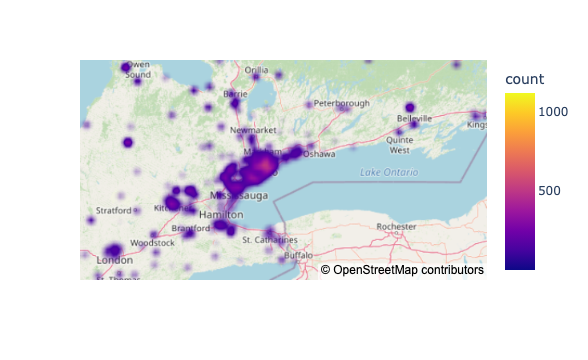

In [8]:
# Data with latitude/longitude and values

fig = px.density_mapbox(location_df, lat = 'latitude', lon = 'longitude', z = 'count',
                        radius = 8,
                        center = dict(lat = 43.6, 
                                      lon = -79.3),
                        zoom = 6,
                        mapbox_style = 'open-street-map')
fig.show()

In [8]:
# Grouping the insurance_train_data by latitude and longitude and calculating the sum of customers who bought insurance (IS_BOUND)
is_bound_df = insurance_train_data.groupby(['latitude', 'longitude'])['IS_BOUND'].sum().reset_index()

# Merging the is_bound_df with location_df based on latitude and longitude
is_bound_df = is_bound_df.merge(location_df, on = ['latitude', 'longitude'])

# Calculating the purchase frequency by dividing IS_BOUND by count of customers in the region
is_bound_df['purchase_frequency'] = is_bound_df['IS_BOUND']/is_bound_df['count']

# Calculating the global average of IS_BOUND
global_average = sum(is_bound_df['IS_BOUND'])/insurance_train_data.shape[0]

# Printing the Canada-wide percentage of customers buying insurance
print('Canada-wide percentage of customers buying Cooperators insurance:', round(global_average,2)*100, '%')

# Calculating the purchase frequency deviation by subtracting global_average from purchase_frequency
is_bound_df['purchase_frequency_deviation'] = is_bound_df['purchase_frequency'] - global_average

# Displaying the first few rows of the is_bound_df
is_bound_df.head()

Canada-wide percentage of customers buying Cooperators insurance: 22.0 %


latitude  longitude  IS_BOUND  count  purchase_frequency  \
0   42.0502   -82.7598        19     48            0.395833   
1   42.0549   -82.6062        34    120            0.283333   
2   42.1168   -83.0498        19    126            0.150794   
3   42.1751   -82.8248        15     61            0.245902   
4   42.1783   -82.7715        69    247            0.279352   

   purchase_frequency_deviation  
0                      0.177198  
1                      0.064698  
2                     -0.067842  
3                      0.027266  
4                      0.060717

In [10]:
# Defining 'Big Markets' as regions with more that 100 customers
big_market_df = is_bound_df.loc[is_bound_df['count'] > 100]
big_market_df.head()

latitude  longitude  IS_BOUND  count  purchase_frequency  \
1   42.0549   -82.6062        34    120            0.283333   
2   42.1168   -83.0498        19    126            0.150794   
4   42.1783   -82.7715        69    247            0.279352   
5   42.2007   -83.0276        44    130            0.338462   
6   42.2187   -83.0801        30    121            0.247934   

   purchase_frequency_deviation  
1                      0.064698  
2                     -0.067842  
4                      0.060717  
5                      0.119826  
6                      0.029298

In [11]:
# Defining 'Top Markets' as locations where the percentage of buyers is 15% more than the Canada-wide average
big_market_df_top = big_market_df.loc[big_market_df['purchase_frequency_deviation'] > 0.15]

# Defining 'Bottom Markets' as locations where the percentage of buyers is 15% less than the Canada-wide average
big_market_df_bottom = big_market_df.loc[big_market_df['purchase_frequency_deviation'] < -0.15]

In [12]:
# Displaying the first few rows of the top markets
big_market_df_top.head()

latitude  longitude  IS_BOUND  count  purchase_frequency  \
18    42.3176   -82.9929        38    101            0.376238   
43    42.9403   -79.9450        63    160            0.393750   
65    43.0334   -80.8830        52    138            0.376812   
89    43.1923   -79.2559        50    125            0.400000   
120   43.3668   -80.9497        75    195            0.384615   

     purchase_frequency_deviation  
18                       0.157602  
43                       0.175114  
65                       0.158176  
89                       0.181364  
120                      0.165980

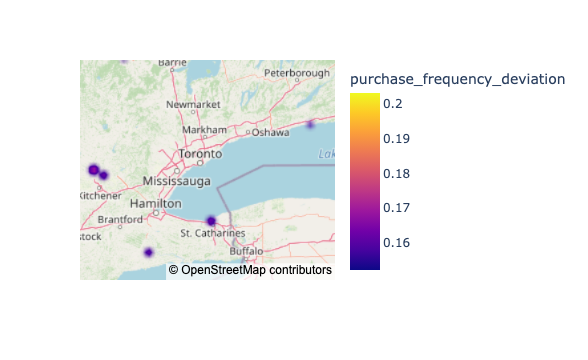

In [13]:
# Looking at top markets on a map

fig = px.density_mapbox(big_market_df_top, lat = 'latitude', lon = 'longitude', z = 'purchase_frequency_deviation',
                        radius = 8,
                        center = dict(lat = 43.6, 
                                      lon = -79.3),
                        zoom = 6,
                        mapbox_style = 'open-street-map',
                    )
fig.show()

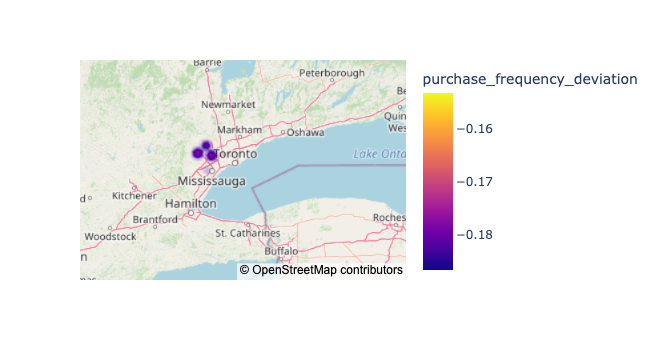

In [14]:
# Looking at bottom markets on a map

fig = px.density_mapbox(big_market_df_bottom, lat = 'latitude', lon = 'longitude', z = 'purchase_frequency_deviation',
                        radius = 8,
                        center = dict(lat = 43.6, 
                                      lon = -79.3),
                        zoom = 6,
                        mapbox_style = 'open-street-map',
                    )
fig.show()

**Conclusion: Places away from Toronto like Elmira, St. Katherine's, Stratford had above average percentage of customers buying Cooperators policy whereas regions closer to Toronto had fewer customers buying Cooperators auto insurance policies than overall average.**

## COLUMNS WITH NO MISSING VALUES

In [8]:
def missing_values(df):
    '''
    This function returns a list of columns containing missing values.
    Arg: df: dataframe
    Returns: columns_with_missing_vals: column containing missing values
    '''
    # Create an empty list to store column names with no missing values
    columns_with_missing_vals = []  

    # Iterate through each column in the DataFrame
    for col in df.columns.values:  
        # Count the number of missing values in the current column
        num_missing_vals = df[col].isna().sum()  

        # If there are missing values in the current column
        if num_missing_vals > 0:  
            # Add the column name to the list
            columns_with_missing_vals.append(col)  

    # Print the list of column names with missing values
    return columns_with_missing_vals 

In [9]:
columns_with_missing_vals = missing_values(insurance_train_data)
print('columns with missing values')
columns_with_missing_vals

columns with missing values


['ANNUAL_KM',
 'COMMUTE_DISTANCE',
 'MARKING_SYSTEM',
 'TRACKING_SYSTEM',
 'VEHICLE_OWNERSHIP',
 'VEHICLE_VALUE',
 'GENDER',
 'YEARS_LICENSED',
 'YEARS_AS_PRINCIPAL_DRIVER',
 'OCCUPATION',
 'latitude',
 'longitude']

In [10]:
columns_with_no_missing_vals = [col for col in insurance_train_data.columns.values if col not in columns_with_missing_vals]
print('columns with no missing values')
columns_with_no_missing_vals

columns with no missing values


['QUOTEDATE',
 'VEHICLEYEAR',
 'VEHICLEMAKE',
 'VEHICLEMODEL',
 'VEHICLEUSE',
 'YEAR_OF_BIRTH',
 'POSTAL_CODE',
 'AREA_CODE',
 'MULTI_PRODUCT',
 'MARITAL_STATUS',
 'CONVICTION_COUNT_MINOR_3YRS',
 'CONVICTION_COUNT_MAJOR_3YRS',
 'CONVICTION_COUNT_CRIMINAL_3YRS',
 'ASSIGNED_LOSSES_PD_5YRS',
 'SUSPENSION_COUNT',
 'IS_BOUND',
 'location']

In [11]:
# Loop through each column in the dataframe with no missing values and print the corresponding statistics
i = iter(range(len(columns_with_no_missing_vals)))

In [12]:
# See the details of the quote dates with no missing values using the describe function
col = columns_with_no_missing_vals[next(i)]
print(col)
insurance_train_data[col].describe()

QUOTEDATE


count                           101891
mean     2016-07-08 13:42:40.889578240
min                2016-01-02 00:00:00
25%                2016-04-26 00:00:00
50%                2016-07-06 00:00:00
75%                2016-09-21 00:00:00
max                2016-12-30 00:00:00
Name: QUOTEDATE, dtype: object

In [13]:
# See the details of the vehicle years with no missing values using the describe function
col = columns_with_no_missing_vals[next(i)]
print(col)
insurance_train_data[col].describe()

VEHICLEYEAR


count    101891.000000
mean       2008.899677
std           5.823742
min        1930.000000
25%        2005.000000
50%        2010.000000
75%        2013.000000
max        2019.000000
Name: VEHICLEYEAR, dtype: float64

In [14]:
# Check to see the set of unique values of vehicle makes present in each column to get the feel of data.
col = columns_with_no_missing_vals[next(i)]
print(col,'\n')
print(sorted(Counter(insurance_train_data[col]).keys()))

VEHICLEMAKE 

['1FTFW1EF8BFA01523', '2XXXXXXXXXXXXXXXXXX', 'ACCURA', 'ACURA', 'ACURA TRUCK/VAN', 'ALFA', 'ALFA ROMEO', 'ALTIMA', 'AM GENERAL', 'AMC', 'AMERICAN MOTORS', 'ARCTIC CAT', 'ARTCIT CAT', 'ARTIC CAT', 'ASTON MARTIN', 'ASTRO', 'AUDI', 'AUDI TRUCK/VAN', 'AUSTIN-HEALEY', 'BENTLEY', 'BENTLEY TRUCK/VAN', 'BLUE BIRD CORP', 'BMW', 'BMW CAMION/VAN', 'BMW TRUCK/VAN', 'BOMBADIER', 'BOMBARDIER', 'BRICKLIN', 'BUICK', 'BUICK TRUCK/VAN', 'CADILLAC', 'CADILLAC CAMION/VAN', 'CADILLAC TRUCK/VAN', 'CADILLIAC', 'CAMRY', 'CELICA', 'CEVROLET', 'CHALLENGER', 'CHCVIOE', 'CHERVOLET', 'CHEV', 'CHEVRELOT', 'CHEVROELT', 'CHEVROLE', 'CHEVROLER', 'CHEVROLET', 'CHEVROLET CAMION/VAN', 'CHEVROLET TRUCK/VAN', 'CHEVY', 'CHEVY CRUZ', 'CHRSYLER', 'CHRYLSER', 'CHRYSLER', 'CHRYSLER TRUCK/VAN', 'CHYRSLER', 'CIVIC', 'COACHMEN', 'COBRA - AC', 'CONVERTED', 'COROLLA', 'CORROLLA', 'CORVETTE', 'CRYSLER', 'CUTLASS', 'DAEWOO', 'DODGE', 'DODGE GRAND CARAVAN', 'DODGE RAM', 'DODGE/RAM', 'DODGE/RAM CAMION/VAN', 'DODGE/RAM TRUC

#### VEHICLEMAKE

**In the VEHICLEMAKE section, there are multiple entries for the same vehicle make. To ensure accuracy and consistency, we will replace any duplicates or incorrectly categorized entries for vehicle makes in our dataset. For instance, 'ACURA' is misspelled as 'ACCURA,' despite both referring to the same make. Similar inconsistencies exist for other entries in this column.**

In [15]:
def vehicle_make_correction(df, column = "VEHICLEMAKE"):
    '''
    This function renames the mis-spelled vehicle makes.
    Args: df: orifinal dataframe with misspelled makes.
    Return: df: dataframe with corrected makes.
    '''
    df.loc[df[column] == "ACCURA", column] = 'ACURA'
    df.loc[df[column] == "ALTIMA", column] = 'NISSAN'
    df.loc[df[column] == "CAMRY", column] = 'TOYOTA'
    df.loc[df[column] == "CHALLENGER", column] = 'DODGE'
    df.loc[df[column] == "CIVIC", column] = 'HONDA'
    df.loc[df[column].isin(["ELANTRA", 'ELANTRA GT']), column] = 'HYUNDAI'
    df.loc[df[column].isin(["ARTCIT CAT", 'ARTIC CAT']), column] = 'ARCTIC CAT'
    df.loc[df[column].isin(["BOMBADIER"]), column] = 'BOMBARDIER'
    df.loc[df[column].isin(["CADILLIAC"]), column] = 'CADILLAC'
    df.loc[df[column].isin(["CEVROLET", 'CHCVIOE', 'CHERVOLET', 'CHEV', 'CHEVRELOT', 'CHEVROELT', 'CHEVROLE', 'CHEVROLER', 'CHEVY']), column] = 'CHEVROLET'
    df.loc[df[column].isin(["CHRSYLER", 'CHRYLSER', 'CHYRSLER', 'CRYSLER']), column] = 'CHRYSLER'
    df.loc[df[column].isin(["CORROLLA", 'COROLLA']), column] = 'TOYOTA'
    df.loc[df[column].isin(["DODGE RAM"]), column] = 'DODGE/RAM'
    df.loc[df[column].isin(["DOGDE"]), column] = 'DODGE'
    df.loc[df[column].isin(["F150", 'FORD F150']), column] = 'FORD 150'
    df.loc[df[column].isin(["GRAND"]), column] = 'GRAND CARAVAN'
    df.loc[df[column].isin(["HARLEY"]), column] = 'HARLEY DAVIDSON'
    df.loc[df[column].isin(['HONDA  CIVIC', 'HONDA CIVIC']), column] = 'HONDA'
    df.loc[df[column].isin(['HONODA']), column] = 'HONDA'
    df.loc[df[column].isin(['HUNDAI', 'HUNDAY', 'HYNDAI', 'HYNDEI', 'HYUANDAI', 'HYUNDIA']), column] = 'HYUNDAI'
    df.loc[df[column].isin(["INFINITY", 'INFINTI']), column] = 'INFINITI'
    df.loc[df[column].isin(["JEPP"]), column] = 'JEEP'
    df.loc[df[column].isin(["LAND ROVER"]), column] = 'LANDROVER'
    df.loc[df[column].isin(["MADZA", 'MAZDS']), column] = 'MAZDA'
    df.loc[df[column].isin(["MAZDA3"]), column] = 'MAZDA 3'
    df.loc[df[column].isin(["MECEDEZ"]), column] = 'MERCEDES'
    df.loc[df[column].isin(['MERCEDES BENZ', 'MERCEDEZ BENZ']), column] = 'MERCEDES-BENZ'
    df.loc[df[column].isin(["MITIBUSHI"]), column] = 'MITSUBISHI'
    df.loc[df[column].isin(['NISASN','NISSIAN','NISSSAN']), column] = 'NISSAN'
    df.loc[df[column].isin(['PONTAIC', 'PONTIIAC', 'POTIAC']), column] = 'PONTIAC'
    df.loc[df[column].isin(['PORCHE', 'PROSCHE']), column] = 'PORSCHE'
    df.loc[df[column].isin(['SKI-DOO']), column] = 'SKIDOO'
    df.loc[df[column].isin(['TOTOTA', 'TOYOATA', 'TOYOTO', 'TOYTO']), column] = 'TOYOTA'
    df.loc[df[column].isin(['TRAIL LIGHT']), column] = 'TRAILLITE'
    df.loc[df[column].isin(['TRIU']), column] =  'TRIUMPH'
    df.loc[df[column].isin(['VOLGSWAGEN', 'VOLKS', 'VOLKSWAGENJAVASCRIPT:VOID(0)', 'VOLKSWAGON', 'VOLKSWAGON JETTA', 'VOLSWAGEN', 'VW', 'WV', 'JETTA']), column] =  'VOLKSWAGEN'
    df.loc[df[column].isin(['1FTFW1EF8BFA01523', '2XXXXXXXXXXXXXXXXXX', 'Z28']), column] =  'UNDISCLOSED'
    
    return df

In [16]:
insurance_train_data = vehicle_make_correction(insurance_train_data, column = "VEHICLEMAKE")

In [17]:
# Counter for each entry in VEHICLEMODEL. Counts the total number of entries for each model type
col = columns_with_no_missing_vals[next(i)]
print(col)
count = Counter(insurance_train_data[col])
list(count.keys())[:20]

VEHICLEMODEL


['JETTA 2.5 4P',
 'ELANTRA GL 4DR',
 'SILVERADO 2500 HD LT CREW CAB 4WD',
 'COROLLA CE 4DR',
 'CIVIC LX 4DR',
 'TORRENT GT 4DR AWD',
 'SEDONA LX',
 'FORTWO PURE 2DR COUPE',
 'MAZDA3 GT 4DR',
 'COROLLA LE 4DR',
 'CR-V LX 4DR 2WD',
 'ODYSSEY EX-L',
 'TERRAZA CXL EXT',
 'IMPALA LT V6 4DR',
 'ESCAPE XLT 4DR 2WD',
 'SILVERADO 2500 HD CREW CAB 4WD DIESEL',
 'SIENNA CE V6',
 'MKC 4DR AWD',
 'YARIS LE 4DR HATCHBACK',
 'RAM 3500 LARAMIE MEGA CAB 4WD DIESEL']

In [18]:
# Looking at VEHICLEUSE
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_train_data[col])

VEHICLEUSE


Counter({'Commute': 64353,
         'Pleasure': 34579,
         'Business': 2462,
         'Farm Pleasure': 437,
         'Driver Training': 29,
         'Courtesy Car': 23,
         'Police Emergency/Patrol': 4,
         'Fisherman': 2,
         'Fire Department -  Non-Emergency': 1,
         'Rally': 1})

In [19]:
# Entries for column YEAR_OF_BIRTH
col = columns_with_no_missing_vals[next(i)]
print((col, 'Number of customers'))
print([(year, Counter(insurance_train_data[col])[year]) for year in sorted(Counter(insurance_train_data[col]))])

('YEAR_OF_BIRTH', 'Number of customers')
[(1918, 1), (1921, 3), (1922, 6), (1923, 6), (1924, 20), (1925, 20), (1926, 20), (1927, 39), (1928, 62), (1929, 56), (1930, 85), (1931, 112), (1932, 142), (1933, 161), (1934, 203), (1935, 224), (1936, 256), (1937, 305), (1938, 353), (1939, 364), (1940, 460), (1941, 457), (1942, 522), (1943, 517), (1944, 636), (1945, 603), (1946, 808), (1947, 822), (1948, 872), (1949, 946), (1950, 1083), (1951, 1009), (1952, 1046), (1953, 1126), (1954, 1270), (1955, 1413), (1956, 1413), (1957, 1486), (1958, 1554), (1959, 1558), (1960, 1664), (1961, 1688), (1962, 1761), (1963, 1786), (1964, 1947), (1965, 1899), (1966, 1871), (1967, 1802), (1968, 1853), (1969, 1854), (1970, 1832), (1971, 1836), (1972, 1821), (1973, 1755), (1974, 1823), (1975, 1841), (1976, 1905), (1977, 1828), (1978, 1828), (1979, 1951), (1980, 1964), (1981, 1973), (1982, 2054), (1983, 2071), (1984, 2179), (1985, 2229), (1986, 2237), (1987, 2269), (1988, 2400), (1989, 2596), (1990, 2676), (1991, 27

In [20]:
# There are 374 rows with value 9999 for YEAR_OF_BIRTH which obviously is not correct. It could be a data entry error.
insurance_train_data.loc[insurance_train_data["YEAR_OF_BIRTH"] == 9999, "YEAR_OF_BIRTH"] =  2000

In [21]:
# Counting the entries for POSTAL_CODE
col = columns_with_no_missing_vals[next(i)]
print(col)
count = Counter(insurance_train_data[col])
list(count.keys())[:20]

POSTAL_CODE


['J7E',
 'L0R',
 'T5C',
 'L6T',
 'L3R',
 'B1G',
 'N2B',
 'K0C',
 'M1S',
 'M1W',
 'M1L',
 'N8P',
 'K9V',
 'K1T',
 'N5P',
 'L8H',
 'M2R',
 'N8N',
 'K2G',
 'B0K']

In [22]:
# Counting the entries for AREA_CODE
col = columns_with_no_missing_vals[next(i)]
print((col, 'Number of custoemrs'))
print(Counter(insurance_train_data[col]))

('AREA_CODE', 'Number of custoemrs')
Counter({519: 14181, 613: 12568, 647: 10797, 905: 9864, 709: 9806, 416: 9296, 705: 8972, 902: 7542, 506: 5756, 226: 2770, 289: 2272, 'Unk': 1496, 807: 1191, 867: 1057, 780: 592, 514: 534, 306: 468, 819: 370, 403: 339, 343: 206, 587: 191, 204: 190, 250: 184, 450: 172, 604: 151, 778: 134, 438: 99, 418: 92, 437: 73, 249: 67, 639: 31, 581: 24, 123: 19, 678: 17, 313: 12, 248: 10, 789: 8, 315: 8, 716: 7, 890: 7, 708: 7, 207: 6, 321: 6, 877: 5, 866: 5, 365: 5, 782: 5, 800: 5, 703: 5, 706: 5, 518: 5, 456: 4, 727: 4, 543: 4, 210: 4, 720: 4, 917: 4, 963: 4, 431: 4, 641: 4, 586: 4, 510: 4, 904: 4, 561: 4, 408: 4, 505: 4, 412: 3, 674: 3, 516: 3, 757: 3, 832: 3, 864: 3, 972: 3, 901: 3, 987: 3, 860: 3, 609: 3, 260: 3, 509: 3, 734: 3, 765: 3, 231: 3, 623: 3, 415: 3, 781: 2, 616: 2, 425: 2, 224: 2, 298: 2, 617: 2, 284: 2, 954: 2, 202: 2, 502: 2, 330: 2, 702: 2, 402: 2, 310: 2, 940: 2, 754: 2, 217: 2, 713: 2, 571: 2, 281: 2, 858: 2, 503: 2, 919: 2, 872: 2, 441: 2, 8

#### AREA CODE

**There are 1496 unknown values within the AREA_CODE column, which must be accounted for in our dataset. However, the POSTAL_CODE column is complete, and we will utilize that information to create a mapping that associates POSTAL_CODE entries with their corresponding AREA_CODE. This mapping will allow us to replace the unknown values within the AREA_CODE column.**

In [23]:
# making a list of all AREA_CODES
area_codes = Counter(insurance_train_data['AREA_CODE']).keys()

In [24]:
# Create an empty dictionary to store the postal codes and their corresponding area codes
area_codes_dict = {}
# iterating over all area codes
for area_code in area_codes:
    # Exclude the unknown area codes
    if area_code != 'Unk':
        postal_codes = insurance_train_data.loc[insurance_train_data['AREA_CODE'] == area_code]['POSTAL_CODE'].values
        # iterating over all postal codes for every area code
        for post_code in postal_codes:
            # Assign the area code to each postal code in the dictionary
            area_codes_dict[post_code] = area_code

In [25]:
# there are some unknown AREA_CODES which cannot be filled from 
# the POSTAL_CODE value for the corresponding record. 
# We replace these unkown codes with the most frequent area code.
most_frequent_area_code = 519

In [26]:
def impute_area_codes(df, area_codes_dict, most_frequent_area_code):
    '''
    This function imputes missing area codes using postal code information.
    Args: df: dataframe with missing area codes,
    area_codes_dict: dictionary containing postal code as key and area code as 
    values,
    most_frequent_area_code: most frequent area code for instances where the 
    postal code isn't part of the dictionary
    Returns: df: updated dataframe
    '''
    # iterating over all rows in the dataset
    for index, row in df.iterrows():
        # Get the value of the 'AREA_CODE' column for the current row
        area_code = row['AREA_CODE']  

        # Check if the area code is unknown
        if area_code == 'Unk':  

            # Get the value of the 'POSTAL_CODE' column for the current row
            postal_code = row['POSTAL_CODE']  

            # Check if the postal code exists in the area_codes_dict dictionary
            if postal_code in area_codes_dict.keys():  

                # If the postal code exists, update the area_code variable with the corresponding value from the dictionary
                area_code = area_codes_dict[postal_code]  

                # Update the 'AREA_CODE' column in the dataframe with the new value
                df.at[index, 'AREA_CODE'] = area_code  
            else:
                # Get a partial postal code by removing the last character
                postal_code_partial = postal_code[:-1]  

                # Start with the ASCII value of 'a'
                char = 97  

                # Create a postal code guess by appending a character to the partial postal code
                postal_code_guess = postal_code_partial + chr(char).upper()  

                # Keep incrementing the character until a valid postal code guess is found or all characters have been exhausted
                while postal_code_guess not in area_codes_dict.keys() and char < 122:  
                    char += 1
                    postal_code_guess = postal_code_partial + chr(char).upper()

                # If a valid postal code guess is found
                if char < 122:  
                    # Update the area_code variable with the corresponding value from the dictionary
                    area_code = area_codes_dict[postal_code_guess] 

                    # Update the 'AREA_CODE' column in the dataframe with the new value
                    df.at[index, 'AREA_CODE'] = area_code  
                else:
                    # If no valid postal code guess is found, update the 'AREA_CODE' column with the most frequent area code
                    df.at[index, 'AREA_CODE'] = most_frequent_area_code 
    return df

In [27]:
# Check the updated AREA_CODE column to verify all Unknown values have been removed 
insurance_train_data = impute_area_codes(insurance_train_data, area_codes_dict, most_frequent_area_code)
print(Counter(insurance_train_data['AREA_CODE']))

Counter({519: 14184, 613: 12581, 647: 10913, 905: 9864, 709: 9843, 416: 9296, 705: 8979, 902: 7545, 506: 5788, 226: 2883, 289: 2272, 807: 1212, 867: 1066, 780: 596, 306: 541, 514: 537, 819: 415, 403: 339, 250: 273, 587: 222, 604: 216, 343: 210, 450: 201, 204: 198, 778: 159, 437: 139, 438: 99, 418: 98, 249: 87, 639: 74, 581: 66, 597: 33, 510: 29, 123: 24, 678: 24, 313: 20, 208: 19, 315: 19, 708: 18, 321: 18, 706: 17, 641: 17, 917: 16, 765: 16, 248: 16, 904: 15, 716: 14, 408: 14, 702: 14, 509: 14, 860: 13, 616: 12, 451: 12, 503: 12, 623: 12, 866: 11, 360: 11, 972: 11, 789: 11, 713: 11, 800: 11, 402: 11, 877: 10, 518: 10, 586: 10, 782: 10, 365: 10, 260: 10, 417: 10, 727: 9, 543: 9, 720: 9, 850: 9, 553: 8, 872: 8, 703: 8, 567: 7, 890: 7, 707: 7, 207: 7, 284: 7, 511: 7, 954: 7, 734: 7, 561: 6, 973: 6, 508: 6, 646: 6, 431: 6, 414: 6, 858: 6, 864: 6, 202: 6, 908: 6, 330: 6, 352: 6, 591: 6, 636: 6, 828: 5, 832: 5, 507: 5, 963: 5, 619: 5, 441: 5, 415: 5, 505: 5, 456: 4, 757: 4, 724: 4, 210: 4, 

In [28]:
# Next is the MULTI_PRODUCT column that contains yes or no values
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_train_data[col])

MULTI_PRODUCT


Counter({'Yes': 66942, 'No': 34949})

In [29]:
# MARITAL_STATUS
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_train_data[col])

MARITAL_STATUS


Counter({'Married': 52013,
         'Single': 43149,
         'Unknown': 2609,
         'Separated': 1650,
         'Divorced': 1406,
         'Widow/Widower': 1064})


#### MARITAL STATUS

**There are quite a few entries in this column labeled as unknown. To address this, we will fill the unknown values in the column using the YEAR_OF_BIRTH column. Our approach involves calculating the mean birth year values of individuals in each category (e.g., mean birth year of married individuals, widowers, etc.). Subsequently, we will utilize these calculated mean birth year values to update the MARITAL_STATUS of individuals marked as unknown. This will be based on the proximity of their year of birth values to the calculated mean of each category.**

In [30]:
# Calculate the mean year of birth values for each category

married_mean_yob = np.mean(insurance_train_data.loc[insurance_train_data[col] == 'Married']['YEAR_OF_BIRTH'].values)
single_mean_yob = np.mean(insurance_train_data.loc[insurance_train_data[col] == 'Single']['YEAR_OF_BIRTH'].values)
separated_mean_yob = np.mean(insurance_train_data.loc[insurance_train_data[col] == 'Separated']['YEAR_OF_BIRTH'].values)
divorced_mean_yob = np.mean(insurance_train_data.loc[insurance_train_data[col] == 'Divorced']['YEAR_OF_BIRTH'].values)
widow_mean_yob = np.mean(insurance_train_data.loc[insurance_train_data[col] == 'Widow/Widower']['YEAR_OF_BIRTH'].values)

In [31]:
# Print the mean birth year values for each category

print('Average age of Married customers =', np.round(married_mean_yob))
print('Average age of Single customers =', np.round(single_mean_yob))
print('Average age of Separated customers =', np.round(separated_mean_yob))
print('Average age of Divorced customers =', np.round(divorced_mean_yob))
print('Average age of Widow/Widower customers =', np.round(widow_mean_yob))

Average age of Married customers = 1967.0
Average age of Single customers = 1983.0
Average age of Separated customers = 1970.0
Average age of Divorced customers = 1964.0
Average age of Widow/Widower customers = 1947.0


In [32]:
ttest_ind(insurance_train_data.loc[insurance_train_data[col] == 'Married']['YEAR_OF_BIRTH'].values, insurance_train_data.loc[insurance_train_data[col] == 'Single']['YEAR_OF_BIRTH'].values)

TtestResult(statistic=-163.25400487084286, pvalue=0.0, df=95160.0)

In [33]:
ttest_ind(insurance_train_data.loc[insurance_train_data[col] == 'Widow/Widower']['YEAR_OF_BIRTH'].values, insurance_train_data.loc[insurance_train_data[col] == 'Married']['YEAR_OF_BIRTH'].values)

TtestResult(statistic=-45.66135744202099, pvalue=0.0, df=53075.0)

#### Key insight

**We see that Widows/Widowers have an average YOB of 1947, Married of 1967, and Single of 1983. We see that the difference between the ages of these 3 categories are statistically significant and impute missing marital status values based on age.** 

**Even though Married, Separated and Divorced customers have relatively the same average age, we will impute missing entires with Married value for customers with ages closer to 1967 since it is the most frequent value in that age neighborhood.**

In [34]:
def impute_marital_status(df, mean_yobs):
    '''
    This function imputes missing marital status values using age.
    Args: df: dataframe with missing marital statuses
    mean_yobs: mean year of births of married, separated and divorced 
    customers.
    Return: df: dataframe with imputed mising values
    '''
    married_mean_yob = mean_yobs[0]
    single_mean_yob = mean_yobs[1]
    widow_mean_yob = mean_yobs[2]
    
    # iterating over all rows in dataset
    for index, row in df.iterrows():

        # if marital status is unknown
        if row[col] == 'Unknown':

            # select year of birth
            unknown_yob = row['YEAR_OF_BIRTH']

            # calcualte difference between YOB and the mean ages of married, single and widow/widowers
            diff = [abs(unknown_yob - married_mean_yob), abs(unknown_yob - single_mean_yob), abs(unknown_yob - widow_mean_yob)]

            # calculate the minimum difference
            min_diff = min(diff)

            # assign unknown value to Married if YOB is close to 1967 
            if min_diff == diff[0]:
                df.at[index, col] = 'Married'

            # assign unknown value to Single if YOB is close to 1983 
            elif min_diff == diff[1]:
                df.at[index, col] = 'Single'

            # assign unknown value to Widow/Widower if YOB is close to 1947 
            else:
                df.at[index, col] = 'Widow/Widower'
                
    return df

In [35]:
# Counter for updated MARITAL_STATUS column
mean_yobs = [married_mean_yob, single_mean_yob, widow_mean_yob]
insurance_train_data = impute_marital_status(insurance_train_data, mean_yobs)
Counter(insurance_train_data[col])

Counter({'Married': 52863,
         'Single': 44323,
         'Separated': 1650,
         'Widow/Widower': 1649,
         'Divorced': 1406})

In [36]:
# Summary for CONVICTION_COUNT_MINOR_3YRS
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_train_data[col])

CONVICTION_COUNT_MINOR_3YRS


Counter({0: 89480,
         1: 9325,
         2: 2316,
         3: 474,
         4: 164,
         5: 76,
         6: 26,
         7: 14,
         8: 9,
         10: 3,
         9: 3,
         16: 1})

In [37]:
# Summary for CONVICTION_COUNT_MAJOR_3YRS
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_train_data[col])

CONVICTION_COUNT_MAJOR_3YRS


Counter({0: 101562, 1: 306, 2: 16, 3: 6, 9: 1})

In [38]:
# Summary for CONVICTION_COUNT_CRIMINAL_3YRS
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_train_data[col])

CONVICTION_COUNT_CRIMINAL_3YRS


Counter({0: 101330, 1: 513, 2: 38, 3: 9, 4: 1})

In [39]:
# Summary for ASSIGNED_LOSSES_PD_5YRS
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_train_data[col])

ASSIGNED_LOSSES_PD_5YRS


Counter({0: 96165, 1: 5525, 2: 189, 3: 11, 4: 1})

In [40]:
# Summary for SUSPENSION_COUNT
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_train_data[col])

SUSPENSION_COUNT


Counter({0: 101307, 1: 483, 2: 76, 3: 13, 4: 10, 5: 1, 6: 1})

In [41]:
# Finally summary for our target variable IS_BOUND
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_train_data[col])

IS_BOUND


Counter({0: 79599, 1: 22292})

## COLUMNS WITH REPEATED VALUES

In [42]:
# Let's check for columns that have values that are repeated 95 percent of the time

def check_repeated_value(arr):
    '''
    The function checks if any value in the array is 
    repeated more than 95% of the total number of elements in the array.    
    '''
    # Count the occurrences of each value in the array
    col_values = Counter(arr)

    # Iterate through the unique values in the array
    for val in col_values.keys():
        # Check if the percentage of occurrences of the value is greater than 95%
        if col_values[val]/arr.shape[0] > 0.95:
            # If the condition is met, return True
            return True
    return False

In [43]:
# Checks for redundant columns that have high degree of repeated values. These columns may not add a lot of detail to our overall dataset

# Create an empty list to store redundant columns
redundant_columns = []

# Iterate through each column in the insurance_train_data dataframe
for col in insurance_train_data.columns.values:
    # Check if the column has repeated values
    if check_repeated_value(insurance_train_data[col].values):
        # If the column has repeated values, add it to the redundant_columns list
        redundant_columns.append(col)
print('redundant columns:\n')
# Iterate through each redundant column
for col in redundant_columns:
    print(col)

redundant columns:

MARKING_SYSTEM
TRACKING_SYSTEM
CONVICTION_COUNT_MAJOR_3YRS
CONVICTION_COUNT_CRIMINAL_3YRS
SUSPENSION_COUNT


In [44]:
# Count the number of missing values for MARKING_SYSTEM
Counter(insurance_train_data['MARKING_SYSTEM'])

Counter({nan: 101866,
         'M - Sherlock Marking': 22,
         'M - Autolock Marking': 2,
         'M - Vin-Lock Marking': 1})

In [45]:
# Count the number of missing values for TRACKING_SYSTEM
Counter(insurance_train_data['TRACKING_SYSTEM'])

Counter({nan: 101887,
         'R - TAG': 1,
         'R - SurtraQ': 1,
         'R - Boomerang Espion Alerte': 1,
         'R - Boomerang Espion Alerte Plus - Lojack': 1})

In [46]:
# Count the number of missing values for CONVICTION_COUNT_MAJOR_3YRS

Counter(insurance_train_data['CONVICTION_COUNT_MAJOR_3YRS'])

Counter({0: 101562, 1: 306, 2: 16, 3: 6, 9: 1})

In [47]:
# Count the number of missing values for CONVICTION_COUNT_CRIMINAL_3YRS

Counter(insurance_train_data['CONVICTION_COUNT_CRIMINAL_3YRS'])

Counter({0: 101330, 1: 513, 2: 38, 3: 9, 4: 1})

In [48]:
# Count the number of missing values for SUSPENSION_COUNT
Counter(insurance_train_data['SUSPENSION_COUNT'])

Counter({0: 101307, 1: 483, 2: 76, 3: 13, 4: 10, 5: 1, 6: 1})

In [49]:
# We will drop MARKING_SYSTEM AND TRACKING_SYSTEM as they have almost NULL values
drop_redundant_columns = ['MARKING_SYSTEM', 'TRACKING_SYSTEM']
insurance_train_data.drop(columns=drop_redundant_columns, inplace=True)
print('shape of train data:', insurance_train_data.shape)

shape of train data: (101891, 27)


## OUTLIERS

Outliers are data points that significantly deviate from the normal distribution of a dataset. They can have a significant impact on statistical analysis and machine learning models. Therefore, it is important to detect and handle outliers appropriately. In this section, we will explore a Python function that can help us identify features with outliers and handle them effectively.

In [50]:
# Let's check for outliers in our numerical columns by defining the function below. We will check for features with the most outliers
def outlier_func(df, numerical_columns):
    '''
    The function calculates the number of outliers for each numerical column 
    using the Modified Z-score method and returns a list of tuples containing 
    the feature name and the number of outliers.
    
    Input:
    df: dataframe
    numerical_columns: numerical features
    '''
    # List to store the outlier features
    outlier_features = []
    
    # iterate over numerical columns
    for feature in numerical_columns:
        # Remove NaN values from the feature column
        df_no_nan = df.loc[df[feature] == df[feature]]
        # Calculate outliers using Modified Z-score method
        outliers = po.ModifiedZscoreOutlier(df_no_nan[feature].values)
        # Count the number of outliers
        num_outliers = len(outliers)
        # Append the feature and number of outliers to the list
        outlier_features.append((feature, num_outliers))
    return outlier_features

In [51]:
# select columns with numerical values
numerical_columns = insurance_train_data.select_dtypes(include =['int64','float64']).columns

In [52]:
# Calling the outlier_func function to identify outlier features in the training data
outlier_features = outlier_func(insurance_train_data, numerical_columns)
# Sorting the outlier features based on the number of outliers in descending order
outlier_features = sorted(outlier_features, key = lambda x: x[1], reverse = True)
print('(outlier features, number of outliers)\n', )
# Iterating through each outlier feature
for ent in outlier_features:
    print(ent)

/Users/saurabh/anaconda3/lib/python3.11/site-packages/package_outlier/__init__.py:96: RuntimeWarning: divide by zero encountered in divide
  scores = deviation_from_med/(consistency_correction*mad)
/Users/saurabh/anaconda3/lib/python3.11/site-packages/package_outlier/__init__.py:96: RuntimeWarning: invalid value encountered in divide
  scores = deviation_from_med/(consistency_correction*mad)


(outlier features, number of outliers)

('longitude', 26622)
('COMMUTE_DISTANCE', 6220)
('latitude', 4115)
('VEHICLEYEAR', 1276)
('ANNUAL_KM', 947)
('VEHICLE_VALUE', 471)
('YEARS_LICENSED', 49)
('YEARS_AS_PRINCIPAL_DRIVER', 11)
('YEAR_OF_BIRTH', 10)
('CONVICTION_COUNT_MINOR_3YRS', 0)
('CONVICTION_COUNT_MAJOR_3YRS', 0)
('CONVICTION_COUNT_CRIMINAL_3YRS', 0)
('ASSIGNED_LOSSES_PD_5YRS', 0)
('SUSPENSION_COUNT', 0)
('IS_BOUND', 0)


In [53]:
# iterating over columns with outliers
j = iter(range(len(outlier_features)))

In [54]:
# looking at Longitude
col = outlier_features[next(j)][0]
print(col)

longitude


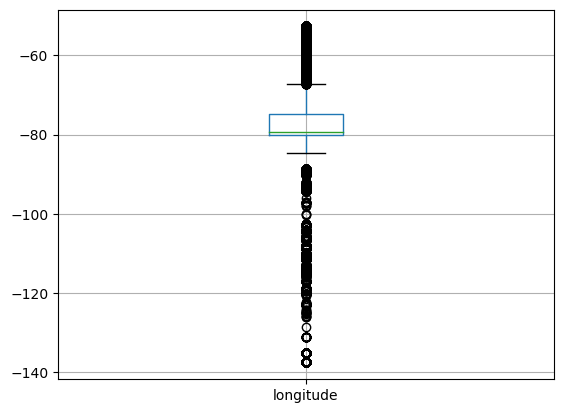

In [55]:
# let's look at box and whisker plot
insurance_train_data.boxplot(column = col);

Doesn't look like there are major outliers.

In [56]:
# looking at COMMUTE_DISTANCE
col = outlier_features[next(j)][0]
print(col)

COMMUTE_DISTANCE


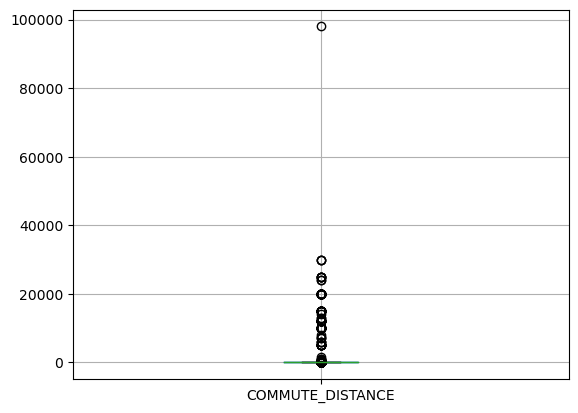

In [57]:
# let's look at box and whisker plot
insurance_train_data.boxplot(column = col);

Looks like there are some major outliers.

In [58]:
# sorting the dataset in descending values of commute distance
insurance_train_data.sort_values(by=[col],ascending=False)

QUOTEDATE  VEHICLEYEAR     VEHICLEMAKE              VEHICLEMODEL  \
18895  2016-04-08         2015  FORD TRUCK/VAN     F150 XL SUPERCREW 4WD   
13663  2016-03-22         2002            AUDI     ALLROAD QUATTRO WAGON   
38057  2016-05-30         2008      VOLKSWAGEN  RABBIT 2.5 2DR HATCHBACK   
93038  2016-11-17         2009           HONDA            CIVIC DX-G 4DR   
82660  2016-10-12         2007       CHEVROLET          IMPALA LS V6 4DR   
...           ...          ...             ...                       ...   
101881 2016-12-30         2010           MAZDA             MAZDA6 GS 4DR   
101882 2016-12-30         1991           HONDA           ACCORD EX-R 4DR   
101883 2016-12-30         2005            JEEP              TJ SPORT 4WD   
101885 2016-12-30         2002        CHRYSLER              INTREPID 4DR   
101887 2016-12-30         2004           HONDA              CIVIC EX 4DR   

        ANNUAL_KM  COMMUTE_DISTANCE VEHICLE_OWNERSHIP  VEHICLE_VALUE  \
18895      9800.0           98000.0             Owned            NaN   
13663        20.0           30000.0               NaN         5000.0   
38057        10.0           30000.0               NaN            NaN   
93038        30.0           30000.0               NaN            NaN   
82660         0.0           25000.0               NaN            NaN   
...           ...               ...               ...            ...   
101881    20000.0               NaN               NaN            NaN   
101882    10000.0               NaN               NaN            NaN   
101883     8000.0               NaN             Owned        20000.0   
101885    10000.0               NaN               NaN            NaN   
101887    10000.0               NaN               NaN            NaN   

       VEHICLEUSE  GENDER  ...          OCCUPATION  \
18895    Pleasure    Male  ...           Not Known   
13663     Commute    Male  ...           Not Known   
38057     Commute    Male  ...  Professional/Other   
93038     Commute  Female  ...           Not Known   
82660     Commute  Female  ...           Not Known   
...           ...     ...  ...                 ...   
101881   Pleasure  Female  ...           Not Known   
101882   Pleasure  Female  ...           Not Known   
101883   Pleasure  Female  ...        Labour/Plant   
101885   Pleasure  Female  ...           Not Known   
101887   Pleasure    Male  ...           Not Known   

       CONVICTION_COUNT_MINOR_3YRS CONVICTION_COUNT_MAJOR_3YRS  \
18895                            0                           0   
13663                            2                           0   
38057                            0                           0   
93038                            0                           0   
82660                            0                           0   
...                            ...                         ...   
101881                           0                           0   
101882                           0                           0   
101883                           0                           0   
101885                           0                           0   
101887                           0                           0   

        CONVICTION_COUNT_CRIMINAL_3YRS  ASSIGNED_LOSSES_PD_5YRS  \
18895                                0                        0   
13663                                0                        1   
38057                                0                        0   
93038                                0                        0   
82660                                0                        0   
...                                ...                      ...   
101881                               0                        0   
101882                               0                        0   
101883                               0                        0   
101885                               0                        0   
101887                               0             

#### Key insight

**Daily commute distance cannot be greater than annual km. This could be a data entry error where the two numbers could have been swapped. Let's swap those columns where ANNUAL_KM is smaller than COMMUTE_DISTANCE.**

In [59]:
def swap_annual_km_commute(df):
    '''
    This function swaps ANNUAL_KM and COMMUTE_DISTANCE in cases where
    ANNUAL_KM < COMMUTE_DISTANCE.
    Args: df: dataframe
    Returns: df: df with correct ANNUAL_KM and COMMUTE_DISTANCE.
    '''    
    # iterating over rows in training set
    for index, row in df.iterrows():
        annual_km = row['ANNUAL_KM']
        commute_dist = row['COMMUTE_DISTANCE']
        if annual_km < commute_dist:
            # Swap the values of 'COMMUTE_DISTANCE' and 'ANNUAL_KM'
            df.at[index, 'COMMUTE_DISTANCE'] = annual_km
            df.at[index, 'ANNUAL_KM'] = commute_dist
    return df

In [60]:
insurance_train_data = swap_annual_km_commute(insurance_train_data)

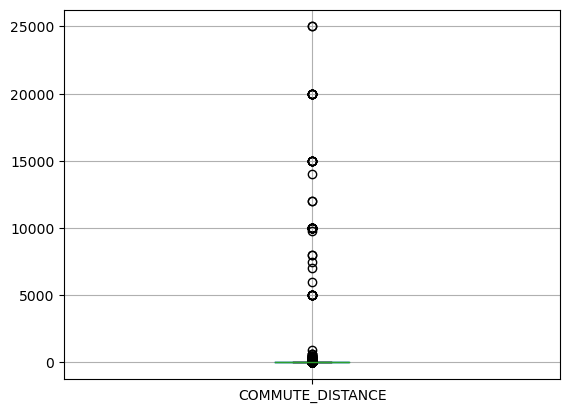

In [61]:
# looking at COMMUTE_DISTANCE distribution again
insurance_train_data.boxplot(column = col);

In [62]:
# looking at the dataset again with COMMUTE_DISTACNE >= 5000 
# since values above it seem to be extreme outliers.
outlier_df = insurance_train_data.loc[insurance_train_data[col] >= 5000]
print('number of outliers:', outlier_df.shape[0])
outlier_df.head()

number of outliers: 60


QUOTEDATE  VEHICLEYEAR          VEHICLEMAKE                VEHICLEMODEL  \
2007 2016-01-26         2014            CHEVROLET                CRUZE LS 4DR   
2186 2016-01-27         2013                  KIA                  RIO EX 4DR   
3484 2016-02-05         2003        GMC TRUCK/VAN      SONOMA SLS EXT CAB 2WD   
4987 2016-02-17         2008               TOYOTA                 YARIS S 4DR   
8532 2016-03-04         2004  CHEVROLET TRUCK/VAN  SILVERADO 1500 EXT CAB 4WD   

      ANNUAL_KM  COMMUTE_DISTANCE VEHICLE_OWNERSHIP  VEHICLE_VALUE VEHICLEUSE  \
2007    10000.0           10000.0               NaN            1.0   Pleasure   
2186    10000.0           10000.0               NaN            NaN   Pleasure   
3484     5000.0            5000.0               NaN         5000.0   Pleasure   
4987    20000.0           20000.0               NaN            NaN   Pleasure   
8532    10000.0           10000.0               NaN            NaN   Pleasure   

     GENDER  ...  OCCUPATION CONVICTION_COUNT_MINOR_3YRS  \
2007   Male  ...   Not Known                           0   
2186   Male  ...   Not Known                           0   
3484   Male  ...   Not Known                           0   
4987   Male  ...   Not Known                           0   
8532   Male  ...   Not Known                           0   

     CONVICTION_COUNT_MAJOR_3YRS  CONVICTION_COUNT_CRIMINAL_3YRS  \
2007                           0                               0   
2186                           0                               0   
3484                           0                               0   
4987                           0                               0   
8532                           0                               0   

      ASSIGNED_LOSSES_PD_5YRS SUSPENSION_COUNT IS_BOUND latitude  longitude  \
2007                        1                0        0  44.6573   -75.7146   
2186                        0                0        0  43.6655   -79.4378   
3484                        0                0        0  45.9188   -64.3845   
4987                        0                0        0  46.2538   -60.3566   
8532                        0                0        0  48.1666   -53.9648   

                 location  
2007  (44.6573, -75.7146)  
2186  (43.6655, -79.4378)  
3484  (45.9188, -64.3845)  
4987  (46.2538, -60.3566)  
8532  (48.1666, -53.9648)  

[5 rows x 27 columns]

#### Key insight

**It seems like there are still suspicious entries with ANNUAL_KM same as COMMUTE_DISTANCE. Since there are only 60 such records, let's drop these entries.**

In [63]:
# dropping commute distance outliers
insurance_train_data.drop(index=outlier_df.index, inplace = True)

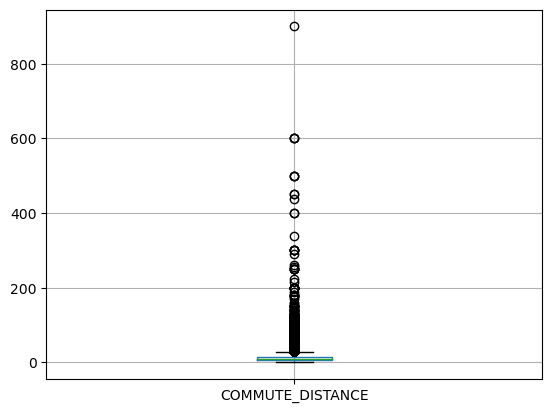

In [64]:
# looking at the distribution of commute distance again
insurance_train_data.boxplot(column = col);

In [65]:
# looking at Latitude
col = outlier_features[next(j)][0]
print(col)

latitude


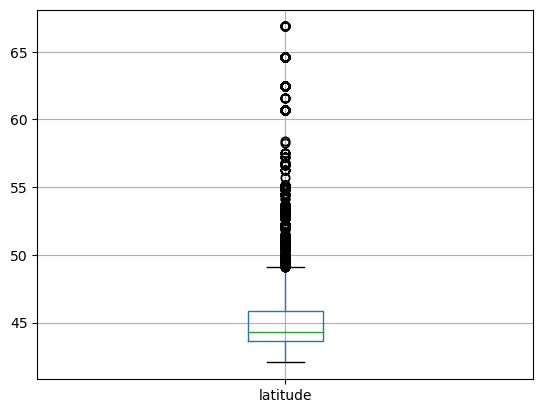

In [66]:
insurance_train_data.boxplot(column = col);

In [67]:
# looking at VEHICLEYEAR
col = outlier_features[next(j)][0]
print(col)

VEHICLEYEAR


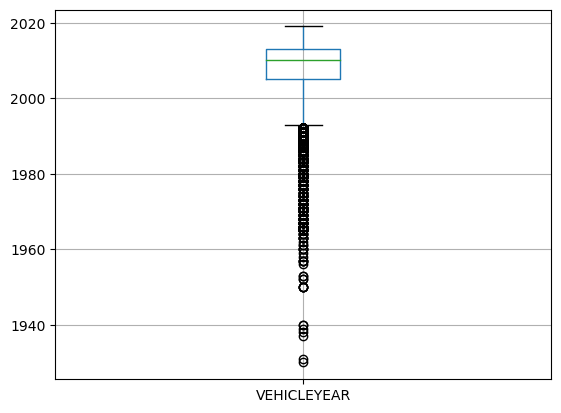

In [68]:
insurance_train_data.boxplot(column = col);

Looking at rows with vehicle year before 1940

In [69]:
# arrange dataset by vehicle year in ascending order
insurance_train_data.sort_values(by=[col],ascending=True)

QUOTEDATE  VEHICLEYEAR        VEHICLEMAKE                 VEHICLEMODEL  \
44342 2016-06-15         1930           CHRYSLER                    SEDAN 4DR   
22677 2016-04-18         1931               FORD                      MODEL A   
4909  2016-02-17         1937         OLDSMOBILE                        SEDAN   
47502 2016-06-23         1938          CHEVROLET                        COUPE   
43347 2016-06-13         1939             JAGUAR                      REPLICA   
...          ...          ...                ...                          ...   
93474 2016-11-21         2017          CHEVROLET  CRUZE PREMIER 4DR HATCHBACK   
93481 2016-11-21         2017    HONDA TRUCK/VAN            CR-V EX-L 4DR AWD   
76158 2016-09-21         2017  HYUNDAI TRUCK/VAN       SANTA FE XL V6 4DR AWD   
14919 2016-03-28         2018      BMW TRUCK/VAN               X5 35I 4DR AWD   
82271 2016-10-12         2019         VOLKSWAGEN                JETTA GLI 4DR   

       ANNUAL_KM  COMMUTE_DISTANCE VEHICLE_OWNERSHIP  VEHICLE_VALUE  \
44342     3000.0               NaN               NaN        10000.0   
22677     2500.0               NaN               NaN         5000.0   
4909     10000.0               NaN               NaN            NaN   
47502     5000.0               NaN               NaN         9100.0   
43347     2000.0               NaN               NaN          500.0   
...          ...               ...               ...            ...   
93474    20000.0              11.0             Owned        22000.0   
93481    20000.0              10.0             Owned        20000.0   
76158    20000.0              10.0             Owned            NaN   
14919    20000.0               NaN               NaN       110000.0   
82271    25000.0              11.0               NaN            1.0   

      VEHICLEUSE  GENDER  ...     OCCUPATION CONVICTION_COUNT_MINOR_3YRS  \
44342   Pleasure    Male  ...      Not Known                           0   
22677   Pleasure    Male  ...      Not Known                           0   
4909    Pleasure  Female  ...      Not Known                           0   
47502   Pleasure    Male  ...        Retired                           0   
43347   Pleasure    Male  ...         Trades                           0   
...          ...     ...  ...            ...                         ...   
93474    Commute  Female  ...      Not Known                           1   
93481    Commute  Female  ...      Not Known                           0   
76158    Commute  Female  ...      Not Known                           0   
14919   Pleasure    Male  ...      Not Known                           0   
82271    Commute  Female  ...  Office/Stores                           0   

      CONVICTION_COUNT_MAJOR_3YRS  CONVICTION_COUNT_CRIMINAL_3YRS  \
44342                           0                               0   
22677                           0                               0   
4909                            0                               0   
47502                           0                               0   
43347                           0                               0   
...                           ...                             ...   
93474                           0                               0   
93481                           0                               0   
76158                           0                               0   
14919                           0                               0   
82271                           0                               0   

       ASSIGNED_LOSSES_PD_5YRS SUSPENSION_COUNT IS_BOUND latitude  longitude  \
44342                        0                0        0  43.6297   -80.0415   
22677                        0                0        1  44.8608   -79.5069   
4909                         0                0        0  44.9001   -76.2494   
47502                        0                0        1  44.0992   -77.5776   
43347                        0         

VEHICLEYEAR seems fine. Moving on.

In [70]:
# looking at ANNUAL_KM
col = outlier_features[next(j)][0]
print(col)

ANNUAL_KM


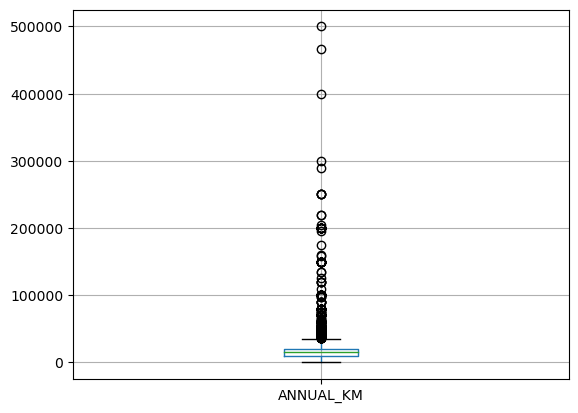

In [71]:
insurance_train_data.boxplot(column = col);

In [72]:
# arranging data in descending order of annual km
insurance_train_data.sort_values(by=[col],ascending=False)

QUOTEDATE  VEHICLEYEAR          VEHICLEMAKE  \
2735  2016-02-01         2016    HYUNDAI TRUCK/VAN   
34754 2016-05-19         2013  DODGE/RAM TRUCK/VAN   
53351 2016-07-13         2007               NISSAN   
54108 2016-07-14         2014               TOYOTA   
86016 2016-10-24         1997                ACURA   
...          ...          ...                  ...   
76832 2016-09-22         2013             CHRYSLER   
70434 2016-09-02         1979                 FORD   
4628  2016-02-15         2007    PONTIAC TRUCK/VAN   
73631 2016-09-14         2000             CHRYSLER   
94545 2016-11-23         2012                HONDA   

                      VEHICLEMODEL  ANNUAL_KM  COMMUTE_DISTANCE  \
2735   SANTA FE SPORT 2.0T 4DR AWD   500000.0              20.0   
34754  RAM 1500 SPORT CREW CAB 4WD   466000.0              50.0   
53351              VERSA 1.8 S 5DR   400000.0               NaN   
54108                         RAV4   300000.0              20.0   
86016                    3.0CL 2DR   290000.0               NaN   
...                            ...        ...               ...   
76832                 200 S V6 4DR        0.0               0.0   
70434                        F 250        0.0               NaN   
4628               MONTANA SV6 EXT        0.0               NaN   
73631                   PT CRUISER        0.0               NaN   
94545                 CIVIC LX 4DR        NaN              15.0   

      VEHICLE_OWNERSHIP  VEHICLE_VALUE VEHICLEUSE  GENDER  ...  OCCUPATION  \
2735              Owned            NaN    Commute    Male  ...   Not Known   
34754             Owned        42000.0    Commute    Male  ...   Not Known   
53351               NaN         8000.0   Business    Male  ...   Not Known   
54108               NaN        25000.0    Commute    Male  ...   Not Known   
86016               NaN            NaN   Pleasure    Male  ...   Not Known   
...                 ...            ...        ...     ...  ...         ...   
76832               NaN            NaN    Commute  Female  ...    Military   
70434             Owned         2000.0   Pleasure    Male  ...   Not Known   
4628                NaN        20000.0   Pleasure  Female  ...   Not Known   
73631             Owned        20000.0   Pleasure  Female  ...   Not Known   
94545               NaN            NaN    Commute  Female  ...   Not Known   

      CONVICTION_COUNT_MINOR_3YRS CONVICTION_COUNT_MAJOR_3YRS  \
2735                            0                           0   
34754                           0                           0   
53351                           0                           0   
54108                           1                           0   
86016                           0                           0   
...                           ...                         ...   
76832                           0                           0   
70434                           0                           0   
4628                            0                           0   
73631                           0                           0   
94545                           0                           0   

       CONVICTION_COUNT_CRIMINAL_3YRS  ASSIGNED_LOSSES_PD_5YRS  \
2735                                0                        0   
34754                               0                        0   
53351                               0                        0   
54108                               1                        0   
86016                               0                        0   
...                               ...                      ...   
76832                               0                        0   
70434                               0                        0   
4628                                0                        0   
73631                               0                        0   
94545                               0                        0   

      SUSPENSION_COUNT IS_BOUND latitude  

#### Key insight

**Six figure ANNUAL_KM seems like a data entry error. An average annual km limit on a leased vehicle is 24,000 km. Therefore 500,000 km annually is highly unkilely. Let's divide these values by 10 assuming these values are data entry errors to bring them to a more believable range.**

In [73]:
def annual_km_above_threshold(df, threshold = 100000):
    '''
    This function returns corrected ANNUAL_KM for values over 100000 km by 
    dividing them by 10. Assumption here is that this could be a data entry 
    error.
    Args: df: dataframe
    threshold: value over which ANNUAL_KM is corrected
    Return: df: dataframe with ANNUAL_KM corrected value
    '''
    # iterating over rows in training data
    for index, row in df.iterrows():
        annual_km = row[col]
        # Check if the annual mileage is greater than or equal to 100,000
        if annual_km >= threshold:
            # Reduce the annual mileage by dividing it by 10
            df.at[index, col] = annual_km/10.
    return df

In [74]:
insurance_train_data = annual_km_above_threshold(insurance_train_data)

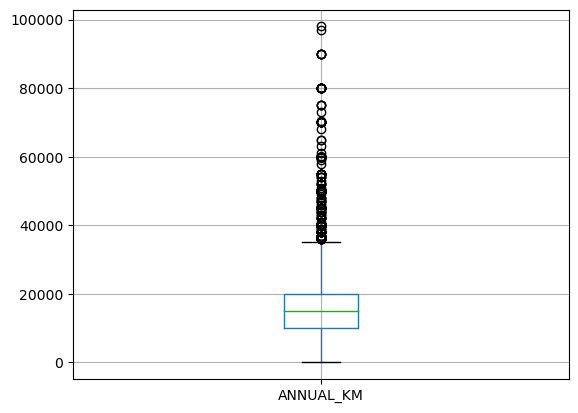

In [75]:
# checking boxplot of annual km again
insurance_train_data.boxplot(column = col);

In [76]:
# looking at VEHICLE_VALUE
col = outlier_features[next(j)][0]
print(col)

VEHICLE_VALUE


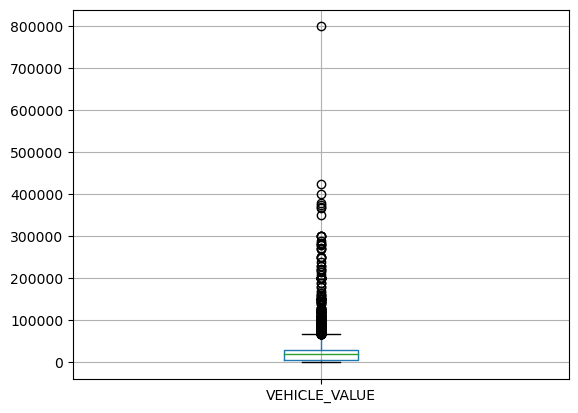

In [77]:
insurance_train_data.boxplot(column = col);

In [78]:
# arranging dataset by decreasing vehicle value
insurance_train_data.sort_values(by=[col],ascending=False)

QUOTEDATE  VEHICLEYEAR        VEHICLEMAKE  \
95096  2016-11-25         2016        LAMBORGHINI   
89719  2016-11-05         2017            FERRARI   
98277  2016-12-08         2005     FORD TRUCK/VAN   
68303  2016-08-29         2015            MCLAREN   
94655  2016-11-24         2017  BENTLEY TRUCK/VAN   
...           ...          ...                ...   
101881 2016-12-30         2010              MAZDA   
101882 2016-12-30         1991              HONDA   
101885 2016-12-30         2002           CHRYSLER   
101887 2016-12-30         2004              HONDA   
101890 2016-12-30         2010      GMC TRUCK/VAN   

                                    VEHICLEMODEL  ANNUAL_KM  COMMUTE_DISTANCE  \
95096   AVENTADOR LP750 SUPERVELOCE ROADSTER AWD     5000.0               NaN   
89719                                488 GTB 2DR    20000.0              15.0   
98277                F250 SD LARIAT SUPERCAB 4WD    10000.0              10.0   
68303                                650S SPIDER    10000.0               NaN   
94655                       BENTAYGA W12 4DR AWD    10000.0               NaN   
...                                          ...        ...               ...   
101881                             MAZDA6 GS 4DR    20000.0               NaN   
101882                           ACCORD EX-R 4DR    10000.0               NaN   
101885                              INTREPID 4DR    10000.0               NaN   
101887                              CIVIC EX 4DR    10000.0               NaN   
101890                     CANYON SL REG CAB 4WD    10000.0              15.0   

       VEHICLE_OWNERSHIP  VEHICLE_VALUE VEHICLEUSE  GENDER  ...  OCCUPATION  \
95096                NaN       800000.0   Pleasure  Female  ...   Not Known   
89719              Owned       425000.0    Commute    Male  ...   Not Known   
98277                NaN       400000.0    Commute    Male  ...   Not Known   
68303              Owned       380000.0   Pleasure    Male  ...   Not Known   
94655              Owned       374725.0   Pleasure    Male  ...   Not Known   
...                  ...            ...        ...     ...  ...         ...   
101881               NaN            NaN   Pleasure  Female  ...   Not Known   
101882               NaN            NaN   Pleasure  Female  ...   Not Known   
101885               NaN            NaN   Pleasure  Female  ...   Not Known   
101887               NaN            NaN   Pleasure    Male  ...   Not Known   
101890               NaN            NaN   Business    Male  ...   Not Known   

       CONVICTION_COUNT_MINOR_3YRS CONVICTION_COUNT_MAJOR_3YRS  \
95096                            0                           0   
89719                            1                           0   
98277                            0                           0   
68303                            0                           0   
94655                            1                           0   
...                            ...                         ...   
101881                           0                           0   
101882                           0                           0   
101885                           0                           0   
101887                           0                           0   
101890                           0                           0   

        CONVICTION_COUNT_CRIMINAL_3YRS  ASSIGNED_LOSSES_PD_5YRS  \
95096                                0                        0   
89719                                0                        0   
98277                                1                        0   
68303                                0                        0   
94655                                0                        0   
...                                ...                      ...   
101881                               0                        0   
101882                               0                        0   
101885                               0               

$800k for LAMBORGHINI sounds reasonable. Let's keep it.

In [79]:
# looking at years licenced
col = outlier_features[next(j)][0]
print(col)

YEARS_LICENSED


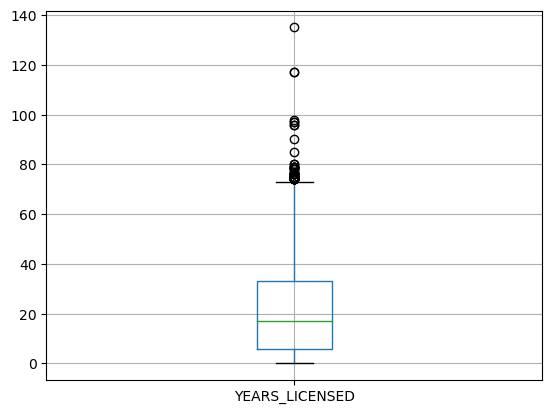

In [80]:
insurance_train_data.boxplot(column = col);

Rows with 100 years or more of years licenced seem suspicious. Let's take a closer look.

In [81]:
insurance_train_data.loc[insurance_train_data[col] > 100].T

24380                27694  \
QUOTEDATE                       2016-04-22 00:00:00  2016-05-02 00:00:00   
VEHICLEYEAR                                    2016                 2016   
VEHICLEMAKE                                  NISSAN               NISSAN   
VEHICLEMODEL                      SENTRA 1.8 SV 4DR    SENTRA 1.8 SV 4DR   
ANNUAL_KM                                   20000.0              25000.0   
COMMUTE_DISTANCE                               25.0                 25.0   
VEHICLE_OWNERSHIP                             Owned                  NaN   
VEHICLE_VALUE                               22000.0              22000.0   
VEHICLEUSE                                  Commute              Commute   
GENDER                                       Female               Female   
YEAR_OF_BIRTH                                  1990                 1990   
POSTAL_CODE                                     K4K                  K4K   
AREA_CODE                                       613                  613   
YEARS_LICENSED                                117.0                117.0   
YEARS_AS_PRINCIPAL_DRIVER                       NaN                  NaN   
MULTI_PRODUCT                                   Yes                   No   
MARITAL_STATUS                               Single               Single   
OCCUPATION                                Not Known            Not Known   
CONVICTION_COUNT_MINOR_3YRS                       0                    0   
CONVICTION_COUNT_MAJOR_3YRS                       0                    0   
CONVICTION_COUNT_CRIMINAL_3YRS                    0                    0   
ASSIGNED_LOSSES_PD_5YRS                           0                    0   
SUSPENSION_COUNT                                  0                    0   
IS_BOUND                                          0                    0   
latitude                                    45.5501              45.5501   
longitude                                   -75.291              -75.291   
location                         (45.5501, -75.291)   (45.5501, -75.291)   

                                              96374  
QUOTEDATE                       2016-12-01 00:00:00  
VEHICLEYEAR                                    2013  
VEHICLEMAKE                                  SUZUKI  
VEHICLEMODEL                             SX4 JX 5DR  
ANNUAL_KM                                   15000.0  
COMMUTE_DISTANCE                               15.0  
VEHICLE_OWNERSHIP                             Owned  
VEHICLE_VALUE                               23000.0  
VEHICLEUSE                                  Commute  
GENDER                                         Male  
YEAR_OF_BIRTH                                  1959  
POSTAL_CODE                                     L7A  
AREA_CODE                                       905  
YEARS_LICENSED                                135.0  
YEARS_AS_PRINCIPAL_DRIVER                       NaN  
MULTI_PRODUCT                                   Yes  
MARITAL_STATUS                              Married  
OCCUPATION                                Not Known  
CONVICTION_COUNT_MINOR_3YRS                       0  
CONVICTION_COUNT_MAJOR_3YRS                       0  
CONVICTION_COUNT_CRIMINAL_3YRS                    0  
ASSIGNED_LOSSES_PD_5YRS                           0  
SUSPENSION_COUNT                                  0  
IS_BOUND                                          0  
latitude                                    43.6909  
longitude                                  -79.8377  
location                        (43.6909, -79.8377)

In [82]:
def years_licenced(df):
    '''
    This function replaces outliers with YEARS_LICENSED = 135 with 35 and 117 
    with 11 assuming it could be a data entry error.
    Args: df: dataframe
    Returns: corrected dataframe
    '''
    df.loc[df['YEARS_LICENSED'] == 135., 'YEARS_LICENSED'] = 35.
    df.loc[df['YEARS_LICENSED'] == 117., 'YEARS_LICENSED'] = 11.
    
    return df

In [83]:
insurance_train_data = years_licenced(insurance_train_data)

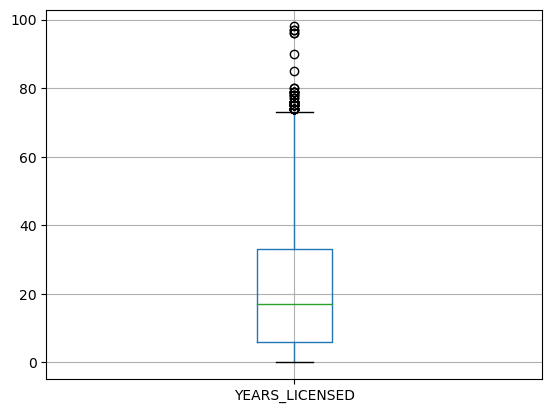

In [84]:
insurance_train_data.boxplot(column = col);

## COLUMNS WITH MISSING VALUES

In [85]:
columns_with_missing_vals = [col for col in columns_with_missing_vals if col in insurance_train_data.columns.values]

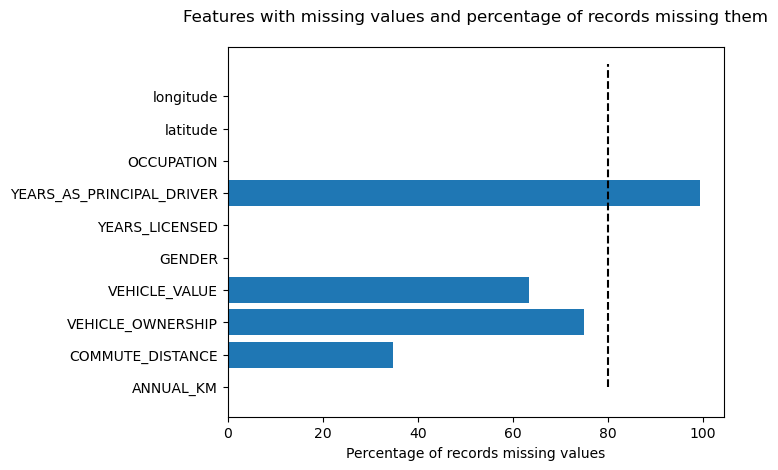

In [86]:
# After identifying the columns with missing values we will plot a bar graph to see the percent of missing values in each column.
columns_with_missing_vals_percentage = [100*insurance_train_data[col].isna().sum()/insurance_train_data.shape[0] for col in columns_with_missing_vals]
plt.barh([col for col in columns_with_missing_vals], columns_with_missing_vals_percentage)
plt.vlines(80,0,len(columns_with_missing_vals), ls = '--', color = 'black')
plt.xlabel('Percentage of records missing values')
plt.title('Features with missing values and percentage of records missing them\n');

In [87]:
# As evident in the plot above YEARS_AS_PRINCIPAL_DRIVER has almost 100 percent missing values so we will drop this column.
dropped_columns = ['YEARS_AS_PRINCIPAL_DRIVER']
insurance_train_data.drop(columns=dropped_columns, inplace=True)
print('shape of train data: ', insurance_train_data.shape)

shape of train data:  (101831, 26)


In [88]:
# recounting columns with missing values
columns_with_missing_vals = missing_values(insurance_train_data)
columns_with_missing_vals

['ANNUAL_KM',
 'COMMUTE_DISTANCE',
 'VEHICLE_OWNERSHIP',
 'VEHICLE_VALUE',
 'GENDER',
 'YEARS_LICENSED',
 'OCCUPATION',
 'latitude',
 'longitude']

In [91]:
# Again we will explore columns with missing values one by one as we did for columns with no missing values
j = iter(range(len(columns_with_missing_vals)))

In [92]:
# First is ANNUAL_KM
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_train_data[col].isna().sum()}')
insurance_train_data[col].describe()

missing values in ANNUAL_KM: 1


count    101830.000000
mean      14817.302878
std        6825.090884
min           0.000000
25%       10000.000000
50%       15000.000000
75%       20000.000000
max       98000.000000
Name: ANNUAL_KM, dtype: float64

In [94]:
def impute_annual_km(df, median_annual_km, threshold_annual_km = 1000):
    '''
    This function replaces the missing annual km values and values below 
    threshold with the median value.
    Args: df: dataframe,
    median_annual_km: median annual km value (value to be replaced), 
    threshold_annual_km: minimum value below which annual km will be replaced 
    by median value.
    Returns: Updated dataframe
    '''
    df.loc[df[col] != df[col], col] = median_annual_km
    df.loc[df[col] <= threshold_annual_km, col] = median_annual_km
# asserting length of ANNUAL_KM column is same as the rest of the dataset
    return df

In [95]:
median_annual_km = insurance_train_data[col].median()
print(f'median ANNUAL KM: {median_annual_km}')
insurance_train_data = impute_annual_km(insurance_train_data, median_annual_km)

median ANNUAL KM: 15000.0


In [96]:
assert len(insurance_train_data[col]) == insurance_train_data.shape[0]

In [97]:
print(f'missing values in {col}: {insurance_train_data[col].isna().sum()}')
insurance_train_data[col].describe()

missing values in ANNUAL_KM: 0


count    101831.000000
mean      15009.110704
std        6619.516274
min        1100.000000
25%       10000.000000
50%       15000.000000
75%       20000.000000
max       98000.000000
Name: ANNUAL_KM, dtype: float64

In [98]:
# Next is COMMUTE_DISTANCE
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_train_data[col].isna().sum()}')
insurance_train_data[col].describe()

missing values in COMMUTE_DISTANCE: 35413


count    66418.000000
mean        14.232121
std         15.296413
min          0.000000
25%          7.000000
50%         10.000000
75%         16.000000
max        900.000000
Name: COMMUTE_DISTANCE, dtype: float64

In [100]:
def impute_commute_distance(df, median_commute_dist, threshold_commute_dist = 0):
    '''
    This function replaces the missing commute distance values and values 
    below a threshold with the median value.
    Args: df: dataframe,
    median_commute_dist: median commute distance value (value to be replaced), 
    threshold_annual_km: minimum value below which commute distance will be 
    replaced by the median value.
    Returns: Updated dataframe    
    '''
    df.loc[df[col] != df[col], col] = median_commute_dist
    df.loc[df[col] == threshold_commute_dist, col] = median_commute_dist
    
    return df

In [101]:
median_commute_dist = insurance_train_data[col].median()
print(f'median COMMUTE DISTANCE: {median_commute_dist}')
insurance_train_data = impute_commute_distance(insurance_train_data, median_commute_dist)

median COMMUTE DISTANCE: 10.0


In [102]:
# asserting length of COMMUTE_DISTANCE column is same as the rest of the dataset
assert len(insurance_train_data[col]) == insurance_train_data.shape[0]

In [103]:
print(f'missing values in {col}: {insurance_train_data[col].isna().sum()}')
insurance_train_data[col].describe()

missing values in COMMUTE_DISTANCE: 0


count    101831.000000
mean         12.829973
std          12.473454
min           1.000000
25%          10.000000
50%          10.000000
75%          15.000000
max         900.000000
Name: COMMUTE_DISTANCE, dtype: float64

In [104]:
# Next is VEHICLE_OWNERSHIP
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_train_data[col].isna().sum()}')
Counter(insurance_train_data[col])

missing values in VEHICLE_OWNERSHIP: 76399


Counter({nan: 76399, 'Owned': 22982, 'Leased': 2346, 'Non-owned': 104})

In [105]:
most_freq_ownership = 'Owned'

In [106]:
# Replace the missing values with the most frequent ownership which is owned in this case
insurance_train_data.loc[insurance_train_data[col] != insurance_train_data[col], col] = most_freq_ownership
Counter(insurance_train_data[col])

Counter({'Owned': 99381, 'Leased': 2346, 'Non-owned': 104})

In [108]:
# VEHICLE_VALUE
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_train_data[col].isna().sum()}')
insurance_train_data[col].describe()

missing values in VEHICLE_VALUE: 64635


count     37196.000000
mean      20742.666470
std       19468.120841
min           0.000000
25%        5000.000000
50%       20000.000000
75%       30000.000000
max      800000.000000
Name: VEHICLE_VALUE, dtype: float64

#### VEHICLE VALUE

**To address the missing vehicle values, we utilized information from the Vehicle Year, Vehicle Value, and Vehicle Make columns. Our approach involved creating a list for each of these combinations and calculating the average price for a vehicle in each category. For instance, we calculated the average cost of a 1952 Pontiac from examples where the information was available. If an example with such a vehicle had a missing vehicle value, we replaced the missing value with the average value of a 1952 Pontiac.**

In [109]:
# Count the occurrences of each unique value in the vehicle value column of the training data 
vehicle_val_dict = Counter(insurance_train_data.loc[insurance_train_data[col] == insurance_train_data[col]][col])

# Sort the unique values in the 'col' column of the insurance_train_data DataFrame
vehicle_val_dict_sorted = sorted(Counter(insurance_train_data.loc[insurance_train_data[col] == insurance_train_data[col]][col]))

In [110]:
# In this code block we will use the Vehicle year and Vehicle make entries to compare it's relationship with the vehicle value entries

# Create an empty dictionary to store vehicle values
vehicle_value_dict = {}

# Iterate through each row in the training data
for index, row in insurance_train_data.iterrows():
    # Get the vehicle year from the current row
    vehicle_year = row['VEHICLEYEAR']
    # Get the vehicle make from the current row
    vehicle_make = row['VEHICLEMAKE']
    # Get the vehicle value from the current row
    vehicle_value = row['VEHICLE_VALUE']
    # Check if the vehicle value is valid
    if vehicle_value > 1. and vehicle_value == vehicle_value:
        # Check if the vehicle year and make combination is not already in the dictionary
        if (vehicle_year, vehicle_make) not in vehicle_value_dict:
            # If not, add a new key-value pair with the vehicle year and make as the key and the vehicle value as the value
            vehicle_value_dict[(vehicle_year, vehicle_make)] = [vehicle_value]
        else:
            # If the key already exists, append the vehicle value to the existing list of values
            vehicle_value_dict[(vehicle_year, vehicle_make)].append(vehicle_value)

In [111]:
# Finally, we will calculate the average vehicle value for each combination of vehicle make and vehicle year and use that information to impute the missing values
vehicle_avg_value_dict = {}
for key in vehicle_value_dict.keys():
    vehicle_avg_value_dict[key] = np.mean(vehicle_value_dict[key])

In [112]:
# for those entries whose vehicle value can't be discerned from the vehicle make and year,
# we'll use the median vehicle value from the dataset
median_freq_vehicle_value = np.median(insurance_train_data.loc[(insurance_train_data['VEHICLE_VALUE'] > 1.) & (insurance_train_data['VEHICLE_VALUE'] == insurance_train_data['VEHICLE_VALUE'])]['VEHICLE_VALUE'].values)
print('median vehicle value =', round(median_freq_vehicle_value))

median vehicle value = 23000


In [113]:
def impute_vehicle_value(df, vehicle_avg_value_dict, median_vehicle_value):
    '''
    This fucntion uses the average vehicle value based on year and make and 
    median vehicle value of the dataset (for cases where the year and make 
    info is missing) to impute missing values of vehicle value.
    Args: df: dataframe,
    vehicle_avg_value_dict: dictionary containing (vehicle make, year) as key 
    and average vehicle value as value.
    median_vehicle_value: median vehicle value. 
    Returns: Updated dataframe
    '''
    for index, row in df.iterrows():
        # Check if the vehicle value is less than or equal to 1 or if it is NaN
        if row['VEHICLE_VALUE'] <= 1. or row['VEHICLE_VALUE'] != row['VEHICLE_VALUE']:
            # Get the vehicle year from the current row
            vehicle_year = row['VEHICLEYEAR']
            # Get the vehicle make from the current row
            vehicle_make = row['VEHICLEMAKE']
            # Check if the combination of vehicle year and make exists in the vehicle_avg_value_dict
            if (vehicle_year, vehicle_make) in vehicle_avg_value_dict.keys():
                df.at[index, 'VEHICLE_VALUE'] = vehicle_avg_value_dict[(vehicle_year, vehicle_make)]
            # If the combination does not exist, assign the median frequency vehicle value
            else:
                df.at[index, 'VEHICLE_VALUE'] = median_vehicle_value
                
    return df

In [114]:
insurance_train_data = impute_vehicle_value(insurance_train_data, vehicle_avg_value_dict, median_freq_vehicle_value)

In [115]:
# Ensuring that the total number of entries remain unchanged after the impute operation in the previous step
assert len(insurance_train_data[col]) == insurance_train_data.shape[0]

In [116]:
# Next is gender. There are 5 missing values and 1 unknown value
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_train_data[col].isna().sum()}')
Counter(insurance_train_data[col])

missing values in GENDER: 5


Counter({'Male': 57064, 'Female': 44761, nan: 5, 'Unknown': 1})

In [117]:
# Replace the NaN and unknown values with Male as it's the most common entry
insurance_train_data.loc[(insurance_train_data[col] == "Unknown") |(insurance_train_data[col] != insurance_train_data[col]), col] = 'Male'
Counter(insurance_train_data['GENDER'])

Counter({'Male': 57070, 'Female': 44761})

In [118]:
# Check the YEARS_LICENSED
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_train_data[col].isna().sum()}')
insurance_train_data[col].describe()

missing values in YEARS_LICENSED: 8


count    101823.000000
mean         20.742868
std          16.241976
min           0.000000
25%           6.000000
50%          17.000000
75%          33.000000
max          98.000000
Name: YEARS_LICENSED, dtype: float64

#### YEARS LICENCED

**To address the missing years licenced values, we initially examined whether the 'years_licensed' column displayed any linear relationship with the year of birth. To evaluate this, we calculated the Pearson's correlation coefficient (Pearson r = 0.87) and noted a strong linear relationship between the two. Utilizing this information, we performed a linear regression analysis to predict the missing values in the years licenced column based on the observed correlation with year of birth.**

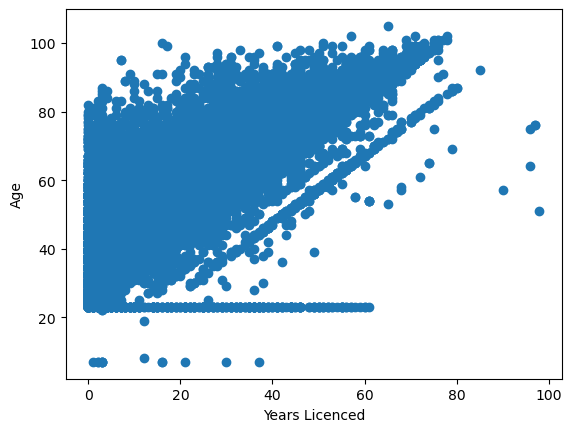

In [119]:
# Plot the age vs years licenced of the individuals requesting the quote
plt.scatter(insurance_train_data[col], [2023 - ent for ent in insurance_train_data['YEAR_OF_BIRTH'].values])
plt.xlabel('Years Licenced')
plt.ylabel('Age');

In [120]:
# Check to see if there is a linear relationship between the years licensed and the year of birth.
# Extracting the years licensed from the insurance train data
years_licensed = insurance_train_data[insurance_train_data[col] == insurance_train_data[col]][col].values

# Calculating the year of birth by subtracting the age from the current year
year_of_birth = [2023 - ent for ent in insurance_train_data.loc[insurance_train_data[col] == insurance_train_data[col]]['YEAR_OF_BIRTH'].values]

# Calculating the Pearson correlation coefficient between years licensed and year of birth
pearsonr(years_licensed, year_of_birth)

PearsonRResult(statistic=0.8696447897070941, pvalue=0.0)

In [121]:
# Based on the Pearson correlation coefficient r value of 0.87 it shows a positive linear relationship between years licensed and year of birth.
# We will use this information to fit a linear regression model between the two and use the model to predict the years licensed values
X = np.array(year_of_birth).reshape(-1,1)
y = np.array(years_licensed).reshape(-1,1)
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [122]:
def impute_year_of_birth(df):
    '''
    This function uses the linear model trained to predict years licenced from 
    year of birth to replace the missing YEAR_OF_BIRTH values with the 
    predicted values.
    Args: df: dataframe with missing values
    Returns: df: dataframe with no missing values
    '''
    # iterating over rows in dataset
    for index, row in df.iterrows():
        # if years licenced is NaN
        if row[col] != row[col]:
            # predict years licenced using age
            pred = lin_reg.predict([[2023 - row['YEAR_OF_BIRTH']]])
            df.at[index, col] = int(pred[0][0])
    return df

In [123]:
insurance_train_data = impute_year_of_birth(insurance_train_data)

In [124]:
print(f'missing values in {col}: {insurance_train_data[col].isna().sum()}')
insurance_train_data[col].describe()

missing values in YEARS_LICENSED: 0


count    101831.000000
mean         20.742279
std          16.241717
min           0.000000
25%           6.000000
50%          17.000000
75%          33.000000
max          98.000000
Name: YEARS_LICENSED, dtype: float64

In [125]:
assert len(insurance_train_data[col]) == insurance_train_data.shape[0]

In [126]:
# Next up is OCCUPATION
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_train_data[col].isna().sum()}')
Counter(insurance_train_data[col])

missing values in OCCUPATION: 1


Counter({'Not Known': 91933,
         'Professional/Other': 1441,
         'Trades': 1370,
         'Retired': 1218,
         'Labour/Plant': 1117,
         'Office/Stores': 995,
         'Student': 631,
         'Service Work': 626,
         'Management/Administration': 512,
         'Homemaker': 493,
         'Sales': 359,
         'Farm/Fisher': 233,
         'Professional/Health': 232,
         'Unemployed': 189,
         'Government ': 159,
         'Professional/Social': 135,
         'Military': 106,
         'Insurance': 74,
         'Tradesman': 7,
         nan: 1})

In [127]:
# Replace missing values with Not Known as that's the most common entry
insurance_train_data.loc[insurance_train_data[col] != insurance_train_data[col], col] = 'Not Known'
Counter(insurance_train_data[col])

Counter({'Not Known': 91934,
         'Professional/Other': 1441,
         'Trades': 1370,
         'Retired': 1218,
         'Labour/Plant': 1117,
         'Office/Stores': 995,
         'Student': 631,
         'Service Work': 626,
         'Management/Administration': 512,
         'Homemaker': 493,
         'Sales': 359,
         'Farm/Fisher': 233,
         'Professional/Health': 232,
         'Unemployed': 189,
         'Government ': 159,
         'Professional/Social': 135,
         'Military': 106,
         'Insurance': 74,
         'Tradesman': 7})

In [128]:
# Next up is latitude
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_train_data[col].isna().sum()}')

missing values in latitude: 35


In [129]:
lat_long_nan_df = insurance_train_data.loc[insurance_train_data[col] != insurance_train_data[col]]
lat_long_nan_df.tail().T

94825                   97039  \
QUOTEDATE                       2016-11-24 00:00:00     2016-12-05 00:00:00   
VEHICLEYEAR                                    2005                    2007   
VEHICLEMAKE                        TOYOTA TRUCK/VAN         MAZDA TRUCK/VAN   
VEHICLEMODEL                           RAV4 4DR 4WD  B3000 CAB PLUS 4DR 2WD   
ANNUAL_KM                                   10000.0                 20000.0   
COMMUTE_DISTANCE                               10.0                    15.0   
VEHICLE_OWNERSHIP                             Owned                   Owned   
VEHICLE_VALUE                                6000.0                 20000.0   
VEHICLEUSE                                 Pleasure                 Commute   
GENDER                                         Male                    Male   
YEAR_OF_BIRTH                                  1992                    2000   
POSTAL_CODE                                     TN3                      UN   
AREA_CODE                                       780                     511   
YEARS_LICENSED                                  6.0                     0.0   
MULTI_PRODUCT                                   Yes                     Yes   
MARITAL_STATUS                               Single                  Single   
OCCUPATION                                Not Known               Not Known   
CONVICTION_COUNT_MINOR_3YRS                       0                       0   
CONVICTION_COUNT_MAJOR_3YRS                       0                       0   
CONVICTION_COUNT_CRIMINAL_3YRS                    0                       0   
ASSIGNED_LOSSES_PD_5YRS                           0                       0   
SUSPENSION_COUNT                                  0                       0   
IS_BOUND                                          1                       0   
latitude                                        NaN                     NaN   
longitude                                       NaN                     NaN   
location                                 (nan, nan)              (nan, nan)   

                                              98302                99337  \
QUOTEDATE                       2016-12-08 00:00:00  2016-12-14 00:00:00   
VEHICLEYEAR                                    2009                 2006   
VEHICLEMAKE                               CHEVROLET     NISSAN TRUCK/VAN   
VEHICLEMODEL                          COBALT LT 2DR   X-TRAIL SE 4DR AWD   
ANNUAL_KM                                   15000.0              10000.0   
COMMUTE_DISTANCE                               12.0                 10.0   
VEHICLE_OWNERSHIP                             Owned                Owned   
VEHICLE_VALUE                           16541.45977         20460.652174   
VEHICLEUSE                                  Commute             Pleasure   
GENDER                                       Female               Female   
YEAR_OF_BIRTH                                  1995                 1958   
POSTAL_CODE                                     A0W                  151   
AREA_CODE                                       709                  709   
YEARS_LICENSED                                  3.0                 40.0   
MULTI_PRODUCT                                   Yes                  Yes   
MARITAL_STATUS                               Single               Single   
OCCUPATION                                Not Known            Not Known   
CONVICTION_COUNT_MINOR_3YRS                       0                    0   
CONVICTION_COUNT_MAJOR_3YRS                       0                    0   
CONVICTION_COUNT_CRIMINAL_3YRS                    0                    0   
ASSIGNED_LOSSES_PD_5YRS                           0                    0   
SUSPENSION_COUNT                                  0                    0   
IS_BOUND                                          0                    1   
latitude                                        NaN                  NaN   
longitude   

**Let's impute the missing latitude values using area codes**

In [130]:
area_codes_df = pd.read_csv('ca-area-code-cities.csv',names=['area_code', 'city', 'province', 'country', 'latitude', 'longitude'])
area_codes_df.tail()

area_code           city province country  latitude  longitude
670        905        Welland  Ontario      CA  42.98342  -79.24958
671        905        Keswick  Ontario      CA  44.25011  -79.46632
672        905  Port Colborne  Ontario      CA  42.90012  -79.23288
673        905       Uxbridge  Ontario      CA  44.10012  -79.11628
674        905      Fort Erie  Ontario      CA  42.90012  -78.93286

In [131]:
# Create an empty dictionary to store area codes with their corresponding latitude and longitude
area_code_lat_long_dict = {}

# Get the list of area codes, latitudes, and longitudes from the area codes DataFrame
area_codes_list = area_codes_df['area_code'].values
latitudes_list = area_codes_df['latitude'].values
longitudes_list = area_codes_df['longitude'].values

# Iterate over the area_codes_list and store each area code with its latitude and longitude in the dictionary
for ind, area_code in enumerate(area_codes_list):
    # Check if the area code is not already in the dictionary
    if area_code not in area_code_lat_long_dict.keys():
        # Add the area code as the key and the corresponding latitude and longitude as the value
        area_code_lat_long_dict[area_code] = (latitudes_list[ind], longitudes_list[ind])

# Update the area_codes_list to contain only the unique area codes from the dictionary
area_codes_list = list(area_code_lat_long_dict.keys())        

In [132]:
def lat_long_impute_func(df):
    '''
    The function takes a DataFrame df as input and imputes missing latitude 
    and longitude values in the DataFrame based on their area codes.
    Args: df: dataframe with missing values.
    df: dataframe with no missing values.
    '''
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Check if the latitude value is missing
        if row['latitude'] != row['latitude']:
            # read area code for the row
            row_area_code = df.at[index, 'AREA_CODE']
            # If the area code is present in the dictionary, use the corresponding latitude and longitude values
            if row_area_code in area_code_lat_long_dict.keys():
                df.at[index, 'latitude'] = area_code_lat_long_dict[row_area_code][0]
                df.at[index, 'longitude'] = area_code_lat_long_dict[row_area_code][1]     
            else:
                # If the area code is not present in the dictionary, find the nearest area code and use its latitude and longitude values
                area_codes_sorted_ind = np.argsort([abs(area_code - row_area_code) for area_code in area_codes_list])
                nearest_area_code = area_codes_list[area_codes_sorted_ind[0]]
                df.at[index, 'latitude'] = area_code_lat_long_dict[nearest_area_code][0]
                df.at[index, 'longitude'] = area_code_lat_long_dict[nearest_area_code][1] 
                print('area code in data:', row_area_code, 'nearest area code:', nearest_area_code)
    return df

In [133]:
insurance_train_data = lat_long_impute_func(insurance_train_data)

area code in data: 511 nearest area code: 514
area code in data: 511 nearest area code: 514
area code in data: 862 nearest area code: 867
area code in data: 901 nearest area code: 902
area code in data: 40 nearest area code: 204
area code in data: 511 nearest area code: 514
area code in data: 50 nearest area code: 204
area code in data: 575 nearest area code: 579
area code in data: 231 nearest area code: 226
area code in data: 212 nearest area code: 204
area code in data: 313 nearest area code: 306
area code in data: 860 nearest area code: 867
area code in data: 511 nearest area code: 514
area code in data: 616 nearest area code: 613
area code in data: 231 nearest area code: 226
area code in data: 978 nearest area code: 905
area code in data: 511 nearest area code: 514
area code in data: 561 nearest area code: 579
area code in data: 511 nearest area code: 514
area code in data: 511 nearest area code: 514
area code in data: 919 nearest area code: 905


In [134]:
print(f'missing values in {col}: {insurance_train_data[col].isna().sum()}')

missing values in latitude: 0


In [135]:
# Check for the completion of the dataset
insurance_train_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 101831 entries, 0 to 101890
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   QUOTEDATE                       101831 non-null  datetime64[ns]
 1   VEHICLEYEAR                     101831 non-null  int64         
 2   VEHICLEMAKE                     101831 non-null  object        
 3   VEHICLEMODEL                    101831 non-null  object        
 4   ANNUAL_KM                       101831 non-null  float64       
 5   COMMUTE_DISTANCE                101831 non-null  float64       
 6   VEHICLE_OWNERSHIP               101831 non-null  object        
 7   VEHICLE_VALUE                   101831 non-null  float64       
 8   VEHICLEUSE                      101831 non-null  object        
 9   GENDER                          101831 non-null  object        
 10  YEAR_OF_BIRTH                   101831 non-null  int64       

In [136]:
# dropping location (lat, long) tuples
insurance_train_data.drop(columns=['location'], inplace=True)

### CATEGORICAL COLUMNS

In [137]:
# making list of columns containing strings/categories
string_columns = insurance_train_data.select_dtypes(include='O').columns.values

In [138]:
# looking at categorical columns
string_columns

array(['VEHICLEMAKE', 'VEHICLEMODEL', 'VEHICLE_OWNERSHIP', 'VEHICLEUSE',
       'GENDER', 'POSTAL_CODE', 'AREA_CODE', 'MULTI_PRODUCT',
       'MARITAL_STATUS', 'OCCUPATION'], dtype=object)

In [139]:
# Let's count the total number of categories in each feature
for col in string_columns:
    print('Number of categories in column', col, '=', len(Counter(insurance_train_data[col])))

Number of categories in column VEHICLEMAKE = 185
Number of categories in column VEHICLEMODEL = 5820
Number of categories in column VEHICLE_OWNERSHIP = 3
Number of categories in column VEHICLEUSE = 10
Number of categories in column GENDER = 2
Number of categories in column POSTAL_CODE = 1139
Number of categories in column AREA_CODE = 196
Number of categories in column MULTI_PRODUCT = 2
Number of categories in column MARITAL_STATUS = 5
Number of categories in column OCCUPATION = 19


#### Key insight

**Since VEHCILEMODEL have lots of categories, let's only consider those with 50 entries. For lesser categories, we can club the entries together as a 'rare' category. POSTAL_CODE and AREA_CODE can be dropped since we made 2 columns containing latitudes and longitudes.**

In [140]:
# dictionary containing vehicle models and counts 
vehicle_models_dict = Counter(insurance_train_data['VEHICLEMODEL'])

In [141]:
def reduced_vehicle_model_column(df):
    '''
    The function takes the dataframe df as input and returns a list of the top
    vehicle models.
    '''
    # Create an empty list to store the top vehicle models
    top_vehicle_models = []
    # Iterate through each row in the dataframe
    for index, row in df.iterrows():
        # Get the vehicle model from the current row
        vehicle_model = row['VEHICLEMODEL']
        # Check if the count of the vehicle model is greater than 50
        if vehicle_models_dict[vehicle_model] > 50:
            # If it is, add the vehicle model to the top vehicle models list
            top_vehicle_models.append(vehicle_model)
        else:
            # If it's not, add 'rare' to the top vehicle models list
            top_vehicle_models.append('rare')
    # Return the list of top vehicle models
    return top_vehicle_models

In [142]:
# We will append column named TOPVEHICLEMODELS. Original name will be used if the frequency of that model in the column is greater than
# 50 else it will be labelled 'rare'
top_vehicle_models = reduced_vehicle_model_column(insurance_train_data)

In [143]:
# Let's drop the original VEHICLEMODEL, AREA_CODE and POSTAL_CODE columns
insurance_train_data_reduced = insurance_train_data.drop(columns=['VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE'])
insurance_train_data_reduced.shape

(101831, 22)

In [144]:
insurance_train_data_reduced['TOPVEHICLEMODELS'] = top_vehicle_models

#### Key step

**All QUOTEDATES belong to year 2016. Therefore only month in the QUOTEDATEs are meaningful which are in numerical form. However, greater values of month don't necessarily imply that they play a greater role in whether customers buy the insurance. Let's extract month from QUOTEDATE and convert them to string.**

In [145]:
# Using the QUOTEDATE column we will extract the month values from the entries and create a new feature called months and drop the original column.
month = insurance_train_data_reduced['QUOTEDATE'].dt.month
insurance_train_data_reduced['MONTH'] = [str(val) for val in month.values]
insurance_train_data_reduced.drop(columns=['QUOTEDATE'],inplace=True)

### FEATURE IMPORTANCES

Let's perform statistical tests to examine features that distinguish between buyers and non-buyers the most. 

In [146]:
insurance_train_data_reduced.head()

VEHICLEYEAR          VEHICLEMAKE  ANNUAL_KM  COMMUTE_DISTANCE  \
0         2006           VOLKSWAGEN    10000.0              10.0   
1         2017              HYUNDAI    20000.0              10.0   
2         2015  CHEVROLET TRUCK/VAN    15000.0              10.0   
3         2010               TOYOTA    20000.0              20.0   
4         2013                HONDA    30000.0              30.0   

  VEHICLE_OWNERSHIP  VEHICLE_VALUE VEHICLEUSE GENDER  YEAR_OF_BIRTH  \
0             Owned    3000.000000   Pleasure   Male           1975   
1             Owned   27017.815126   Business   Male           1958   
2             Owned   39222.673611   Pleasure   Male           1960   
3             Owned   18757.525692    Commute   Male           1985   
4             Owned   23062.825243    Commute   Male           1982   

   YEARS_LICENSED  ... CONVICTION_COUNT_MINOR_3YRS  \
0            25.0  ...                           0   
1            10.0  ...                           0   
2            39.0  ...                           0   
3             3.0  ...                           0   
4             2.0  ...                           0   

  CONVICTION_COUNT_MAJOR_3YRS CONVICTION_COUNT_CRIMINAL_3YRS  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   ASSIGNED_LOSSES_PD_5YRS  SUSPENSION_COUNT  IS_BOUND  latitude  longitude  \
0                        0                 0         0   45.6442   -73.8448   
1                        0                 0         0   43.1607   -79.7463   
2                        0                 0         0   53.5996  -113.4549   
3                        0                 0         0   43.7196   -79.6854   
4                        0                 0         0   43.8479   -79.3288   

   TOPVEHICLEMODELS  MONTH  
0              rare      1  
1    ELANTRA GL 4DR      1  
2              rare      1  
3    COROLLA CE 4DR      1  
4      CIVIC LX 4DR      1  

[5 rows x 23 columns]

#### NUMERICAL FEATURE IMPORTANCES

In [147]:
# creating a list of float and integer values  
# except IS_BOUND since it is the output variable
numerical_features = list(insurance_train_data_reduced.select_dtypes(include =['int64','float64']).columns)
numerical_features.remove('IS_BOUND')

In [148]:
# Iterate over each numerical feature
for feature in numerical_features:
    # Select values of the current feature where 'IS_BOUND' is 0
    feature_0 = insurance_train_data_reduced.loc[insurance_train_data_reduced['IS_BOUND'] == 0][feature].values
    # Select values of the current feature where 'IS_BOUND' is 1
    feature_1 = insurance_train_data_reduced.loc[insurance_train_data_reduced['IS_BOUND'] == 1][feature].values
    # Perform a t-test on the two sets of values
    ttest_result = ttest_ind(feature_0, feature_1, equal_var=False)
    print(feature)
    print('t-statistic =', round(ttest_result.statistic, 2), ', p-value =', ttest_result.pvalue)
    print('********')

VEHICLEYEAR
t-statistic = 5.45 , p-value = 5.0246919360966946e-08
********
ANNUAL_KM
t-statistic = 1.91 , p-value = 0.05620675685597064
********
COMMUTE_DISTANCE
t-statistic = 1.46 , p-value = 0.14507694996502302
********
VEHICLE_VALUE
t-statistic = 0.98 , p-value = 0.32516074394381067
********
YEAR_OF_BIRTH
t-statistic = -8.06 , p-value = 7.612800830156384e-16
********
YEARS_LICENSED
t-statistic = -0.41 , p-value = 0.678976293460263
********
CONVICTION_COUNT_MINOR_3YRS
t-statistic = 0.01 , p-value = 0.9918936635045545
********
CONVICTION_COUNT_MAJOR_3YRS
t-statistic = 8.19 , p-value = 2.568906611573096e-16
********
CONVICTION_COUNT_CRIMINAL_3YRS
t-statistic = 6.97 , p-value = 3.193454386981854e-12
********
ASSIGNED_LOSSES_PD_5YRS
t-statistic = 1.32 , p-value = 0.18847299507711054
********
SUSPENSION_COUNT
t-statistic = 4.64 , p-value = 3.429467683874987e-06
********
latitude
t-statistic = 15.54 , p-value = 2.6729038438122506e-54
********
longitude
t-statistic = 27.89 , p-value = 1.249

**From the p-values, we see that longitude and latitude are key features distinguishing customers who did or didn't buy insurance.**

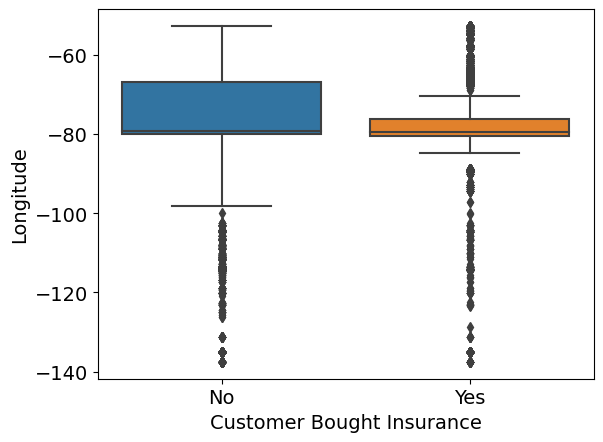

In [149]:
ax = sns.boxplot(data=insurance_train_data_reduced, x='IS_BOUND', y='longitude')
plt.xlabel('Customer Bought Insurance',fontsize=14)
plt.ylabel('Longitude',fontsize=14)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [150]:
print('array([25%ile, 50%ile, 75%ile]) values of Longitude for non-buyers')
print(np.percentile(insurance_train_data_reduced.loc[insurance_train_data_reduced['IS_BOUND'] == 0]['longitude'], [25,50,75]))

array([25%ile, 50%ile, 75%ile]) values of Longitude for non-buyers
[-79.886  -79.2819 -66.9328]


In [151]:
print('array([25%ile, 50%ile, 75%ile]) values of Longitude for buyers')
print(np.percentile(insurance_train_data_reduced.loc[insurance_train_data_reduced['IS_BOUND'] == 1]['longitude'], [25,50,75]))

array([25%ile, 50%ile, 75%ile]) values of Longitude for buyers
[-80.4414 -79.4207 -76.2494]


**From the comparison above we see that the 75 percentile of longitude is different for buyers (-76.3) and non-buyers (-66.9).**

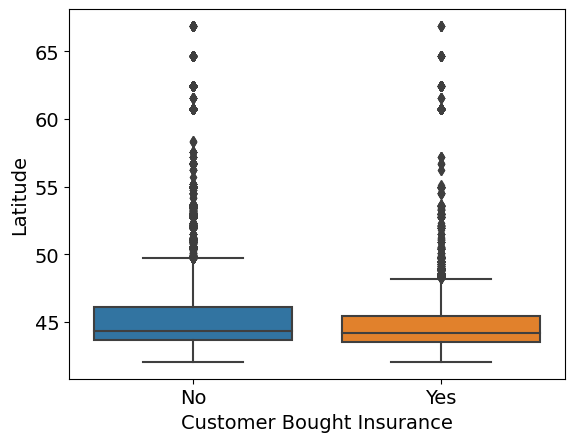

In [152]:
ax = sns.boxplot(data=insurance_train_data_reduced, x='IS_BOUND', y='latitude')
plt.xlabel('Customer Bought Insurance',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### CATEGORICAL FEATURE IMPORTANCES

In [153]:
# creating a list of categorical features
categorical_features = list(insurance_train_data_reduced.select_dtypes(include = ['object']).columns)
categorical_features

['VEHICLEMAKE',
 'VEHICLE_OWNERSHIP',
 'VEHICLEUSE',
 'GENDER',
 'MULTI_PRODUCT',
 'MARITAL_STATUS',
 'OCCUPATION',
 'TOPVEHICLEMODELS',
 'MONTH']

In [154]:
def contingency_table(df, feature):
    '''
    The function takes a DataFrame df and a feature name 
    as input and returns a contingency table. A contingency table is a 
    table that shows the frequency distribution of two categorical variables.
    '''
    # Get the unique categories of the feature
    feature_categories = list(Counter(df[feature]).keys())
    # Calculate the number of categories
    dim = len(feature_categories)
    # Create a contingency table with 2 rows and dim columns
    table = np.zeros((2, dim))
    # Iterate over the rows and columns of the table
    for row in range(2):
        for column in range(dim):
            # Count the number of occurrences where IS_BOUND is equal to row and feature is equal to the category
            table[row, column] = df.loc[(df['IS_BOUND'] == row) & (df[feature] == feature_categories[column])].shape[0]
    
    return table

In [155]:
print('feature name,', 'chi square value,', 'p value,', 'degree of freedom\n')
# iterate over categorical features
for feature in categorical_features:
    # make contingency table
    table = contingency_table(insurance_train_data_reduced, feature)  
    # calculate chi-square value for the contingency table
    stat, p, dof, expected = chi2_contingency(table)
    print(feature, ',', round(stat), ',', f'10^{round(np.log(p))},', dof)

feature name, chi square value, p value, degree of freedom

VEHICLEMAKE , 280 , 10^-12, 184
VEHICLE_OWNERSHIP , 2 , 10^-1, 2
VEHICLEUSE , 75 , 10^-27, 9
GENDER , 4 , 10^-3, 1
MULTI_PRODUCT , 1142 , 10^-575, 1
MARITAL_STATUS , 39 , 10^-16, 4
OCCUPATION , 82 , 10^-22, 18
TOPVEHICLEMODELS , 605 , 10^-18, 425
MONTH , 13 , 10^-1, 11


**MULTI_PRODUCT has the smallest p-value. Let's examine that feature.**

In [156]:
feature = 'MULTI_PRODUCT'
table = contingency_table(insurance_train_data_reduced, feature)      
stat, p, dof, expected = chi2_contingency(table)
print(feature)
print('observed distribution:\n', table)
print('expected distribution:\n', np.around(expected))

MULTI_PRODUCT
observed distribution:
 [[29403. 50147.]
 [ 5526. 16755.]]
expected distribution:
 [[27286. 52264.]
 [ 7643. 14638.]]


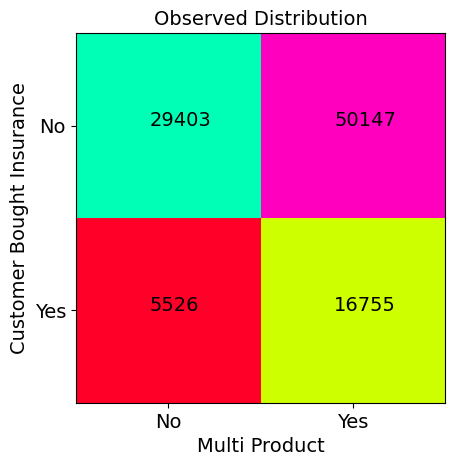

In [157]:
plt.imshow(table, cmap=plt.cm.gist_rainbow)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], fontsize=14)
plt.yticks(ticks=[0, 1], labels=['No', 'Yes'], fontsize=14)
plt.ylabel('Customer Bought Insurance', fontsize=14)
plt.xlabel('Multi Product', fontsize=14)
plt.text(-0.1,0,round(table[0,0]), fontsize=14)
plt.text(0.9,0,round(table[0,1]), fontsize=14)
plt.text(-0.1,1,round(table[1,0]), fontsize=14)
plt.text(0.9,1,round(table[1,1]), fontsize=14)
plt.title('Observed Distribution', fontsize=14);

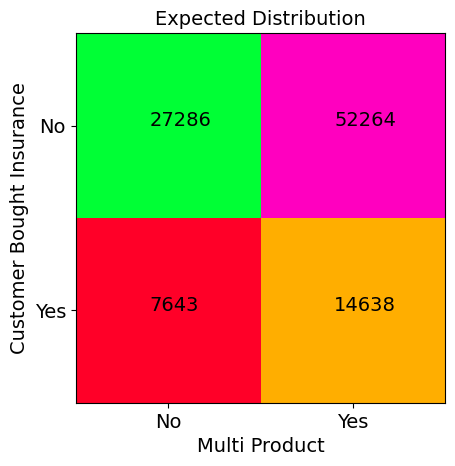

In [158]:
plt.imshow(expected, cmap=plt.cm.gist_rainbow)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], fontsize=14)
plt.yticks(ticks=[0, 1], labels=['No', 'Yes'], fontsize=14)
plt.ylabel('Customer Bought Insurance', fontsize=14)
plt.xlabel('Multi Product', fontsize=14)
plt.text(-0.1,0,round(expected[0,0]), fontsize=14)
plt.text(0.9,0,round(expected[0,1]), fontsize=14)
plt.text(-0.1,1,round(expected[1,0]), fontsize=14)
plt.text(0.9,1,round(expected[1,1]), fontsize=14)
plt.title('Expected Distribution', fontsize=14);

In [159]:
feature = 'VEHICLEUSE'
table = contingency_table(insurance_train_data_reduced, feature)      
stat, p, dof, expected = chi2_contingency(table)
print(feature)
print('observed distribution:\n', table)
print('expected distribution:\n', np.around(expected))

VEHICLEUSE
observed distribution:
 [[26823.  1869. 50532.   280.    18.    20.     2.     4.     1.     1.]
 [ 7713.   592. 13806.   156.    11.     3.     0.     0.     0.     0.]]
expected distribution:
 [[26979.  1923. 50261.   341.    23.    18.     2.     3.     1.     1.]
 [ 7557.   538. 14077.    95.     6.     5.     0.     1.     0.     0.]]


# DATA MODELLING

### IMBALANCED LEARNING

**First step was to split the data into 90% training and 10% test set. We then tested the baseline performance of several classifiers on the training set. We selected the XGBoost model since it performed the best. We performed grid seach cross-validation to fine-tune the model. Finally, we trained the fine-tuned model on the training set and evaluated the performance on the test set.**

In [160]:
# Now that our dataset is ready let's convert the categorical variables into dummy variables
# the converted numerical columns will have the original categorical columns as prefix
prefix = {col: col for col in categorical_features}
insurance_train_data_reduced_numerical = pd.get_dummies(insurance_train_data_reduced, prefix = prefix, drop_first=True)

In [161]:
insurance_train_data_reduced_numerical.shape

(101831, 669)

In [162]:
insurance_train_data_reduced_numerical.head()

VEHICLEYEAR  ANNUAL_KM  COMMUTE_DISTANCE  VEHICLE_VALUE  YEAR_OF_BIRTH  \
0         2006    10000.0              10.0    3000.000000           1975   
1         2017    20000.0              10.0   27017.815126           1958   
2         2015    15000.0              10.0   39222.673611           1960   
3         2010    20000.0              20.0   18757.525692           1985   
4         2013    30000.0              30.0   23062.825243           1982   

   YEARS_LICENSED  CONVICTION_COUNT_MINOR_3YRS  CONVICTION_COUNT_MAJOR_3YRS  \
0            25.0                            0                            0   
1            10.0                            0                            0   
2            39.0                            0                            0   
3             3.0                            0                            0   
4             2.0                            0                            0   

   CONVICTION_COUNT_CRIMINAL_3YRS  ASSIGNED_LOSSES_PD_5YRS  ...  MONTH_11  \
0                               0                        0  ...     False   
1                               0                        0  ...     False   
2                               0                        0  ...     False   
3                               0                        0  ...     False   
4                               0                        0  ...     False   

   MONTH_12  MONTH_2  MONTH_3  MONTH_4  MONTH_5  MONTH_6  MONTH_7  MONTH_8  \
0     False    False    False    False    False    False    False    False   
1     False    False    False    False    False    False    False    False   
2     False    False    False    False    False    False    False    False   
3     False    False    False    False    False    False    False    False   
4     False    False    False    False    False    False    False    False   

   MONTH_9  
0    False  
1    False  
2    False  
3    False  
4    False  

[5 rows x 669 columns]

In [163]:
# Assign the target variable (y) and the features (X) that will be used to predict the target variable
y = insurance_train_data_reduced_numerical['IS_BOUND'].values
X = insurance_train_data_reduced_numerical.drop(columns = 'IS_BOUND')

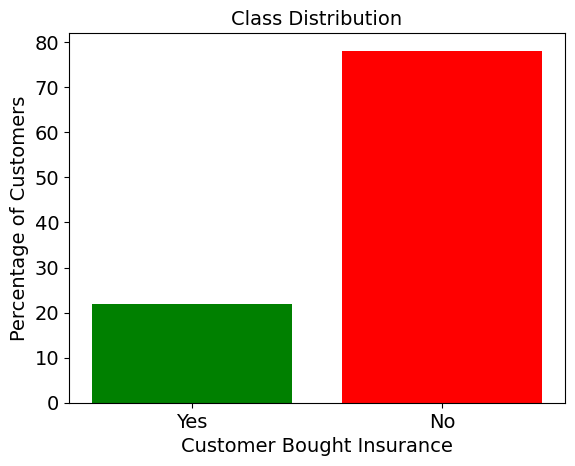

In [164]:
# Let's look at the distribution of the classes in the IS_BOUND i.e. the frequency of people buying insurance vs not. Seems like roughly
# 20 percent of the people end up buying insurance.
plt.bar([0,1],[100*sum(y)/len(y), 100*(1-sum(y)/len(y))],tick_label = ['Yes', 'No'], color=['green', 'red'])
plt.xlabel('Customer Bought Insurance', fontsize=14)
plt.ylabel('Percentage of Customers', fontsize=14)
plt.yticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Class Distribution', fontsize=14);

In [165]:
# Creating a test train split using a test size of 0.1 i.e. 10 percent of the dataset
randN = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = randN, test_size = 0.1)

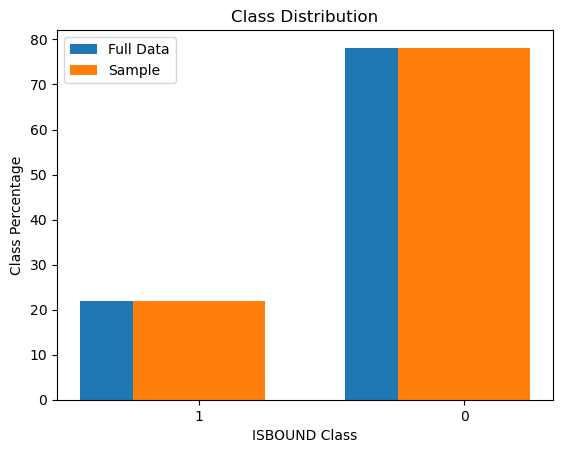

In [166]:
x = [0,1]
plt.bar(x,[100*sum(y)/len(y), 100*(len(y)-sum(y))/len(y)],tick_label=['1', '0'], label = 'Full Data',width=0.5)
x = list(map(lambda x: x+0.2, x))
plt.bar(x,[100*sum(y_train)/len(y_train), 100*(len(y_train)-sum(y_train))/len(y_train)],tick_label=['1', '0'],width=0.5, label='Sample')
plt.xlabel('ISBOUND Class')
plt.ylabel('Class Percentage')
plt.title('Class Distribution')
plt.legend();

In [167]:
# let's try out some classifiers
estimators = {'logreg': LogisticRegression(solver = 'saga'), 
'dtc': DecisionTreeClassifier(),               
'rfc': RandomForestClassifier(), 
'gbc': GradientBoostingClassifier(),              
'xgb': XGBClassifier()            
}

In [168]:
# Let's define a custom function called revenue that will calculate revenue using the output of the confusion matrix.

def revenue(true, pred):
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    return ((5.5 * tp) - (tp + fp))/len(true)

In [169]:
def f2_score(true, pred):
    '''
    This function calculates F2 scores from ground truth and perdictions.
    Args: true: ground truth
        pred: predictions
    Returns: f2: F2 score
    '''
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    f2 = (5 * p * r) / (4 * p + r)
    return f2

# dictionary containing verious performance metrics
scoring = {'recall': 'recall',
          'precision': 'precision',
          'f1': 'f1',
           'f2': make_scorer(f2_score),
          'roc_auc': 'roc_auc',
           'Revenue': make_scorer(revenue)
          }

In [170]:
def model_testing(X,y, estimators):
    '''
    This function performs cross validation for variety of models.
    Args: X: training data
        y: output variable
        estimators: list of estimators
    Returns: est_scores_dict: dictionary containing performance scores from 
    models
    '''
    # initialize dictionary containing estimators as keys and perforances scores as output.
    est_scores_dict = {}

    # Loop through each estimator in the dictionary
    for estimator in estimators.keys():
        # Get the estimator object
        est = estimators[estimator]
        print(f'Started with {est}\n')
        # Record the start time for performance measurement
        start = time.time()
        # Perform cross-validation with the current estimator
        est_scores_dict[estimator] = cross_validate(est, X, y, n_jobs=-1, scoring=scoring);
        # Print a message indicating the completion of processing with the current estimator
        print(f'Finished with {est}\n')
        print('Time taken = ', round((time.time() - start)/60.,2) ,'mins \n')

    return est_scores_dict

In [171]:
def model_score(scores_dict, scoring):
    '''
    This function displays the scores from different classifiers in a 
    dataframe.
    Args: scores_dict: Output dictionary from model_testing function
        scoring: dictionary containing various perfomance metrics
    Returns: mean_df: dataframe containing mean scores over k-fold 
            cross-validation sets
            std_df: dataframe containing standard deviation scores over k-fold 
            cross-validation sets
    '''
    # Create a set of score names with 'test_' prefix
    score_set = {'test_' + score for score in scoring.keys()}
    # Initialize dictionaries to store mean and standard deviation values
    mean_dict = {}
    std_dict = {}

    # Calculate mean and standard deviation for each estimator
    for estimator in scores_dict.keys():
        # Calculate mean for each score in the score set
        mean_dict[estimator] = {score: round(np.mean(scores_dict[estimator][score]),3) for score in score_set}
        # Calculate standard deviation for each score in the score set
        std_dict[estimator] = {score: round(np.std(scores_dict[estimator][score]),3) for score in score_set}

    # Create DataFrames from the mean and standard deviation dictionaries
    mean_df = pd.DataFrame(mean_dict)
    std_df = pd.DataFrame(std_dict)
    
    return mean_df, std_df

In [172]:
# Extract numerical features from the reduced insurance training data
numerical_features = list(insurance_train_data_reduced_numerical.select_dtypes(include=['int64', 'float64']).columns.values)
# Remove the output feature 'IS_BOUND' from the list of numerical features
numerical_features.remove('IS_BOUND')
# Display the remaining numerical features
print('Numerical Features\n')
numerical_features

Numerical Features



['VEHICLEYEAR',
 'ANNUAL_KM',
 'COMMUTE_DISTANCE',
 'VEHICLE_VALUE',
 'YEAR_OF_BIRTH',
 'YEARS_LICENSED',
 'CONVICTION_COUNT_MINOR_3YRS',
 'CONVICTION_COUNT_MAJOR_3YRS',
 'CONVICTION_COUNT_CRIMINAL_3YRS',
 'ASSIGNED_LOSSES_PD_5YRS',
 'SUSPENSION_COUNT',
 'latitude',
 'longitude']

In [173]:
# Normalize our dataset

# Initialize MinMaxScaler to scale numerical features
scaler = MinMaxScaler()
# Fit the scaler to the training data for numerical features
X_transformer = scaler.fit(X_train[numerical_features])
# Transform the training data using the fitted scaler
X_transform = X_transformer.transform(X_train[numerical_features])

In [174]:
def normalized_matrix_to_df(original_df, normalized_matrix, normalized_features):
    '''
    This function returns a dataframe containing categorical columns and 
    normalized numerical columns from a matrix containing normalized values.
    Args: original_df: Un-normalized dataframe
        normalized_matrix: matrix containing normalized values
        normalized_features: normalized feature names
    Returns: transformed_data_df: transformed/normalized dataframe
    '''
    # making a deep copy of training data
    transformed_data_df = original_df.copy()
    # replacing numerical values with normalized values
    transformed_data_df[normalized_features] = normalized_matrix
    
    return transformed_data_df

In [175]:
# converting normalized values to dataframe
transformed_train_data_df = normalized_matrix_to_df(X_train, X_transform, numerical_features)

# looking at the first few rows of dataset
transformed_train_data_df.head()

VEHICLEYEAR  ANNUAL_KM  COMMUTE_DISTANCE  VEHICLE_VALUE  YEAR_OF_BIRTH  \
5536      0.932584   0.091847          0.010011       0.027592       0.775510   
28848     0.853933   0.143447          0.010011       0.026998       0.714286   
70033     0.966292   0.195046          0.010011       0.051454       0.734694   
22879     0.808989   0.091847          0.010011       0.010291       0.581633   
21977     0.910112   0.195046          0.004449       0.016248       0.816327   

       YEARS_LICENSED  CONVICTION_COUNT_MINOR_3YRS  \
5536         0.030612                       0.0000   
28848        0.061224                       0.1250   
70033        0.091837                       0.0625   
22879        0.112245                       0.0000   
21977        0.030612                       0.0000   

       CONVICTION_COUNT_MAJOR_3YRS  CONVICTION_COUNT_CRIMINAL_3YRS  \
5536                           0.0                            0.00   
28848                          0.0                            0.00   
70033                          0.0                            0.25   
22879                          0.0                            0.00   
21977                          0.0                            0.00   

       ASSIGNED_LOSSES_PD_5YRS  ...  MONTH_11  MONTH_12  MONTH_2  MONTH_3  \
5536                      0.00  ...     False     False     True    False   
28848                     0.00  ...     False     False    False    False   
70033                     0.00  ...     False     False    False    False   
22879                     0.25  ...     False     False    False    False   
21977                     0.00  ...     False     False    False    False   

       MONTH_4  MONTH_5  MONTH_6  MONTH_7  MONTH_8  MONTH_9  
5536     False    False    False    False    False    False  
28848    False     True    False    False    False    False  
70033    False    False    False    False    False     True  
22879     True    False    False    False    False    False  
21977     True    False    False    False    False    False  

[5 rows x 668 columns]

In [176]:
# verifying that normalized train data shape is same as original train data
assert transformed_train_data_df.shape == X_train.shape

In [177]:
def convert_bool_to_int(df, features):
    '''
    This function converts boolean columns (obtained after converting 
    categorical columns to dummy variables) to intergers.
    Args: df: dataframe containing boolean values
        features: boolean feature names
    Returns: df: updated dataframe containing integer values.
    '''
    # loop over categorical features
    for col in features:
        # converting boolean categorical variables to integer
        df[col] = df[col].astype(int)
    return df

In [178]:
# making a list of categorical variables
categorical_features = list(transformed_train_data_df.select_dtypes(include=['bool']).columns.values)
# converting boolean values to integer
transformed_train_data_df = convert_bool_to_int(transformed_train_data_df, categorical_features)

In [179]:
transformed_train_data_df.head()

VEHICLEYEAR  ANNUAL_KM  COMMUTE_DISTANCE  VEHICLE_VALUE  YEAR_OF_BIRTH  \
5536      0.932584   0.091847          0.010011       0.027592       0.775510   
28848     0.853933   0.143447          0.010011       0.026998       0.714286   
70033     0.966292   0.195046          0.010011       0.051454       0.734694   
22879     0.808989   0.091847          0.010011       0.010291       0.581633   
21977     0.910112   0.195046          0.004449       0.016248       0.816327   

       YEARS_LICENSED  CONVICTION_COUNT_MINOR_3YRS  \
5536         0.030612                       0.0000   
28848        0.061224                       0.1250   
70033        0.091837                       0.0625   
22879        0.112245                       0.0000   
21977        0.030612                       0.0000   

       CONVICTION_COUNT_MAJOR_3YRS  CONVICTION_COUNT_CRIMINAL_3YRS  \
5536                           0.0                            0.00   
28848                          0.0                            0.00   
70033                          0.0                            0.25   
22879                          0.0                            0.00   
21977                          0.0                            0.00   

       ASSIGNED_LOSSES_PD_5YRS  ...  MONTH_11  MONTH_12  MONTH_2  MONTH_3  \
5536                      0.00  ...         0         0        1        0   
28848                     0.00  ...         0         0        0        0   
70033                     0.00  ...         0         0        0        0   
22879                     0.25  ...         0         0        0        0   
21977                     0.00  ...         0         0        0        0   

       MONTH_4  MONTH_5  MONTH_6  MONTH_7  MONTH_8  MONTH_9  
5536         0        0        0        0        0        0  
28848        0        1        0        0        0        0  
70033        0        0        0        0        0        1  
22879        1        0        0        0        0        0  
21977        1        0        0        0        0        0  

[5 rows x 668 columns]

In [180]:
# converting the training data to sparse matrix for faster computation
transformed_train_data_df_sparse = sparse.csr_matrix(transformed_train_data_df.values)

In [181]:
# running the model testing function
est_scores_dict = model_testing(transformed_train_data_df_sparse, y_train, estimators)

Started with LogisticRegression(solver='saga')



/Users/saurabh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/saurabh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/saurabh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/saurabh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/saurabh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Finished with LogisticRegression(solver='saga')

Time taken =  0.28 mins 

Started with DecisionTreeClassifier()

Finished with DecisionTreeClassifier()

Time taken =  0.87 mins 

Started with RandomForestClassifier()

Finished with RandomForestClassifier()

Time taken =  7.73 mins 

Started with GradientBoostingClassifier()

Finished with GradientBoostingClassifier()

Time taken =  1.19 mins 

Started with XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, 

In [182]:
# calcualting mean and standard deviation of scores across 5 folds
mean, std = model_score(est_scores_dict, scoring)
# looking at mean scores
mean

logreg    dtc    rfc    gbc    xgb
test_Revenue     0.000  0.117  0.004  0.000  0.018
test_f1          0.002  0.277  0.016  0.002  0.049
test_precision   0.292  0.286  0.315  0.325  0.426
test_recall      0.001  0.269  0.008  0.001  0.026
test_f2          0.001  0.272  0.010  0.001  0.032
test_roc_auc     0.606  0.541  0.646  0.668  0.666

In [183]:
# XGBoost being the best estimator, let's create a final XGBoost model
best_estimator = estimators['xgb']
best_estimator

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [184]:
# Setting up hyperparameter tuning
param_grid = {'max_depth': [1, 3, 5, None],
             'n_estimators': [50, 100, 150, None],
             'learning_rate': [0.01, 0.1, 1., None]}

In [185]:
# Setting up grid search cross validation
grid_search_imbalanced = GridSearchCV(best_estimator, param_grid, cv = 5, scoring = 'roc_auc', return_train_score=True, n_jobs=-1)

In [186]:
# running grid search CV
start = time.time()
grid_search_imbalanced.fit(transformed_train_data_df_sparse, y_train);
print('XGBoost Grid Search Time Taken: ', round( (time.time() - start)/60., 3), ' mins')

XGBoost Grid Search Time Taken:  3.583  mins


In [187]:
print('Best ROC AUC score =', round(grid_search_imbalanced.best_score_, 2))

Best ROC AUC score = 0.67


In [188]:
best_est_imbalanced = grid_search_imbalanced.best_estimator_
print('hyper-parameters of the best model are: ', best_est_imbalanced)

hyper-parameters of the best model are:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [189]:
# normalizing test data using transformer fitted on train data
X_test_transformed = X_transformer.transform(X_test[numerical_features])
# converting transformed matrix to dataframe
test_data_df = normalized_matrix_to_df(X_test, X_test_transformed, numerical_features)
# converting boolean values to integer
test_data_df = convert_bool_to_int(test_data_df, categorical_features)
test_data_df.head()

VEHICLEYEAR  ANNUAL_KM  COMMUTE_DISTANCE  VEHICLE_VALUE  YEAR_OF_BIRTH  \
95911     0.943820   0.298246          0.043382       0.044003       0.459184   
34140     0.808989   0.091847          0.002225       0.004373       0.622449   
5370      0.943820   0.091847          0.008899       0.029028       0.775510   
33604     0.887640   0.091847          0.016685       0.029779       0.520408   
88721     0.943820   0.091847          0.010011       0.037498       0.448980   

       YEARS_LICENSED  CONVICTION_COUNT_MINOR_3YRS  \
95911        0.367347                          0.0   
34140        0.071429                          0.0   
5370         0.030612                          0.0   
33604        0.295918                          0.0   
88721        0.285714                          0.0   

       CONVICTION_COUNT_MAJOR_3YRS  CONVICTION_COUNT_CRIMINAL_3YRS  \
95911                          0.0                             0.0   
34140                          0.0                             0.0   
5370                           0.0                             0.0   
33604                          0.0                             0.0   
88721                          0.0                             0.0   

       ASSIGNED_LOSSES_PD_5YRS  ...  MONTH_11  MONTH_12  MONTH_2  MONTH_3  \
95911                      0.0  ...         1         0        0        0   
34140                      0.0  ...         0         0        0        0   
5370                       0.0  ...         0         0        1        0   
33604                      0.0  ...         0         0        0        0   
88721                      0.0  ...         1         0        0        0   

       MONTH_4  MONTH_5  MONTH_6  MONTH_7  MONTH_8  MONTH_9  
95911        0        0        0        0        0        0  
34140        0        1        0        0        0        0  
5370         0        0        0        0        0        0  
33604        0        1        0        0        0        0  
88721        0        0        0        0        0        0  

[5 rows x 668 columns]

In [190]:
# converting test data to sparse matrix
test_data_df_sparse = sparse.csr_matrix(test_data_df.values)

In [191]:
# training the fine-tuned XGBoost model on the 90% train set
best_est_imbalanced.fit(transformed_train_data_df_sparse, y_train)
# using the trained model to predict IS_BOUND on the test set.
threshold = 0.4
y_preds = (best_est_imbalanced.predict_proba(test_data_df_sparse)[:, 1] > threshold).astype('float')

In [192]:
# computing confusion matrix containing: true positives, false positives, 
# true negatives & false negatives.
cm = confusion_matrix(y_test, y_preds, labels=[0, 1])

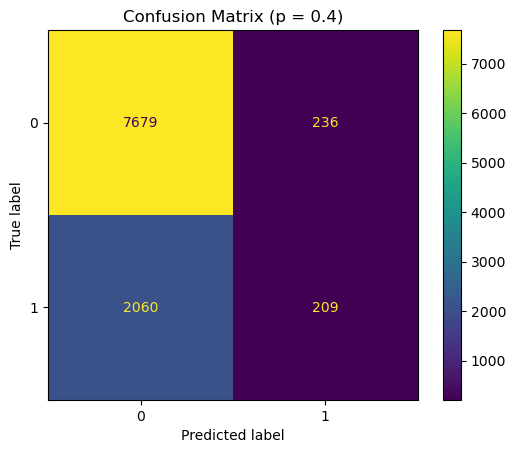

In [193]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
disp.ax_.set_title(f'Confusion Matrix (p = {threshold})');

In [194]:
print('ROC AUC score on test data =', round(roc_auc_score(y_test, best_est_imbalanced.predict_proba(test_data_df_sparse)[:, 1]), 2))

ROC AUC score on test data = 0.67


### BALANCED LEARNING

**We also tried the balanced learning technique where we used random undersampling to select examples with IS_BOUND = 0 so that we have an equal number of examples from both class. The rationale behind this approach was that by having equal examples of both class, the classifier will have enough examples of both classes to learn from and might be better at predicting the output variable.**

In [195]:
# Since the majority class is 0. Let's use the random under sampler to balance the class distribution in our training dataset as 80 percent of our dataset
# is under one class.  This is done so that our model works equally well for both the classes
rus = RandomUnderSampler(random_state = randN)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

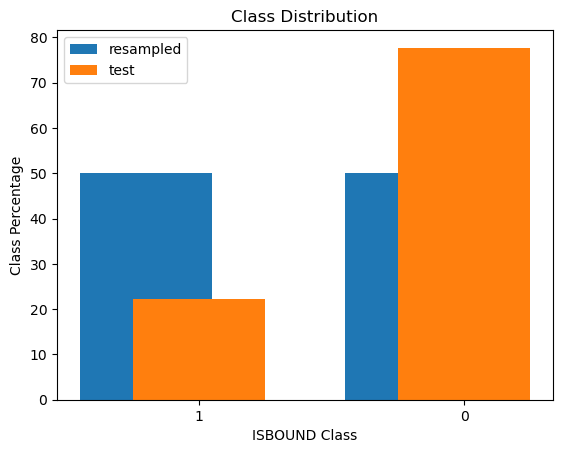

In [196]:
# See how the data will look after applying the random under sampler.
# We'll keep the class imbalance in the test set because
# that is reflective of the true distribution.
x = [0,1]
plt.bar(x,[100*sum(y_resampled)/len(y_resampled), 100*(1-sum(y_resampled)/len(y_resampled))],tick_label=['1', '0'],label='resampled', width = 0.5)
x = list(map(lambda x: x+0.2, x))
plt.bar(x,[100*sum(y_test)/len(y_test), 100*(1-sum(y_test)/len(y_test))],tick_label=['1', '0'],label='test', width = 0.5)
plt.xlabel('ISBOUND Class')
plt.ylabel('Class Percentage')
plt.title('Class Distribution')
plt.legend();

In [197]:
# Normalize our dataset
scaler = MinMaxScaler()
X_transformer = scaler.fit(X_resampled[numerical_features])
X_transform = X_transformer.transform(X_resampled[numerical_features])

In [198]:
# The one hot encoding function returns a matrix. let's extract the training set and convert it to dataframe.
resampled_train_data_df = normalized_matrix_to_df(X_resampled, X_transform, numerical_features)
resampled_train_data_df = convert_bool_to_int(resampled_train_data_df, categorical_features)
resampled_train_data_df.head()

VEHICLEYEAR  ANNUAL_KM  COMMUTE_DISTANCE  VEHICLE_VALUE  YEAR_OF_BIRTH  \
61175     0.966292   0.090909          0.028056       0.115012       0.494737   
36147     0.865169   0.142562          0.018036       0.043121       0.263158   
21533     0.808989   0.194215          0.030060       0.024170       0.442105   
87483     0.820225   0.194215          0.008016       0.029945       0.736842   
62252     0.808989   0.194215          0.058116       0.041270       0.800000   

       YEARS_LICENSED  CONVICTION_COUNT_MINOR_3YRS  \
61175        0.329897                         0.00   
36147        0.546392                         0.00   
21533        0.103093                         0.00   
87483        0.092784                         0.00   
62252        0.030928                         0.25   

       CONVICTION_COUNT_MAJOR_3YRS  CONVICTION_COUNT_CRIMINAL_3YRS  \
61175                     0.000000                             0.0   
36147                     0.000000                             0.0   
21533                     0.000000                             0.0   
87483                     0.000000                             0.0   
62252                     0.333333                             0.0   

       ASSIGNED_LOSSES_PD_5YRS  ...  MONTH_11  MONTH_12  MONTH_2  MONTH_3  \
61175                      0.0  ...         0         0        0        0   
36147                      0.0  ...         0         0        0        0   
21533                      0.0  ...         0         0        0        0   
87483                      0.0  ...         0         0        0        0   
62252                      0.0  ...         0         0        0        0   

       MONTH_4  MONTH_5  MONTH_6  MONTH_7  MONTH_8  MONTH_9  
61175        0        0        0        0        1        0  
36147        0        1        0        0        0        0  
21533        1        0        0        0        0        0  
87483        0        0        0        0        0        0  
62252        0        0        0        0        1        0  

[5 rows x 668 columns]

In [199]:
# asserting shape of transformed dataframe is same as original dataframe
assert resampled_train_data_df.shape == X_resampled.shape

In [200]:
# converting the balanced training set into sparse matrix
resampled_train_data_df_sparse = sparse.csr_matrix(resampled_train_data_df.values)

In [201]:
# testing various classifiers and 
# calculating their mean and standard deviations
est_scores_dict = model_testing(resampled_train_data_df_sparse, y_resampled, estimators)
mean, std = model_score(est_scores_dict, scoring)

Started with LogisticRegression(solver='saga')

Finished with LogisticRegression(solver='saga')

Time taken =  0.04 mins 

Started with DecisionTreeClassifier()

Finished with DecisionTreeClassifier()

Time taken =  0.2 mins 

Started with RandomForestClassifier()

Finished with RandomForestClassifier()

Time taken =  2.21 mins 

Started with GradientBoostingClassifier()

Finished with GradientBoostingClassifier()

Time taken =  0.43 mins 

Started with XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_lea

In [202]:
# looking at the mean scores
mean

logreg    dtc    rfc    gbc    xgb
test_Revenue     1.143  1.046  1.199  1.275  1.268
test_f1          0.590  0.562  0.616  0.635  0.632
test_precision   0.572  0.562  0.611  0.614  0.608
test_recall      0.609  0.562  0.621  0.659  0.658
test_f2          0.602  0.562  0.619  0.649  0.647
test_roc_auc     0.601  0.562  0.653  0.667  0.660

In [203]:
# training the best model XGBoost on training data
best_estimator = estimators['xgb']

In [204]:
# Setting up hyperparameter tuning
param_grid = {'max_depth': [1, 3, 5, None],
             'n_estimators': [50, 100, 150, None],
             'learning_rate': [0.01, 0.1, 1., None]}

In [205]:
# Setting up grid search cross validation
grid_search_balanced = GridSearchCV(best_estimator, param_grid, cv = 5, scoring = 'roc_auc', return_train_score=True, n_jobs=-1)

In [206]:
# running grid search CV
start = time.time()
grid_search_balanced.fit(resampled_train_data_df_sparse, y_resampled);
print('XGBoost Grid Search Time Taken: ', round( (time.time() - start)/60., 3), ' mins')

XGBoost Grid Search Time Taken:  1.664  mins


In [207]:
best_est_balanced = grid_search_balanced.best_estimator_
print('hyper-parameters of the best model are: ', best_est_balanced)

hyper-parameters of the best model are:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [208]:
# predicting test set
threshold = 0.5
y_preds = (best_est_balanced.predict_proba(test_data_df_sparse)[:, 1] > threshold).astype('float')

In [209]:
# calculating confusion matrix
cm = confusion_matrix(y_test, y_preds, labels=[0, 1])

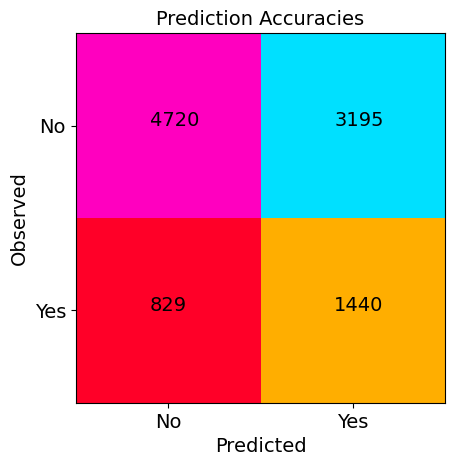

In [210]:
plt.imshow(cm, cmap=plt.cm.gist_rainbow)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], fontsize=14)
plt.yticks(ticks=[0, 1], labels=['No', 'Yes'], fontsize=14)
plt.ylabel('Observed', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.text(-0.1,0,round(cm[0,0]), fontsize=14)
plt.text(0.9,0,round(cm[0,1]), fontsize=14)
plt.text(-0.1,1,round(cm[1,0]), fontsize=14)
plt.text(0.9,1,round(cm[1,1]), fontsize=14)
plt.title('Prediction Accuracies', fontsize=14);

In [211]:
# outputting false positive rates (fpr) and true positive rates (tpr)
# to plot the ROC curve
fpr, tpr, threshold = roc_curve(y_test, best_est_balanced.predict_proba(test_data_df_sparse)[:, 1])

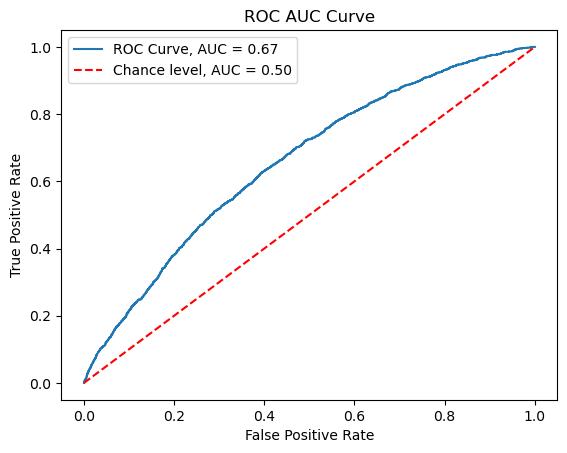

In [212]:
plt.plot(fpr, tpr, label = f'ROC Curve, AUC = {round(grid_search_balanced.best_score_, 2)}')
plt.plot([0, 1], [0, 1],'r--', label = 'Chance level, AUC = 0.50')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC Curve')
plt.legend();

### Feature Importances

**We also looked at feature importances to understand what features were important in distinguishing between the two classes. The most important feature is MULTI_PRODUCT which describes whether the insurance quote covers multiple products such as auto-home bundling or two or more vehicles covered by the same insurance policy. AREA_CODES were the second most important feature.**

In [213]:
# looking at top 10 features
feature_importances_ind = np.argsort(best_est_balanced.feature_importances_)[::-1]
feature_importances_ind[:10]

array([209,  12,   5,   4, 212, 210,  11, 223, 202, 199])

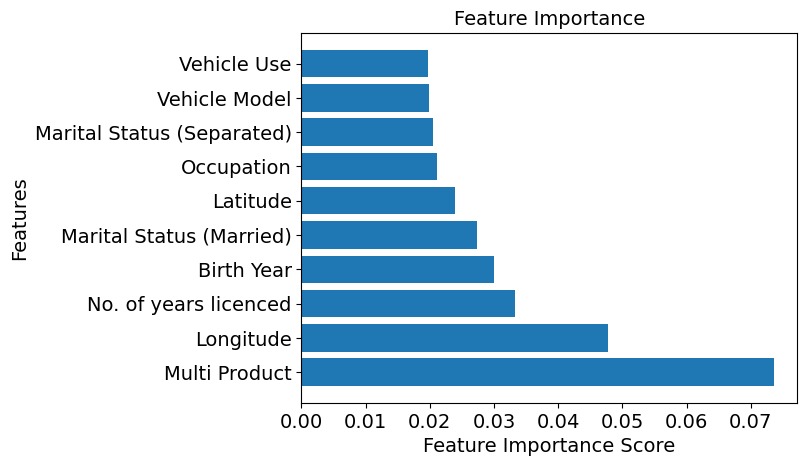

In [214]:
top_10_features = feature_importances_ind[:10]
plt.barh(test_data_df.columns.values[top_10_features], best_est_balanced.feature_importances_[top_10_features])
plt.xlabel('Feature Importance Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)
plt.title('Feature Importance', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(ticks = range(0,10), labels = ['Multi Product', 'Longitude', 'No. of years licenced', 'Birth Year', 'Marital Status (Married)', 'Latitude', 'Occupation', 'Marital Status (Separated)', 'Vehicle Model', 'Vehicle Use'], fontsize = 14);


#### Key step

**Let's do a final training of the model using all Class 1 entries and an equal number of Class 0 entries. We'll use this model to predict the Leadeboard test set.**

In [215]:
X_resampled_final, y_resampled_final = rus.fit_resample(X, y)
print('Class Counts')
Counter(y_resampled_final)

Class Counts


Counter({0: 22281, 1: 22281})

In [216]:
X_transformer = scaler.fit(X_resampled_final[numerical_features])

In [217]:
def data_preparation(df, numerical_features, categorical_features, transformer):
    '''
    This function uses the fitted scaler to scale the numerical features in 
    the data, converts categorical columns to numerical using OHE and returns 
    the final dataset.
    Args: df: dataframe,
    numerical_features: list of numerical features to be scaled,
    categorical_features: list of categorical features, 
    transformer: fitted scaler on training set used to scale data
    Returns: resampled_final_data_df: Scaled and OHE dataset. 
    '''
    # normalizing the dataset
    X_final_scaled = transformer.transform(df[numerical_features])
    # dataframe
    resampled_final_data_df = normalized_matrix_to_df(df, X_final_scaled, numerical_features)
    # bool to int
    resampled_final_data_df = convert_bool_to_int(resampled_final_data_df, categorical_features)
    
    return resampled_final_data_df

In [218]:
resampled_final_data_df = data_preparation(X_resampled_final, numerical_features, categorical_features, X_transformer)

In [219]:
# training XGBoost on balanced data
final_model = best_est_balanced.fit(resampled_final_data_df, y_resampled_final)

# TEST SET

**Let's set up the test set exactly like the train set**

In [220]:
# loading test data set in pandas and taking a peek at it
insurance_test_data = pd.read_excel('data/Cooperators_Quotes_Dataset_Test.xlsx')
print('shape of test data:', insurance_test_data.shape, '\n')
insurance_test_data.head()

shape of test data: (15114, 25) 



QUOTEDATE  VEHICLEYEAR          VEHICLEMAKE  \
0 2017-01-03         2002                HONDA   
1 2017-01-04         2010       FORD TRUCK/VAN   
2 2017-01-04         2017  DODGE/RAM TRUCK/VAN   
3 2017-01-04         2013  DODGE/RAM TRUCK/VAN   
4 2017-01-04         2014                 FORD   

                      VEHICLEMODEL  ANNUALKM  COMMUTEDISTANCE MARKINGSYSTEM  \
0  CIVIC EX 2DR COUPE [U.S. MODEL]     10000              4.0           NaN   
1           F150 XLT SUPERCREW 4WD     10000             10.0           NaN   
2      RAM 1500 REBEL CREW CAB 4WD      9000              3.0           NaN   
3      RAM 1500 SPORT CREW CAB 4WD     10000             10.0           NaN   
4                     FOCUS SE 4DR     20000             10.0           NaN   

  TRACKINGSYSTEM VEHICLEOWNERSHIP  VEHICLEVALUE  ... YEARSLICENSED  \
0            NaN              NaN           NaN  ...           7.0   
1            NaN              NaN           NaN  ...          13.0   
2            NaN            Owned       72000.0  ...          33.0   
3            NaN              NaN       55000.0  ...           9.0   
4            NaN              NaN           NaN  ...           4.0   

  YEARSASPRINCIPALDRIVER  MULTIPRODUCT MARITALSTATUS OCCUPATION  \
0                    NaN            No        Single  Not Known   
1                    NaN           Yes        Single  Not Known   
2                    NaN           Yes        Single  Not Known   
3                    NaN            No        Single  Not Known   
4                    NaN            No        Single    Student   

   CONVICTIONCOUNTMINOR3YRS  CONVICTIONCOUNTMAJOR3YRS  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

  CONVICTIONCOUNTCRIMINAL3YRS ASSIGNEDLOSSESPD5YRS SUSPENSIONCOUNT  
0                           0                    0               0  
1                           0                    0               0  
2                           0                    0               0  
3                           0                    0               0  
4                           0                    0               0  

[5 rows x 25 columns]

In [221]:
# saving original length (number of rows) of data
original_len_test_data = insurance_test_data.shape[0]

In [222]:
# looking at null-value counts and datatypes of columns
insurance_test_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15114 entries, 0 to 15113
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   QUOTEDATE                    15114 non-null  datetime64[ns]
 1   VEHICLEYEAR                  15114 non-null  int64         
 2   VEHICLEMAKE                  15114 non-null  object        
 3   VEHICLEMODEL                 15114 non-null  object        
 4   ANNUALKM                     15114 non-null  int64         
 5   COMMUTEDISTANCE              9923 non-null   float64       
 6   MARKINGSYSTEM                19 non-null     object        
 7   TRACKINGSYSTEM               2 non-null      object        
 8   VEHICLEOWNERSHIP             3614 non-null   object        
 9   VEHICLEVALUE                 4955 non-null   float64       
 10  VEHICLEUSE                   15114 non-null  object        
 11  GENDER                       15114 non-nu

In [223]:
# renaming test columns to match training columns
insurance_test_data.rename(columns = {'YEAROFBIRTH': 'YEAR_OF_BIRTH', 'ANNUALKM': 'ANNUAL_KM', 'COMMUTEDISTANCE': 'COMMUTE_DISTANCE', 'MARKINGSYSTEM': 'MARKING_SYSTEM', 'TRACKINGSYSTEM': 'TRACKING_SYSTEM', 'VEHICLEOWNERSHIP': 'VEHICLE_OWNERSHIP', 'VEHICLEVALUE': 'VEHICLE_VALUE', 'POSTALCODE': 'POSTAL_CODE', 'AREACODE': 'AREA_CODE', 'YEARSLICENSED': 'YEARS_LICENSED', 'YEARSASPRINCIPALDRIVER': 'YEARS_AS_PRINCIPAL_DRIVER', 'MULTIPRODUCT': 'MULTI_PRODUCT', 'MARITALSTATUS': 'MARITAL_STATUS', 'CONVICTIONCOUNTMINOR3YRS': 'CONVICTION_COUNT_MINOR_3YRS', 'CONVICTIONCOUNTMAJOR3YRS': 'CONVICTION_COUNT_MAJOR_3YRS', 'CONVICTIONCOUNTCRIMINAL3YRS': 'CONVICTION_COUNT_CRIMINAL_3YRS', 'ASSIGNEDLOSSESPD5YRS': 'ASSIGNED_LOSSES_PD_5YRS', 'SUSPENSIONCOUNT': 'SUSPENSION_COUNT'}, inplace = True)

In [224]:
# converting POSTAL CODE to (latitude, longitude)
postal_code_to_location(insurance_test_data, 'ca', 'POSTAL_CODE', 'test_lat_long.csv')

In [225]:
# Read the latitude and longitude data from the 'test_lat_long.csv' file
test_lat_long_df = pd.read_csv('test_lat_long.csv')

# Assign the latitude values from the test_lat_long_df to the 'latitude' column in the insurance_test_data DataFrame
insurance_test_data['latitude'] = test_lat_long_df['latitude'].values

# Assign the latitude values from the test_lat_long_df to the 'longitude' column in the insurance_test_data DataFrame
insurance_test_data['longitude'] = test_lat_long_df['longitude'].values

# Display the first few rows of the insurance_test_data DataFrame
insurance_test_data.head()

QUOTEDATE  VEHICLEYEAR          VEHICLEMAKE  \
0 2017-01-03         2002                HONDA   
1 2017-01-04         2010       FORD TRUCK/VAN   
2 2017-01-04         2017  DODGE/RAM TRUCK/VAN   
3 2017-01-04         2013  DODGE/RAM TRUCK/VAN   
4 2017-01-04         2014                 FORD   

                      VEHICLEMODEL  ANNUAL_KM  COMMUTE_DISTANCE  \
0  CIVIC EX 2DR COUPE [U.S. MODEL]      10000               4.0   
1           F150 XLT SUPERCREW 4WD      10000              10.0   
2      RAM 1500 REBEL CREW CAB 4WD       9000               3.0   
3      RAM 1500 SPORT CREW CAB 4WD      10000              10.0   
4                     FOCUS SE 4DR      20000              10.0   

  MARKING_SYSTEM TRACKING_SYSTEM VEHICLE_OWNERSHIP  VEHICLE_VALUE  ...  \
0            NaN             NaN               NaN            NaN  ...   
1            NaN             NaN               NaN            NaN  ...   
2            NaN             NaN             Owned        72000.0  ...   
3            NaN             NaN               NaN        55000.0  ...   
4            NaN             NaN               NaN            NaN  ...   

  MULTI_PRODUCT MARITAL_STATUS  OCCUPATION CONVICTION_COUNT_MINOR_3YRS  \
0            No         Single   Not Known                           0   
1           Yes         Single   Not Known                           0   
2           Yes         Single   Not Known                           0   
3            No         Single   Not Known                           0   
4            No         Single     Student                           0   

  CONVICTION_COUNT_MAJOR_3YRS  CONVICTION_COUNT_CRIMINAL_3YRS  \
0                           0                               0   
1                           0                               0   
2                           0                               0   
3                           0                               0   
4                           0                               0   

   ASSIGNED_LOSSES_PD_5YRS SUSPENSION_COUNT latitude longitude  
0                        0                0  42.0549  -82.6062  
1                        0                0  48.4669  -81.3331  
2                        0                0  45.3501  -80.0330  
3                        0                0  60.7161 -135.0537  
4                        0                0  46.2437  -60.2313  

[5 rows x 27 columns]

In [226]:
# looking at columns with no missing values
i = iter(range(len(columns_with_no_missing_vals)))

In [227]:
# inspecting QUOTEDATE
col = columns_with_no_missing_vals[next(i)]
print(col)
insurance_test_data[col].describe()

QUOTEDATE


count                            15114
mean     2017-01-29 17:00:01.429138432
min                2017-01-03 00:00:00
25%                2017-01-16 00:00:00
50%                2017-01-30 00:00:00
75%                2017-02-13 00:00:00
max                2017-02-27 00:00:00
Name: QUOTEDATE, dtype: object

In [228]:
# inspecting VEHICLE YEAR
col = columns_with_no_missing_vals[next(i)]
print(col)
insurance_test_data[col].describe()

VEHICLEYEAR


count    15114.000000
mean      2009.461559
std          5.707476
min       1931.000000
25%       2006.000000
50%       2010.000000
75%       2014.000000
max       2018.000000
Name: VEHICLEYEAR, dtype: float64

In [229]:
# looking at vehicle make
col = columns_with_no_missing_vals[next(i)]
print(col)
print(sorted(Counter(insurance_test_data[col]).keys()))

VEHICLEMAKE
['ACURA', 'ACURA CAMION/VAN', 'ACURA TRUCK/VAN', 'ALFA ROMEO', 'AM GENERAL', 'ASTON MARTIN', 'AUDI', 'AUDI TRUCK/VAN', 'BENTLEY', 'BMW', 'BMW TRUCK/VAN', 'BUICK', 'BUICK TRUCK/VAN', 'CADILLAC', 'CADILLAC TRUCK/VAN', 'CAR', 'CHALLENGER', 'CHEV', 'CHEVROLET', 'CHEVROLET CAMION/VAN', 'CHEVROLET TRUCK/VAN', 'CHRYSLER', 'CHRYSLER TRUCK/VAN', 'CIVIC', 'DATSUN', 'DIABLO', 'DIHATSU', 'DODDGE', 'DODGE', 'DODGE RAM', 'DODGE/RAM', 'DODGE/RAM CAMION/VAN', 'DODGE/RAM TRUCK/VAN', 'FIAT', 'FISKER', 'FORD', 'FORD CAMION/VAN', 'FORD TRUCK/VAN', 'GEO TRUCK/VAN', 'GMC', 'GMC TRUCK/VAN', 'HONDA', 'HONDA CAMION/VAN', 'HONDA TRUCK/VAN', 'HUMMER', 'HYNDAI', 'HYUNDAI', 'HYUNDAI CAMION/VAN', 'HYUNDAI TRUCK/VAN', 'INFINITI', 'INFINITI TRUCK/VAN', 'INTERNATIONAL', 'JAGUAR', 'JAGUAR TRUCK/VAN', 'JEEP', 'KIA', 'KIA CAMION/VAN', 'KIA TRUCK/VAN', 'LAND ROVER', 'LEXUS', 'LEXUS CAMION/VAN', 'LEXUS TRUCK/VAN', 'LINCOLN', 'LINCOLN TRUCK/VAN', 'MASERATI', 'MAZDA', 'MAZDA CAMION/VAN', 'MAZDA TRUCK/VAN', 'MAZER

In [230]:
# correcting data entry errors following same procedure as train set
insurance_test_data = vehicle_make_correction(insurance_test_data)

In [231]:
# looking at vehicle makes again
print(sorted(Counter(insurance_test_data[col]).keys()))

['ACURA', 'ACURA CAMION/VAN', 'ACURA TRUCK/VAN', 'ALFA ROMEO', 'AM GENERAL', 'ASTON MARTIN', 'AUDI', 'AUDI TRUCK/VAN', 'BENTLEY', 'BMW', 'BMW TRUCK/VAN', 'BUICK', 'BUICK TRUCK/VAN', 'CADILLAC', 'CADILLAC TRUCK/VAN', 'CAR', 'CHEVROLET', 'CHEVROLET CAMION/VAN', 'CHEVROLET TRUCK/VAN', 'CHRYSLER', 'CHRYSLER TRUCK/VAN', 'DATSUN', 'DIABLO', 'DIHATSU', 'DODDGE', 'DODGE', 'DODGE/RAM', 'DODGE/RAM CAMION/VAN', 'DODGE/RAM TRUCK/VAN', 'FIAT', 'FISKER', 'FORD', 'FORD CAMION/VAN', 'FORD TRUCK/VAN', 'GEO TRUCK/VAN', 'GMC', 'GMC TRUCK/VAN', 'HONDA', 'HONDA CAMION/VAN', 'HONDA TRUCK/VAN', 'HUMMER', 'HYUNDAI', 'HYUNDAI CAMION/VAN', 'HYUNDAI TRUCK/VAN', 'INFINITI', 'INFINITI TRUCK/VAN', 'INTERNATIONAL', 'JAGUAR', 'JAGUAR TRUCK/VAN', 'JEEP', 'KIA', 'KIA CAMION/VAN', 'KIA TRUCK/VAN', 'LANDROVER', 'LEXUS', 'LEXUS CAMION/VAN', 'LEXUS TRUCK/VAN', 'LINCOLN', 'LINCOLN TRUCK/VAN', 'MASERATI', 'MAZDA', 'MAZDA CAMION/VAN', 'MAZDA TRUCK/VAN', 'MAZERATI', 'MCLAREN', 'MERCEDES', 'MERCEDES-BENZ', 'MERCEDES-BENZ TRUCK'

In [232]:
# looking at vehicle makes not in train set
veh_makes_not_in_train = set(Counter(insurance_test_data[col]).keys()).difference(Counter(insurance_train_data[col]).keys())
veh_makes_not_in_train

{'ACURA CAMION/VAN',
 'CAR',
 'DATSUN',
 'DIABLO',
 'DIHATSU',
 'DODDGE',
 'FISKER',
 'MAZERATI',
 'MERZ',
 'MINI COOPER',
 'MONICO',
 'NISAN',
 'PLYMONTH',
 'PONITAC',
 'ROYAL',
 'UNITED',
 'VOLLKS'}

In [233]:
# correcting data entry errors in test set
insurance_test_data.loc[insurance_test_data["VEHICLEMAKE"] == "ACURA CAMION/VAN", "VEHICLEMAKE"] = 'ACURA TRUCK/VAN'
insurance_test_data.loc[insurance_test_data["VEHICLEMAKE"] == "DATSUN", "VEHICLEMAKE"] = 'NISSAN'
insurance_test_data.loc[insurance_test_data["VEHICLEMAKE"] == "DIABLO", "VEHICLEMAKE"] = 'LAMBORGHINI'
insurance_test_data.loc[insurance_test_data["VEHICLEMAKE"].isin(["DIHATSU"]), "VEHICLEMAKE"] = 'TOYOTA'
insurance_test_data.loc[insurance_test_data["VEHICLEMAKE"].isin(["DODDGE"]), "VEHICLEMAKE"] = 'DODGE'
insurance_test_data.loc[insurance_test_data["VEHICLEMAKE"].isin(["MAZERATI"]), "VEHICLEMAKE"] = 'MASERATI'
insurance_test_data.loc[insurance_test_data["VEHICLEMAKE"].isin(["MERZ"]), "VEHICLEMAKE"] = 'MERCEDES-BENZ'
insurance_test_data.loc[insurance_test_data["VEHICLEMAKE"] == "MINI COOPER", "VEHICLEMAKE"] = 'MINI'
insurance_test_data.loc[insurance_test_data["VEHICLEMAKE"].isin(["MONICO"]), "VEHICLEMAKE"] = 'DODGE'
insurance_test_data.loc[insurance_test_data["VEHICLEMAKE"].isin(["NISAN"]), "VEHICLEMAKE"] = 'NISSAN'
insurance_test_data.loc[insurance_test_data["VEHICLEMAKE"].isin(["PLYMONTH"]), "VEHICLEMAKE"] = 'PLYMOUTH'
insurance_test_data.loc[insurance_test_data["VEHICLEMAKE"].isin(["PONITAC"]), "VEHICLEMAKE"] = 'PONTIAC'
insurance_test_data.loc[insurance_test_data["VEHICLEMAKE"].isin(["VOLLKS"]), "VEHICLEMAKE"] = 'VOLKSWAGEN'

In [234]:
# looking again at vehicle makes not in train set. 
veh_makes_not_in_train = set(Counter(insurance_test_data[col]).keys()).difference(Counter(insurance_train_data[col]).keys())
print([(key, Counter(insurance_test_data[col])[key]) for key in veh_makes_not_in_train])

[('FISKER', 1), ('ROYAL', 1), ('UNITED', 1), ('CAR', 1)]


In [ ]:
# looking at vehicle models
col = columns_with_no_missing_vals[next(i)]
print(col)

In [236]:
# looking at vehicle use
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_test_data[col])

VEHICLEUSE


Counter({'Commute': 9509,
         'Pleasure': 5138,
         'Business': 378,
         'Farm Pleasure': 76,
         'Driver Training': 7,
         'Courtesy Car': 5,
         'Fire Department - Emergency': 1})

In [237]:
# looking at YEAR_OF_BITH
col = columns_with_no_missing_vals[next(i)]
print(col)
print([(year, Counter(insurance_test_data[col])[year]) for year in sorted(Counter(insurance_test_data[col]))])

YEAR_OF_BIRTH
[(1900, 1), (1921, 1), (1923, 2), (1925, 1), (1926, 2), (1927, 4), (1928, 1), (1929, 9), (1930, 17), (1931, 11), (1932, 14), (1933, 19), (1934, 19), (1935, 25), (1936, 29), (1937, 31), (1938, 41), (1939, 47), (1940, 60), (1941, 62), (1942, 61), (1943, 66), (1944, 100), (1945, 97), (1946, 98), (1947, 116), (1948, 133), (1949, 140), (1950, 128), (1951, 151), (1952, 156), (1953, 167), (1954, 186), (1955, 191), (1956, 218), (1957, 230), (1958, 261), (1959, 239), (1960, 272), (1961, 247), (1962, 243), (1963, 243), (1964, 260), (1965, 228), (1966, 320), (1967, 293), (1968, 256), (1969, 284), (1970, 286), (1971, 288), (1972, 272), (1973, 288), (1974, 253), (1975, 267), (1976, 284), (1977, 271), (1978, 259), (1979, 279), (1980, 283), (1981, 290), (1982, 293), (1983, 310), (1984, 367), (1985, 322), (1986, 349), (1987, 359), (1988, 348), (1989, 372), (1990, 377), (1991, 389), (1992, 387), (1993, 365), (1994, 351), (1995, 322), (1996, 283), (1997, 253), (1998, 216), (1999, 185), (20

In [238]:
# setting YOB 9999 to 2000
insurance_test_data.loc[insurance_test_data["YEAR_OF_BIRTH"] == 9999, "YEAR_OF_BIRTH"] =  2000

In [239]:
# POSTAL_CODE
col = columns_with_no_missing_vals[next(i)]
print(Counter(insurance_test_data[col]))

Counter({'A0A': 202, 'N0G': 193, 'K0A': 159, 'K0K': 114, 'Y1A': 104, 'A0G': 103, 'A0E': 100, 'N0H': 91, 'M1V': 89, 'L6R': 86, 'N0B': 86, 'L7A': 85, 'K0C': 78, 'L4N': 74, 'N0N': 74, 'P0H': 74, 'L0R': 71, 'L6Y': 70, 'K0L': 70, 'K0G': 69, 'P1B': 68, 'A0H': 68, 'L3S': 67, 'L5N': 67, 'N1H': 67, 'K0J': 66, 'A2H': 66, 'K8A': 64, 'N4K': 63, 'L5M': 61, 'L0M': 61, 'L6P': 61, 'M2N': 60, 'L0L': 58, 'K2G': 58, 'K2J': 57, 'M9V': 57, 'L5B': 56, 'L1N': 54, 'M2J': 54, 'L9Y': 54, 'L6X': 54, 'L9T': 54, 'M1P': 54, 'E1A': 53, 'L3R': 53, 'L4G': 51, 'L1V': 50, 'L4E': 50, 'N7S': 50, 'N0M': 50, 'M1B': 49, 'N0P': 49, 'N7T': 49, 'K2B': 48, 'L9Z': 48, 'A0N': 48, 'N3T': 48, 'L4C': 47, 'L4H': 47, 'M1S': 47, 'N2Z': 47, 'A0C': 46, 'K0H': 46, 'L9W': 46, 'A1L': 46, 'K9J': 46, 'A2A': 46, 'P1H': 45, 'L4J': 45, 'A1N': 45, 'K7M': 45, 'N2E': 44, 'M1W': 44, 'A0K': 44, 'K4A': 43, 'M1G': 42, 'K1V': 42, 'L0K': 42, 'N0R': 42, 'N0E': 42, 'A1A': 41, 'P0A': 41, 'K0M': 41, 'N4S': 41, 'K7A': 41, 'K1G': 41, 'N0L': 41, 'M1K': 41, 'K8V'

In [240]:
# looking at area code
col = columns_with_no_missing_vals[next(i)]
print(col)
print(Counter(insurance_test_data[col]))

AREA_CODE
Counter({519: 2104, 613: 1760, 647: 1733, 905: 1529, 416: 1483, 705: 1383, 709: 1324, 902: 1000, 506: 766, 226: 421, 289: 374, 'Unk': 198, 807: 197, 867: 120, 780: 89, 514: 76, 403: 71, 306: 68, 418: 53, 450: 49, 819: 35, 587: 31, 778: 29, 343: 24, 204: 24, 581: 22, 437: 21, 604: 19, 250: 13, 438: 12, 249: 9, 123: 5, 639: 4, 389: 4, 906: 3, 456: 3, 782: 3, 365: 3, 877: 2, 678: 2, 467: 2, 626: 2, 207: 2, 810: 2, 315: 2, 205: 2, 860: 2, 617: 2, 579: 2, 516: 1, 562: 1, 813: 1, 753: 1, 239: 1, 616: 1, 741: 1, 951: 1, 612: 1, 406: 1, 248: 1, 786: 1, 643: 1, 624: 1, 607: 1, 852: 1, 800: 1, 857: 1, 708: 1, 650: 1, 201: 1, 789: 1, 859: 1, 716: 1, 512: 1, 473: 1, 654: 1, 702: 1, 310: 1, 631: 1})


Imputing 198 'Unk' area codes

In [241]:
# impute missing area codes
insurance_test_data = impute_area_codes(insurance_test_data, area_codes_dict, most_frequent_area_code)
print(Counter(insurance_test_data['AREA_CODE']))

Counter({519: 2104, 613: 1761, 647: 1743, 905: 1529, 416: 1483, 705: 1383, 709: 1327, 902: 1000, 506: 775, 226: 440, 289: 374, 807: 201, 867: 120, 780: 89, 306: 77, 514: 76, 403: 71, 418: 53, 450: 52, 819: 39, 587: 34, 437: 34, 778: 32, 581: 29, 604: 28, 204: 26, 343: 24, 250: 22, 438: 12, 639: 11, 249: 11, 208: 7, 597: 6, 860: 5, 123: 5, 904: 5, 678: 4, 389: 4, 800: 4, 973: 4, 623: 3, 906: 3, 716: 3, 467: 3, 456: 3, 866: 3, 616: 3, 510: 3, 782: 3, 617: 3, 365: 3, 877: 2, 402: 2, 702: 2, 708: 2, 626: 2, 645: 2, 207: 2, 810: 2, 315: 2, 205: 2, 641: 2, 248: 2, 579: 2, 516: 1, 509: 1, 724: 1, 928: 1, 234: 1, 562: 1, 508: 1, 813: 1, 765: 1, 753: 1, 619: 1, 239: 1, 741: 1, 828: 1, 414: 1, 202: 1, 321: 1, 951: 1, 707: 1, 612: 1, 864: 1, 406: 1, 503: 1, 586: 1, 667: 1, 786: 1, 734: 1, 643: 1, 360: 1, 624: 1, 850: 1, 607: 1, 852: 1, 857: 1, 352: 1, 972: 1, 408: 1, 650: 1, 201: 1, 789: 1, 859: 1, 507: 1, 512: 1, 473: 1, 832: 1, 654: 1, 720: 1, 567: 1, 479: 1, 310: 1, 631: 1})


In [242]:
col = columns_with_no_missing_vals[next(i)]
print(col)
print(Counter(insurance_test_data[col]))

MULTI_PRODUCT
Counter({'Yes': 9880, 'No': 5234})


In [243]:
col = columns_with_no_missing_vals[next(i)]
print(col)
print(Counter(insurance_test_data[col]))

MARITAL_STATUS
Counter({'Married': 7773, 'Single': 6400, 'Unknown': 353, 'Separated': 228, 'Divorced': 205, 'Widow/Widower': 155})


In [244]:
insurance_test_data = impute_marital_status(insurance_test_data, mean_yobs)
Counter(insurance_test_data[col])

Counter({'Married': 7890,
         'Single': 6570,
         'Separated': 228,
         'Widow/Widower': 221,
         'Divorced': 205})

In [245]:
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_test_data[col])

CONVICTION_COUNT_MINOR_3YRS


Counter({0: 13335,
         1: 1337,
         2: 345,
         3: 51,
         4: 24,
         5: 10,
         6: 7,
         7: 2,
         11: 1,
         8: 1,
         9: 1})

In [246]:
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_test_data[col])

CONVICTION_COUNT_MAJOR_3YRS


Counter({0: 15066, 1: 43, 2: 5})

In [247]:
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_test_data[col])

CONVICTION_COUNT_CRIMINAL_3YRS


Counter({0: 15038, 1: 72, 2: 4})

In [248]:
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_test_data[col])

ASSIGNED_LOSSES_PD_5YRS


Counter({0: 14272, 1: 812, 2: 30})

In [249]:
col = columns_with_no_missing_vals[next(i)]
print(col)
Counter(insurance_test_data[col])

SUSPENSION_COUNT


Counter({0: 15019, 1: 77, 2: 18})

In [250]:
# just like train set, drop MARKING_SYSTEM and TRACKING_SYSTEM
drop_redundant_columns = ['MARKING_SYSTEM', 'TRACKING_SYSTEM']
insurance_test_data.drop(columns=drop_redundant_columns, inplace=True)
print('shape of test data:', insurance_test_data.shape)

shape of test data: (15114, 25)


### OUTLIERS

For test set, let's just correct the values of outliers but not drop any.

In [251]:
j = iter(range(len(outlier_features)))

In [252]:
col = outlier_features[next(j)][0]
print(col)

longitude


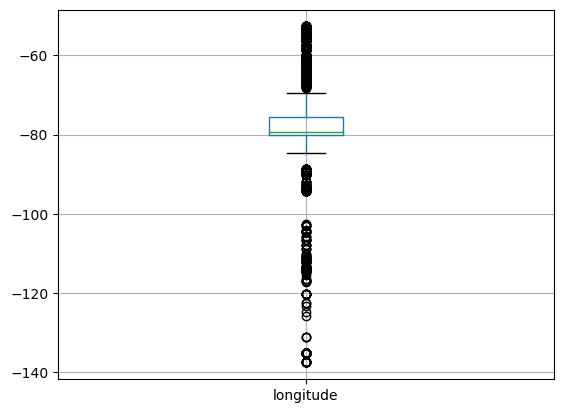

In [253]:
# let's look at box and whisker plot for features with most outliers
insurance_test_data.boxplot(column = col);

In [254]:
col = outlier_features[next(j)][0]
print(col)

COMMUTE_DISTANCE


In [255]:
insurance_test_data.sort_values(by=[col],ascending=False)

QUOTEDATE  VEHICLEYEAR          VEHICLEMAKE  \
140   2017-01-18         2017                 FORD   
8026  2017-01-31         2003             CADILLAC   
11379 2017-02-03         2014                 FORD   
626   2017-01-23         2005    PONTIAC TRUCK/VAN   
3330  2017-02-01         2012       FORD TRUCK/VAN   
...          ...          ...                  ...   
15093 2017-02-17         2009    PONTIAC TRUCK/VAN   
15096 2017-02-21         2000       FORD TRUCK/VAN   
15098 2017-02-21         2003                MAZDA   
15099 2017-02-22         2004                 SAAB   
15100 2017-02-22         2010  DODGE/RAM TRUCK/VAN   

                      VEHICLEMODEL  ANNUAL_KM  COMMUTE_DISTANCE  \
140              FUSION SE 4DR AWD      48000             600.0   
8026                       CTS 4DR       6000             600.0   
11379                FIESTA SE 5DR      48000             600.0   
626                MONTANA SV6 EXT      57200             275.0   
3330   F250 SD LARIAT SUPERCAB 4WD      12500             250.0   
...                            ...        ...               ...   
15093              MONTANA SV6 EXT      10000               NaN   
15096        F150 XLT SUPERCAB 4WD      20000               NaN   
15098        MX5 MIATA CONVERTIBLE       8000               NaN   
15099          9-3 ARC CONVERTIBLE       3000               NaN   
15100           JOURNEY SE 4DR 2WD      10000               NaN   

      VEHICLE_OWNERSHIP  VEHICLE_VALUE VEHICLEUSE  GENDER  ...  MULTI_PRODUCT  \
140                 NaN            NaN    Commute    Male  ...             No   
8026                NaN            NaN   Pleasure    Male  ...             No   
11379               NaN         5900.0    Commute    Male  ...             No   
626                 NaN        20000.0    Commute    Male  ...            Yes   
3330                NaN            NaN    Commute    Male  ...             No   
...                 ...            ...        ...     ...  ...            ...   
15093               NaN            1.0   Pleasure    Male  ...             No   
15096             Owned            NaN   Pleasure    Male  ...            Yes   
15098               NaN            1.0   Pleasure    Male  ...            Yes   
15099               NaN            NaN   Pleasure    Male  ...             No   
15100               NaN            NaN   Pleasure  Female  ...            Yes   

      MARITAL_STATUS          OCCUPATION  CONVICTION_COUNT_MINOR_3YRS  \
140           Single           Not Known                            0   
8026       Separated           Not Known                            0   
11379         Single           Not Known                            1   
626          Married        Labour/Plant                            0   
3330         Married           Not Known                            0   
...              ...                 ...                          ...   
15093      Separated           Not Known                            1   
15096         Single           Not Known                            0   
15098        Married  Professional/Other                            0   
15099         Single             Student                            0   
15100        Married           Not Known                            0   

       CONVICTION_COUNT_MAJOR_3YRS CONVICTION_COUNT_CRIMINAL_3YRS  \
140                              0                              0   
8026                             0                              0   
11379                            0                              0   
626                              0                              0   
3330                             0                              0   
...                            ...                            ...   
15093                            0                              0   
15096                            0                              0   
15098                            0                              0   
15099        

In [256]:
insurance_test_data = swap_annual_km_commute(insurance_test_data)

In [257]:
col = outlier_features[next(j)][0]
print(col)

latitude


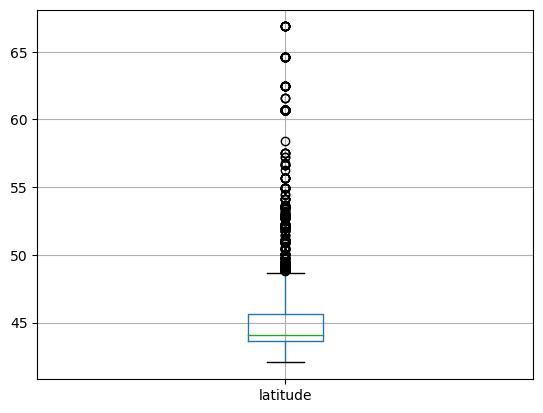

In [258]:
insurance_test_data.boxplot(column = col);

In [259]:
col = outlier_features[next(j)][0]
print(col)

VEHICLEYEAR


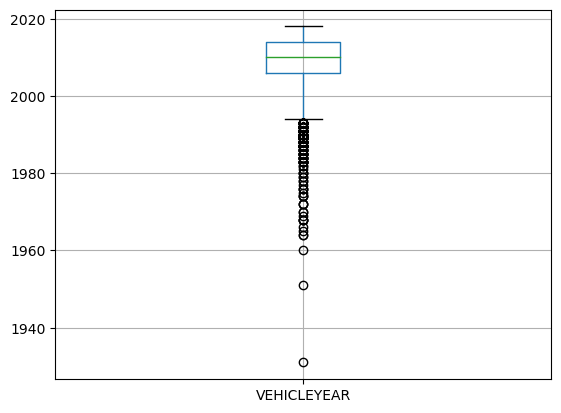

In [260]:
insurance_test_data.boxplot(column = col);

In [261]:
# looking at ANNUAL_KM
col = outlier_features[next(j)][0]
print(col)

ANNUAL_KM


In [262]:
insurance_test_data.sort_values(by=[col],ascending=False)

QUOTEDATE  VEHICLEYEAR        VEHICLEMAKE              VEHICLEMODEL  \
9587  2017-01-09         2016              DODGE              DART SXT 4DR   
2434  2017-01-30         2010             TOYOTA            COROLLA CE 4DR   
8156  2017-01-31         2017     FORD TRUCK/VAN         ESCAPE SE 4DR 4WD   
15013 2017-01-12         2016  HYUNDAI TRUCK/VAN    SANTA FE SPORT 4DR AWD   
6688  2017-01-03         2014               FORD             FUSION SE 4DR   
...          ...          ...                ...                       ...   
226   2017-01-03         2010         VOLKSWAGEN  JETTA 2.0T WOLFSBURG 4DR   
3993  2017-02-21         2008      INTERNATIONAL                       RXT   
12418 2017-02-02         2005              MAZDA             MAZDA3 GT 4DR   
5070  2017-01-20         2006            PONTIAC                 G6 SE 4DR   
6553  2017-02-16         2000               FORD     TAURUS SE COMFORT 4DR   

       ANNUAL_KM  COMMUTE_DISTANCE VEHICLE_OWNERSHIP  VEHICLE_VALUE  \
9587      500000              48.0             Owned            NaN   
2434      480000             100.0               NaN            NaN   
8156      360000               NaN             Owned        25000.0   
15013     250000              25.0             Owned            NaN   
6688      236000              20.0               NaN        20000.0   
...          ...               ...               ...            ...   
226            0               0.0               NaN        30000.0   
3993           0               NaN               NaN        58000.0   
12418          0               0.0               NaN            1.0   
5070           0               NaN               NaN            NaN   
6553           0               0.0               NaN            NaN   

      VEHICLEUSE  GENDER  ...  MULTI_PRODUCT MARITAL_STATUS  \
9587     Commute  Female  ...             No         Single   
2434     Commute    Male  ...             No         Single   
8156    Business  Female  ...            Yes         Single   
15013    Commute  Female  ...            Yes         Single   
6688     Commute    Male  ...            Yes        Married   
...          ...     ...  ...            ...            ...   
226      Commute    Male  ...             No         Single   
3993    Pleasure    Male  ...            Yes        Married   
12418    Commute    Male  ...            Yes         Single   
5070    Pleasure  Female  ...            Yes        Married   
6553     Commute  Female  ...            Yes        Married   

                      OCCUPATION  CONVICTION_COUNT_MINOR_3YRS  \
9587                   Not Known                            0   
2434                Service Work                            0   
8156                   Not Known                            1   
15013                  Not Known                            1   
6688                   Not Known                            0   
...                          ...                          ...   
226                    Not Known                            1   
3993   Management/Administration                            0   
12418                  Not Known                            0   
5070                 Farm/Fisher                            0   
6553                   Not Known                            0   

       CONVICTION_COUNT_MAJOR_3YRS CONVICTION_COUNT_CRIMINAL_3YRS  \
9587                             0                              0   
2434                             0                              0   
8156                             0                              0   
15013                            0                              0   
6688                             0                              0   
...                            ...                            ...   
226                              0                              0   
3993                             0                              0   
12418                            0                        

In [263]:
insurance_test_data = annual_km_above_threshold(insurance_test_data)

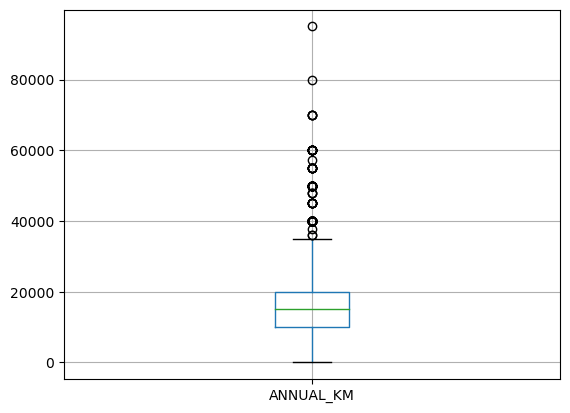

In [264]:
insurance_test_data.boxplot(column = col);

In [265]:
col = outlier_features[next(j)][0]
print(col)

VEHICLE_VALUE


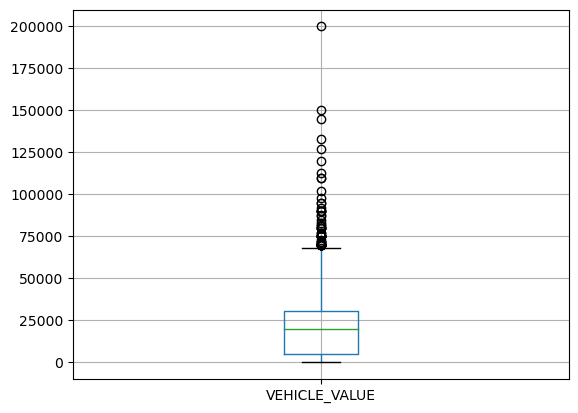

In [266]:
insurance_test_data.boxplot(column = col);

In [267]:
col = outlier_features[next(j)][0]
print(col)

YEARS_LICENSED


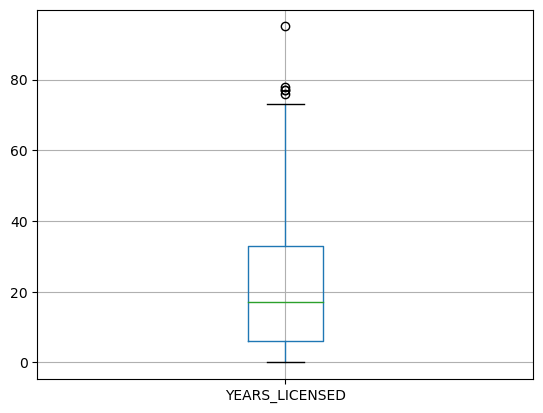

In [268]:
insurance_test_data.boxplot(column = col);

In [269]:
insurance_test_data = years_licenced(insurance_test_data)

### MISSING VALUES

In [270]:
insurance_test_data.drop(columns=dropped_columns, inplace=True)
print('shape of test data: ', insurance_test_data.shape)

shape of test data:  (15114, 24)


In [271]:
j = iter(range(len(columns_with_missing_vals)))

In [272]:
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_test_data[col].isna().sum()}')
insurance_test_data[col].describe()

missing values in ANNUAL_KM: 0


count    15114.000000
mean     14652.451370
std       6805.252638
min          0.000000
25%      10000.000000
50%      15000.000000
75%      20000.000000
max      95000.000000
Name: ANNUAL_KM, dtype: float64

In [273]:
insurance_test_data = impute_annual_km(insurance_test_data, median_annual_km)

In [274]:
insurance_test_data[col].describe()

count    15114.000000
mean     14819.472410
std       6632.314534
min       1200.000000
25%      10000.000000
50%      15000.000000
75%      20000.000000
max      95000.000000
Name: ANNUAL_KM, dtype: float64

In [275]:
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_test_data[col].isna().sum()}')
insurance_test_data[col].describe()

missing values in COMMUTE_DISTANCE: 5191


count    9923.000000
mean       14.240149
std        16.789743
min         0.000000
25%         6.000000
50%        10.000000
75%        16.000000
max       600.000000
Name: COMMUTE_DISTANCE, dtype: float64

In [278]:
insurance_test_data = impute_commute_distance(insurance_test_data, median_commute_dist)
print(f'missing values in {col}: {insurance_test_data[col].isna().sum()}')

missing values in COMMUTE_DISTANCE: 0


In [277]:
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_test_data[col].isna().sum()}')
Counter(insurance_test_data[col])

missing values in VEHICLE_OWNERSHIP: 11500


Counter({nan: 11500, 'Owned': 3250, 'Leased': 360, 'Non-owned': 4})

In [279]:
insurance_test_data.loc[insurance_test_data[col] != insurance_test_data[col], col] = most_freq_ownership
Counter(insurance_test_data[col])

Counter({'Owned': 14750, 'Leased': 360, 'Non-owned': 4})

In [280]:
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_test_data[col].isna().sum()}')
insurance_test_data[col].describe()

missing values in VEHICLE_VALUE: 10159


count      4955.000000
mean      20889.318264
std       17718.220513
min           1.000000
25%        5000.000000
50%       20000.000000
75%       30539.000000
max      200000.000000
Name: VEHICLE_VALUE, dtype: float64

In [281]:
# imputing missing vehicle values from vehicle year and make
insurance_test_data = impute_vehicle_value(insurance_test_data, vehicle_avg_value_dict, median_freq_vehicle_value)

In [282]:
print(f'missing values in {col}: {insurance_test_data[col].isna().sum()}')

missing values in VEHICLE_VALUE: 0


In [283]:
col = columns_with_missing_vals[next(j)]
print(col)
Counter(insurance_test_data[col])

GENDER


Counter({'Male': 8502, 'Female': 6612})

In [284]:
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_test_data[col].isna().sum()}')
insurance_test_data[col].describe()

missing values in YEARS_LICENSED: 3


count    15111.000000
mean        20.639137
std         16.126238
min          0.000000
25%          6.000000
50%         17.000000
75%         33.000000
max         95.000000
Name: YEARS_LICENSED, dtype: float64

In [285]:
insurance_test_data = impute_year_of_birth(insurance_test_data)

In [286]:
print(f'missing values in {col}: {insurance_test_data[col].isna().sum()}')

missing values in YEARS_LICENSED: 0


In [287]:
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_test_data[col].isna().sum()}')
Counter(insurance_test_data[col])

missing values in OCCUPATION: 0


Counter({'Not Known': 13428,
         'Professional/Other': 268,
         'Trades': 260,
         'Retired': 198,
         'Labour/Plant': 164,
         'Office/Stores': 139,
         'Student': 111,
         'Service Work': 100,
         'Homemaker': 93,
         'Management/Administration': 80,
         'Sales': 68,
         'Professional/Health': 53,
         'Farm/Fisher': 38,
         'Government ': 28,
         'Unemployed': 24,
         'Military': 23,
         'Professional/Social': 21,
         'Insurance': 18})

In [288]:
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_test_data[col].isna().sum()}')

missing values in latitude: 6


In [289]:
insurance_test_data = lat_long_impute_func(insurance_test_data)

area code in data: 626 nearest area code: 639
area code in data: 857 nearest area code: 867
area code in data: 512 nearest area code: 514
area code in data: 626 nearest area code: 639


In [290]:
print(f'missing values in {col}: {insurance_test_data[col].isna().sum()}')

missing values in latitude: 0


In [291]:
col = columns_with_missing_vals[next(j)]
print(f'missing values in {col}: {insurance_test_data[col].isna().sum()}')

missing values in longitude: 0


In [292]:
insurance_test_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15114 entries, 0 to 15113
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   QUOTEDATE                       15114 non-null  datetime64[ns]
 1   VEHICLEYEAR                     15114 non-null  int64         
 2   VEHICLEMAKE                     15114 non-null  object        
 3   VEHICLEMODEL                    15114 non-null  object        
 4   ANNUAL_KM                       15114 non-null  int64         
 5   COMMUTE_DISTANCE                15114 non-null  float64       
 6   VEHICLE_OWNERSHIP               15114 non-null  object        
 7   VEHICLE_VALUE                   15114 non-null  float64       
 8   VEHICLEUSE                      15114 non-null  object        
 9   GENDER                          15114 non-null  object        
 10  YEAR_OF_BIRTH                   15114 non-null  int64         
 11  PO

#### CATEGORICAL COLUMNS

In [293]:
# keeping top vehicle models
top_vehicle_models = reduced_vehicle_model_column(insurance_test_data)

In [294]:
insurance_test_data_reduced = insurance_test_data.drop(columns=['VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE'])
insurance_test_data_reduced.shape

(15114, 21)

In [295]:
insurance_test_data_reduced['TOPVEHICLEMODELS'] = top_vehicle_models

In [296]:
# extracting month and converting to string
month = insurance_test_data_reduced['QUOTEDATE'].dt.month
insurance_test_data_reduced['MONTH'] = [str(val) for val in month.values]
insurance_test_data_reduced.drop(columns=['QUOTEDATE'],inplace=True)

In [297]:
# creating dummy variables
string_columns = insurance_test_data_reduced.select_dtypes(include='O').columns.values
prefix = {col: col for col in string_columns}
insurance_test_data_reduced_numerical = pd.get_dummies(insurance_test_data_reduced, prefix = prefix,
                          drop_first=True)

#### Key Step

**Some categories in train set may not be present in test set. In order to overcome this, we use pd.reindex method to create such columns in the test set and set their values to zero.**

In [302]:
insurance_test_data_reduced_numerical = insurance_test_data_reduced_numerical.reindex(columns = insurance_train_data_reduced_numerical.columns, fill_value=0)
insurance_test_data_reduced_numerical.drop(columns = ['IS_BOUND'], inplace = True)

In [303]:
final_test_data_df = data_preparation(insurance_test_data_reduced_numerical, numerical_features, categorical_features, X_transformer)
final_test_data_df.head()

VEHICLEYEAR  ANNUAL_KM  COMMUTE_DISTANCE  VEHICLE_VALUE  YEAR_OF_BIRTH  \
0     0.808989   0.091847          0.005008       0.010496       0.757895   
1     0.898876   0.091847          0.015025       0.037761       0.694737   
2     0.977528   0.081527          0.003339       0.089998       0.484211   
3     0.932584   0.091847          0.015025       0.068748       0.747368   
4     0.943820   0.195046          0.015025       0.032599       0.778947   

   YEARS_LICENSED  CONVICTION_COUNT_MINOR_3YRS  CONVICTION_COUNT_MAJOR_3YRS  \
0        0.071429                          0.0                          0.0   
1        0.132653                          0.0                          0.0   
2        0.336735                          0.0                          0.0   
3        0.091837                          0.0                          0.0   
4        0.040816                          0.0                          0.0   

   CONVICTION_COUNT_CRIMINAL_3YRS  ASSIGNED_LOSSES_PD_5YRS  ...  MONTH_11  \
0                             0.0                      0.0  ...         0   
1                             0.0                      0.0  ...         0   
2                             0.0                      0.0  ...         0   
3                             0.0                      0.0  ...         0   
4                             0.0                      0.0  ...         0   

   MONTH_12  MONTH_2  MONTH_3  MONTH_4  MONTH_5  MONTH_6  MONTH_7  MONTH_8  \
0         0        0        0        0        0        0        0        0   
1         0        0        0        0        0        0        0        0   
2         0        0        0        0        0        0        0        0   
3         0        0        0        0        0        0        0        0   
4         0        0        0        0        0        0        0        0   

   MONTH_9  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 668 columns]

In [304]:
# asserting that the number of columns in test dataset is same as training set
assert final_test_data_df.shape[1] == resampled_train_data_df.shape[1]
# asserting that the number of rows in test dataset is same as original test set
assert final_test_data_df.shape[0] == original_len_test_data

In [305]:
y_preds = final_model.predict(final_test_data_df)

In [306]:
y_preds_list = y_preds.tolist()